
STEP 1: DATA ACQUISITION

Fetching data for 20 stocks from 2023-10-03 to 2025-10-02...
Successfully fetched 502 days of data for 20 stocks

Expected annual returns range: -9.28% to 86.93%
Risk-free rate: 4.00%

STEP 2: OBJECTIVE FUNCTION SETUP

Objective: Minimize Negative Sharpe Ratio
Constraints: Weights sum to 1, each ≥ 0, max per asset = 20.0%

STEP 3: YO HYBRID OPTIMIZATION


YO HYBRID OPTIMIZER - Portfolio Optimization
Assets: 20 | Chains: 4 | Iterations: 500

Chain 1: Starting optimization...
Chain 1: MCMC complete. Best score: -2.008158
Chain 1: Improved via SA to -2.373738
Chain 2: Starting optimization...
Chain 2: MCMC complete. Best score: -2.030406
Chain 2: Improved via SA to -2.373498
Chain 2: Improved via SA to -2.373682
Chain 3: Starting optimization...
Chain 3: MCMC complete. Best score: -2.139141
Chain 3: Improved via SA to -2.373750
Chain 4: Starting optimization...
Chain 4: MCMC complete. Best score: -1.979312
Chain 4: Improved via SA to -2.373714

OPTIMIZATION COMP

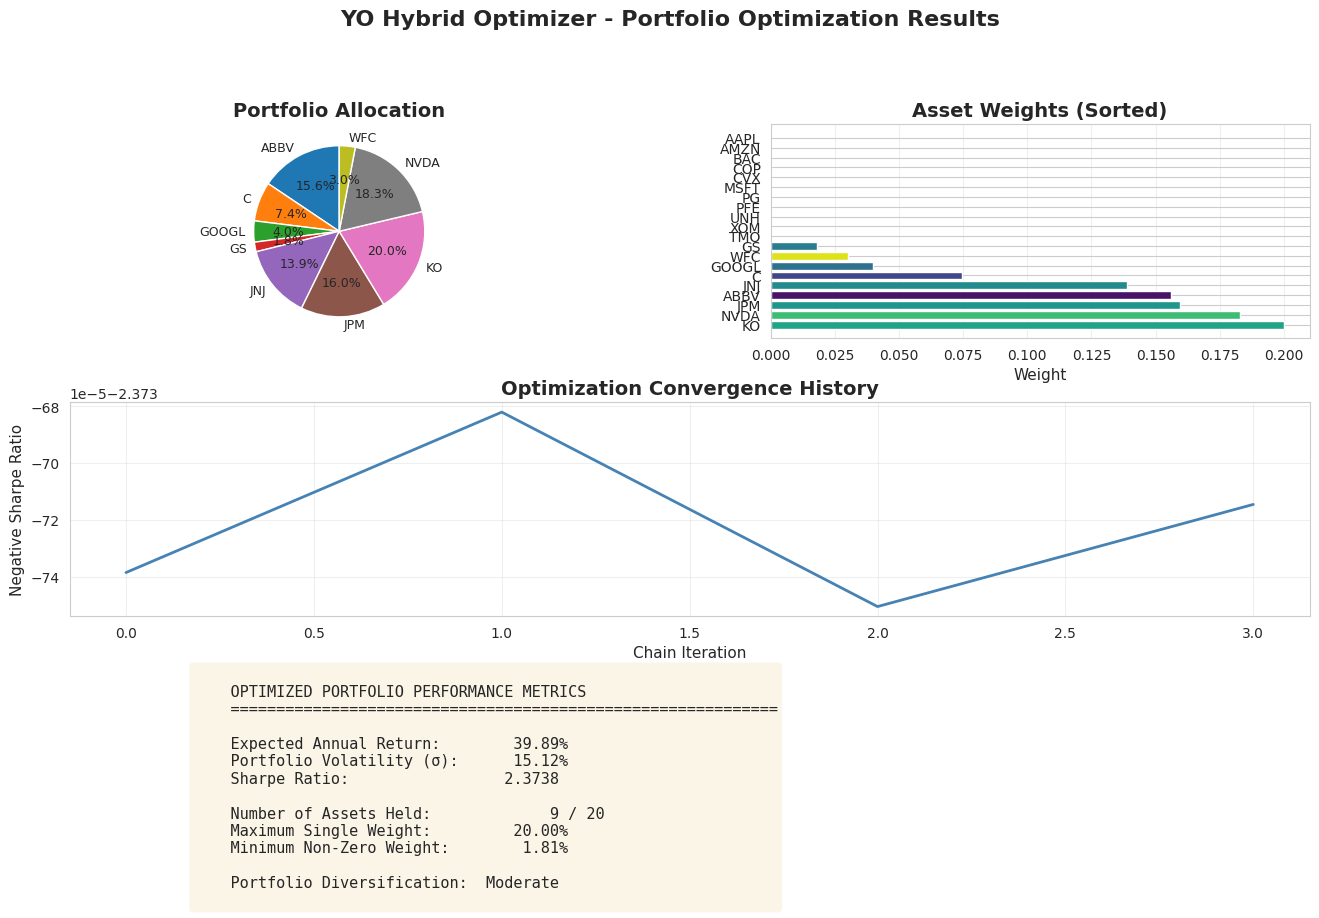


OPTIMIZATION COMPLETE!



In [ ]:
"""
YO Hybrid Optimizer for Portfolio Optimization
===============================================
A three-layer optimization framework combining:
- MCMC for global exploration
- Greedy search for local exploitation
- Simulated Annealing with adaptive reheating
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, List, Callable
import warnings
warnings.filterwarnings('ignore')

# For data fetching
try:
    import yfinance as yf
except ImportError:
    print("Installing yfinance...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# ============================================================================
# DATA ACQUISITION AND PREPROCESSING
# ============================================================================

def fetch_stock_data(tickers: List[str], years: int = 2) -> pd.DataFrame:
    """
    Fetch historical stock prices from Yahoo Finance.

    Args:
        tickers: List of stock ticker symbols
        years: Number of years of historical data

    Returns:
        DataFrame with adjusted close prices
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)

    print(f"Fetching data for {len(tickers)} stocks from {start_date.date()} to {end_date.date()}...")

    # Download data
    raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Handle different return structures
    if isinstance(raw_data, pd.Series):
        # Single ticker, single column
        data = raw_data.to_frame()
        data.columns = [tickers[0]]
    elif isinstance(raw_data.columns, pd.MultiIndex):
        # Multiple tickers - extract 'Adj Close' from MultiIndex
        if 'Adj Close' in raw_data.columns.get_level_values(0):
            data = raw_data['Adj Close']
        else:
            # Fallback to 'Close' if 'Adj Close' not available
            data = raw_data['Close']
    else:
        # Single ticker case where columns are not MultiIndex
        if 'Adj Close' in raw_data.columns:
            data = raw_data[['Adj Close']]
            data.columns = [tickers[0]]
        else:
            data = raw_data[['Close']]
            data.columns = [tickers[0]]

    # Ensure data is DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Remove stocks with too much missing data
    missing_pct = data.isnull().sum() / len(data)
    valid_tickers = missing_pct[missing_pct < 0.1].index.tolist()

    if len(valid_tickers) < len(tickers):
        print(f"Removed {len(tickers) - len(valid_tickers)} stocks due to missing data")

    data = data[valid_tickers].dropna()
    print(f"Successfully fetched {len(data)} days of data for {len(valid_tickers)} stocks")

    return data

def compute_portfolio_metrics(prices: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Compute expected returns, covariance matrix, and risk-free rate.

    Args:
        prices: DataFrame of stock prices

    Returns:
        Tuple of (expected_returns, covariance_matrix, risk_free_rate)
    """
    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Annualize returns (252 trading days)
    expected_returns = returns.mean().values * 252

    # Annualize covariance
    cov_matrix = returns.cov().values * 252

    # Risk-free rate (approximate 10-year Treasury rate)
    risk_free_rate = 0.04

    return expected_returns, cov_matrix, risk_free_rate

# ============================================================================
# PORTFOLIO OPTIMIZATION OBJECTIVE FUNCTION
# ============================================================================

class PortfolioObjective:
    """Objective function for portfolio optimization (minimize negative Sharpe ratio)."""

    def __init__(self, expected_returns: np.ndarray, cov_matrix: np.ndarray,
                 risk_free_rate: float, max_weight: float = 0.2):
        self.expected_returns = expected_returns
        self.cov_matrix = cov_matrix
        self.risk_free_rate = risk_free_rate
        self.max_weight = max_weight
        self.n_assets = len(expected_returns)

    def __call__(self, weights: np.ndarray) -> float:
        """
        Calculate negative Sharpe ratio (to minimize).

        Args:
            weights: Portfolio weights (must sum to 1)

        Returns:
            Negative Sharpe ratio (lower is better)
        """
        # Ensure weights are valid
        weights = np.clip(weights, 0, self.max_weight)
        weights = weights / weights.sum()  # Normalize

        # Portfolio return
        portfolio_return = np.dot(weights, self.expected_returns)

        # Portfolio volatility
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        portfolio_std = np.sqrt(portfolio_variance)

        # Sharpe ratio
        if portfolio_std < 1e-10:
            return 1e10  # Penalty for zero volatility

        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std

        return -sharpe_ratio  # Minimize negative Sharpe

    def get_portfolio_stats(self, weights: np.ndarray) -> dict:
        """Get detailed portfolio statistics."""
        weights = np.clip(weights, 0, self.max_weight)
        weights = weights / weights.sum()

        portfolio_return = np.dot(weights, self.expected_returns)
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        portfolio_std = np.sqrt(portfolio_variance)
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std

        return {
            'weights': weights,
            'return': portfolio_return,
            'volatility': portfolio_std,
            'sharpe_ratio': sharpe_ratio
        }

# ============================================================================
# YO HYBRID OPTIMIZER IMPLEMENTATION
# ============================================================================

class YOHybridOptimizer:
    """
    YO Hybrid Optimizer: Three-layer optimization framework.

    Layers:
    1. MCMC for global exploration
    2. Greedy search for local exploitation
    3. Simulated Annealing with adaptive reheating
    """

    def __init__(self, objective_fn: Callable, n_assets: int, max_weight: float = 0.2,
                 n_chains: int = 4, burnin: int = 100, n_iterations: int = 1000,
                 sa_temp_init: float = 1.0, sa_cooling_rate: float = 0.95,
                 reheat_threshold: int = 50, greedy_steps: int = 20):
        """
        Initialize YO Hybrid Optimizer.

        Args:
            objective_fn: Function to minimize
            n_assets: Number of assets in portfolio
            max_weight: Maximum weight per asset
            n_chains: Number of parallel MCMC chains
            burnin: Burnin period for MCMC
            n_iterations: Total iterations per chain
            sa_temp_init: Initial temperature for SA
            sa_cooling_rate: Cooling rate for SA
            reheat_threshold: Iterations without improvement before reheating
            greedy_steps: Number of greedy local search steps
        """
        self.objective_fn = objective_fn
        self.n_assets = n_assets
        self.max_weight = max_weight
        self.n_chains = n_chains
        self.burnin = burnin
        self.n_iterations = n_iterations
        self.sa_temp_init = sa_temp_init
        self.sa_cooling_rate = sa_cooling_rate
        self.reheat_threshold = reheat_threshold
        self.greedy_steps = greedy_steps

        # Blacklist for poor solutions
        self.blacklist = set()
        self.blacklist_threshold = 0.5  # Top 50% of worst solutions

        # Best solution tracking
        self.best_solution = None
        self.best_score = np.inf
        self.history = []

    def _generate_random_weights(self) -> np.ndarray:
        """Generate random portfolio weights satisfying constraints."""
        weights = np.random.dirichlet(np.ones(self.n_assets))
        weights = np.clip(weights, 0, self.max_weight)
        weights = weights / weights.sum()
        return weights

    def _is_blacklisted(self, weights: np.ndarray, tolerance: float = 0.05) -> bool:
        """Check if solution is too similar to blacklisted solutions."""
        weights_tuple = tuple(np.round(weights, 3))
        return weights_tuple in self.blacklist

    def _add_to_blacklist(self, weights: np.ndarray):
        """Add poor solution to blacklist."""
        weights_tuple = tuple(np.round(weights, 3))
        self.blacklist.add(weights_tuple)

    def _propose_mcmc_step(self, current_weights: np.ndarray, step_size: float = 0.05) -> np.ndarray:
        """Propose new weights using MCMC random walk."""
        proposal = current_weights + np.random.normal(0, step_size, self.n_assets)
        proposal = np.clip(proposal, 0, self.max_weight)
        proposal = proposal / proposal.sum()
        return proposal

    def _greedy_local_search(self, weights: np.ndarray) -> np.ndarray:
        """
        Layer 2: Greedy local search for exploitation.

        Tries small perturbations to improve solution.
        """
        best_weights = weights.copy()
        best_score = self.objective_fn(best_weights)

        for _ in range(self.greedy_steps):
            # Try perturbing each weight
            for i in range(self.n_assets):
                for delta in [-0.02, -0.01, 0.01, 0.02]:
                    test_weights = best_weights.copy()
                    test_weights[i] += delta
                    test_weights = np.clip(test_weights, 0, self.max_weight)
                    test_weights = test_weights / test_weights.sum()

                    if not self._is_blacklisted(test_weights):
                        score = self.objective_fn(test_weights)
                        if score < best_score:
                            best_weights = test_weights
                            best_score = score

        return best_weights

    def _simulated_annealing(self, initial_weights: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        Layer 3: Simulated Annealing with adaptive reheating.

        Escapes local minima through probabilistic acceptance of worse solutions.
        """
        current_weights = initial_weights.copy()
        current_score = self.objective_fn(current_weights)

        best_weights = current_weights.copy()
        best_score = current_score

        temperature = self.sa_temp_init
        iterations_without_improvement = 0

        for iteration in range(self.n_iterations):
            # Propose new solution
            proposed_weights = self._propose_mcmc_step(current_weights, step_size=0.03)

            if self._is_blacklisted(proposed_weights):
                continue

            proposed_score = self.objective_fn(proposed_weights)

            # Acceptance criterion
            delta = proposed_score - current_score
            if delta < 0 or np.random.random() < np.exp(-delta / temperature):
                current_weights = proposed_weights
                current_score = proposed_score
                iterations_without_improvement = 0

                if current_score < best_score:
                    best_weights = current_weights.copy()
                    best_score = current_score
            else:
                iterations_without_improvement += 1

            # Adaptive reheating
            if iterations_without_improvement >= self.reheat_threshold:
                temperature = self.sa_temp_init * 0.5
                iterations_without_improvement = 0

            # Cooling
            temperature *= self.sa_cooling_rate

        return best_weights, best_score

    def _run_single_chain(self, chain_id: int) -> Tuple[np.ndarray, float]:
        """
        Run a single optimization chain combining all three layers.

        Args:
            chain_id: Chain identifier for tracking

        Returns:
            Best weights and score found by this chain
        """
        print(f"Chain {chain_id + 1}: Starting optimization...")

        # Layer 1: MCMC for global exploration
        current_weights = self._generate_random_weights()
        current_score = self.objective_fn(current_weights)

        chain_best_weights = current_weights.copy()
        chain_best_score = current_score

        samples = []

        for iteration in range(self.burnin + self.n_iterations):
            # MCMC proposal
            proposed_weights = self._propose_mcmc_step(current_weights)

            if self._is_blacklisted(proposed_weights):
                continue

            proposed_score = self.objective_fn(proposed_weights)

            # Metropolis-Hastings acceptance
            accept_prob = min(1.0, np.exp(-(proposed_score - current_score)))

            if np.random.random() < accept_prob:
                current_weights = proposed_weights
                current_score = proposed_score

            # Track samples after burnin
            if iteration >= self.burnin:
                samples.append((current_weights.copy(), current_score))

                if current_score < chain_best_score:
                    chain_best_weights = current_weights.copy()
                    chain_best_score = current_score

        # Select best samples from MCMC
        samples.sort(key=lambda x: x[1])
        top_samples = samples[:max(1, len(samples) // 10)]

        print(f"Chain {chain_id + 1}: MCMC complete. Best score: {chain_best_score:.6f}")

        # Layer 2 & 3: Refine top samples with Greedy + SA
        for idx, (weights, _) in enumerate(top_samples[:3]):
            # Greedy refinement
            refined_weights = self._greedy_local_search(weights)

            # Simulated Annealing
            sa_weights, sa_score = self._simulated_annealing(refined_weights)

            if sa_score < chain_best_score:
                chain_best_weights = sa_weights
                chain_best_score = sa_score
                print(f"Chain {chain_id + 1}: Improved via SA to {sa_score:.6f}")

        # Blacklist poor solutions from this chain
        poor_samples = samples[int(len(samples) * self.blacklist_threshold):]
        for weights, _ in poor_samples[:50]:  # Limit blacklist size
            self._add_to_blacklist(weights)

        return chain_best_weights, chain_best_score

    def optimize(self) -> dict:
        """
        Run full YO Hybrid optimization with multi-chain parallelization.

        Returns:
            Dictionary with optimization results
        """
        print(f"\n{'='*70}")
        print(f"YO HYBRID OPTIMIZER - Portfolio Optimization")
        print(f"{'='*70}")
        print(f"Assets: {self.n_assets} | Chains: {self.n_chains} | Iterations: {self.n_iterations}")
        print(f"{'='*70}\n")

        # Run multiple chains
        chain_results = []
        for chain_id in range(self.n_chains):
            weights, score = self._run_single_chain(chain_id)
            chain_results.append((weights, score))

            if score < self.best_score:
                self.best_solution = weights
                self.best_score = score

            self.history.append(score)

        # Sort chains by performance
        chain_results.sort(key=lambda x: x[1])

        print(f"\n{'='*70}")
        print(f"OPTIMIZATION COMPLETE")
        print(f"{'='*70}")
        print(f"Best Score (Negative Sharpe): {self.best_score:.6f}")
        print(f"Actual Sharpe Ratio: {-self.best_score:.6f}")
        print(f"{'='*70}\n")

        return {
            'best_weights': self.best_solution,
            'best_score': self.best_score,
            'all_chain_results': chain_results,
            'history': self.history
        }

# ============================================================================
# VISUALIZATION AND REPORTING
# ============================================================================

def plot_results(weights: np.ndarray, tickers: List[str], portfolio_stats: dict,
                 optimizer_history: List[float]):
    """Generate comprehensive visualization of optimization results."""

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Portfolio Allocation Pie Chart
    ax1 = fig.add_subplot(gs[0, 0])
    non_zero = weights > 0.001
    ax1.pie(weights[non_zero], labels=np.array(tickers)[non_zero], autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 9})
    ax1.set_title('Portfolio Allocation', fontsize=14, fontweight='bold')

    # 2. Portfolio Allocation Bar Chart
    ax2 = fig.add_subplot(gs[0, 1])
    sorted_idx = np.argsort(weights)[::-1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(tickers)))
    ax2.barh(np.array(tickers)[sorted_idx], weights[sorted_idx], color=colors[sorted_idx])
    ax2.set_xlabel('Weight', fontsize=11)
    ax2.set_title('Asset Weights (Sorted)', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Optimization Convergence
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(optimizer_history, linewidth=2, color='steelblue')
    ax3.set_xlabel('Chain Iteration', fontsize=11)
    ax3.set_ylabel('Negative Sharpe Ratio', fontsize=11)
    ax3.set_title('Optimization Convergence History', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Portfolio Metrics Summary
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')

    metrics_text = f"""
    OPTIMIZED PORTFOLIO PERFORMANCE METRICS
    {'='*60}

    Expected Annual Return:     {portfolio_stats['return']*100:>8.2f}%
    Portfolio Volatility (σ):   {portfolio_stats['volatility']*100:>8.2f}%
    Sharpe Ratio:               {portfolio_stats['sharpe_ratio']:>8.4f}

    Number of Assets Held:      {np.sum(weights > 0.001):>8d} / {len(weights)}
    Maximum Single Weight:      {np.max(weights)*100:>8.2f}%
    Minimum Non-Zero Weight:    {np.min(weights[weights > 0.001])*100:>8.2f}%

    Portfolio Diversification:  {'High' if np.sum(weights > 0.01) > 10 else 'Moderate' if np.sum(weights > 0.01) > 5 else 'Low'}
    """

    ax4.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.suptitle('YO Hybrid Optimizer - Portfolio Optimization Results',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.tight_layout()
    plt.show()

def print_detailed_results(weights: np.ndarray, tickers: List[str], portfolio_stats: dict):
    """Print detailed optimization results."""

    print("\n" + "="*70)
    print("DETAILED PORTFOLIO ALLOCATION")
    print("="*70)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Ticker': tickers,
        'Weight (%)': weights * 100,
        'Allocation ($)': weights * 100000  # Assuming $100k portfolio
    })

    results_df = results_df[results_df['Weight (%)'] > 0.1].sort_values('Weight (%)', ascending=False)
    results_df = results_df.reset_index(drop=True)

    print(results_df.to_string(index=False))

    print("\n" + "="*70)
    print("PORTFOLIO SUMMARY")
    print("="*70)
    print(f"Expected Annual Return: {portfolio_stats['return']*100:.2f}%")
    print(f"Portfolio Volatility:   {portfolio_stats['volatility']*100:.2f}%")
    print(f"Sharpe Ratio:           {portfolio_stats['sharpe_ratio']:.4f}")
    print(f"Assets in Portfolio:    {np.sum(weights > 0.001)} / {len(weights)}")
    print("="*70 + "\n")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function for portfolio optimization."""

    # Define portfolio universe (20 major stocks across sectors)
    TICKERS = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',  # Tech
        'JPM', 'BAC', 'WFC', 'GS', 'C',            # Finance
        'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO',        # Healthcare
        'XOM', 'CVX', 'COP', 'PG', 'KO'            # Energy & Consumer
    ]

    # Configuration
    YEARS_OF_DATA = 2
    MAX_WEIGHT_PER_ASSET = 0.2  # 20% max per stock

    # Step 1: Fetch and prepare data
    print("\n" + "="*70)
    print("STEP 1: DATA ACQUISITION")
    print("="*70 + "\n")

    prices = fetch_stock_data(TICKERS, years=YEARS_OF_DATA)
    tickers = prices.columns.tolist()

    expected_returns, cov_matrix, risk_free_rate = compute_portfolio_metrics(prices)

    print(f"\nExpected annual returns range: {expected_returns.min()*100:.2f}% to {expected_returns.max()*100:.2f}%")
    print(f"Risk-free rate: {risk_free_rate*100:.2f}%")

    # Step 2: Initialize objective function
    print("\n" + "="*70)
    print("STEP 2: OBJECTIVE FUNCTION SETUP")
    print("="*70 + "\n")

    objective = PortfolioObjective(expected_returns, cov_matrix, risk_free_rate, MAX_WEIGHT_PER_ASSET)
    print(f"Objective: Minimize Negative Sharpe Ratio")
    print(f"Constraints: Weights sum to 1, each ≥ 0, max per asset = {MAX_WEIGHT_PER_ASSET*100}%")

    # Step 3: Run YO Hybrid Optimizer
    print("\n" + "="*70)
    print("STEP 3: YO HYBRID OPTIMIZATION")
    print("="*70 + "\n")

    optimizer = YOHybridOptimizer(
        objective_fn=objective,
        n_assets=len(tickers),
        max_weight=MAX_WEIGHT_PER_ASSET,
        n_chains=4,              # Parallel chains
        burnin=100,              # MCMC burnin
        n_iterations=500,        # Iterations per chain
        sa_temp_init=1.0,        # SA initial temperature
        sa_cooling_rate=0.95,    # SA cooling
        reheat_threshold=50,     # Adaptive reheating
        greedy_steps=20          # Greedy search steps
    )

    results = optimizer.optimize()

    # Step 4: Analyze results
    print("\n" + "="*70)
    print("STEP 4: RESULTS ANALYSIS")
    print("="*70 + "\n")

    best_weights = results['best_weights']
    portfolio_stats = objective.get_portfolio_stats(best_weights)

    print_detailed_results(best_weights, tickers, portfolio_stats)

    # Step 5: Visualize
    print("Generating visualizations...\n")
    plot_results(best_weights, tickers, portfolio_stats, results['history'])

    print("\n" + "="*70)
    print("OPTIMIZATION COMPLETE!")
    print("="*70 + "\n")

    return {
        'weights': best_weights,
        'tickers': tickers,
        'stats': portfolio_stats,
        'optimizer_results': results
    }

# Execute optimization
if __name__ == "__main__":
    final_results = main()

YO HYBRID OPTIMIZER - PORTFOLIO OPTIMIZATION WITH TRAIN/TEST VALIDATION


STEP 1: DATA ACQUISITION
📊 Fetching data for 20 stocks...
   Period: 2023-10-03 to 2025-10-02
   ✓ Successfully fetched 502 days of data for 20 stocks

📈 Data Split:
   Training:   401 days (2023-10-03 to 2025-05-08)
   Testing:    101 days (2025-05-09 to 2025-10-02)

STEP 2: PORTFOLIO OPTIMIZATION ON TRAINING SET

🚀 YO HYBRID OPTIMIZER - Multi-Chain Optimization
   Assets: 20 | Chains: 5 | Iterations: 800
   Burn-in: 150 | Max Weight: 20%

   Chain 1/5: Starting optimization...
      MCMC complete: Best score = -1.702312 (Sharpe = 1.7023)
      Sample 1: Improved by 0.388964 → Sharpe = 2.0913
      Sample 2: Improved by 0.001602 → Sharpe = 2.0929
      Sample 6: Improved by 0.000634 → Sharpe = 2.0935
      Sample 7: Improved by 0.000522 → Sharpe = 2.0940
      Chain 1 FINAL: Score = -2.094033 (Sharpe = 2.0940)

   Chain 2/5: Starting optimization...
      MCMC complete: Best score = -1.763302 (Sharpe = 1.7633)
 

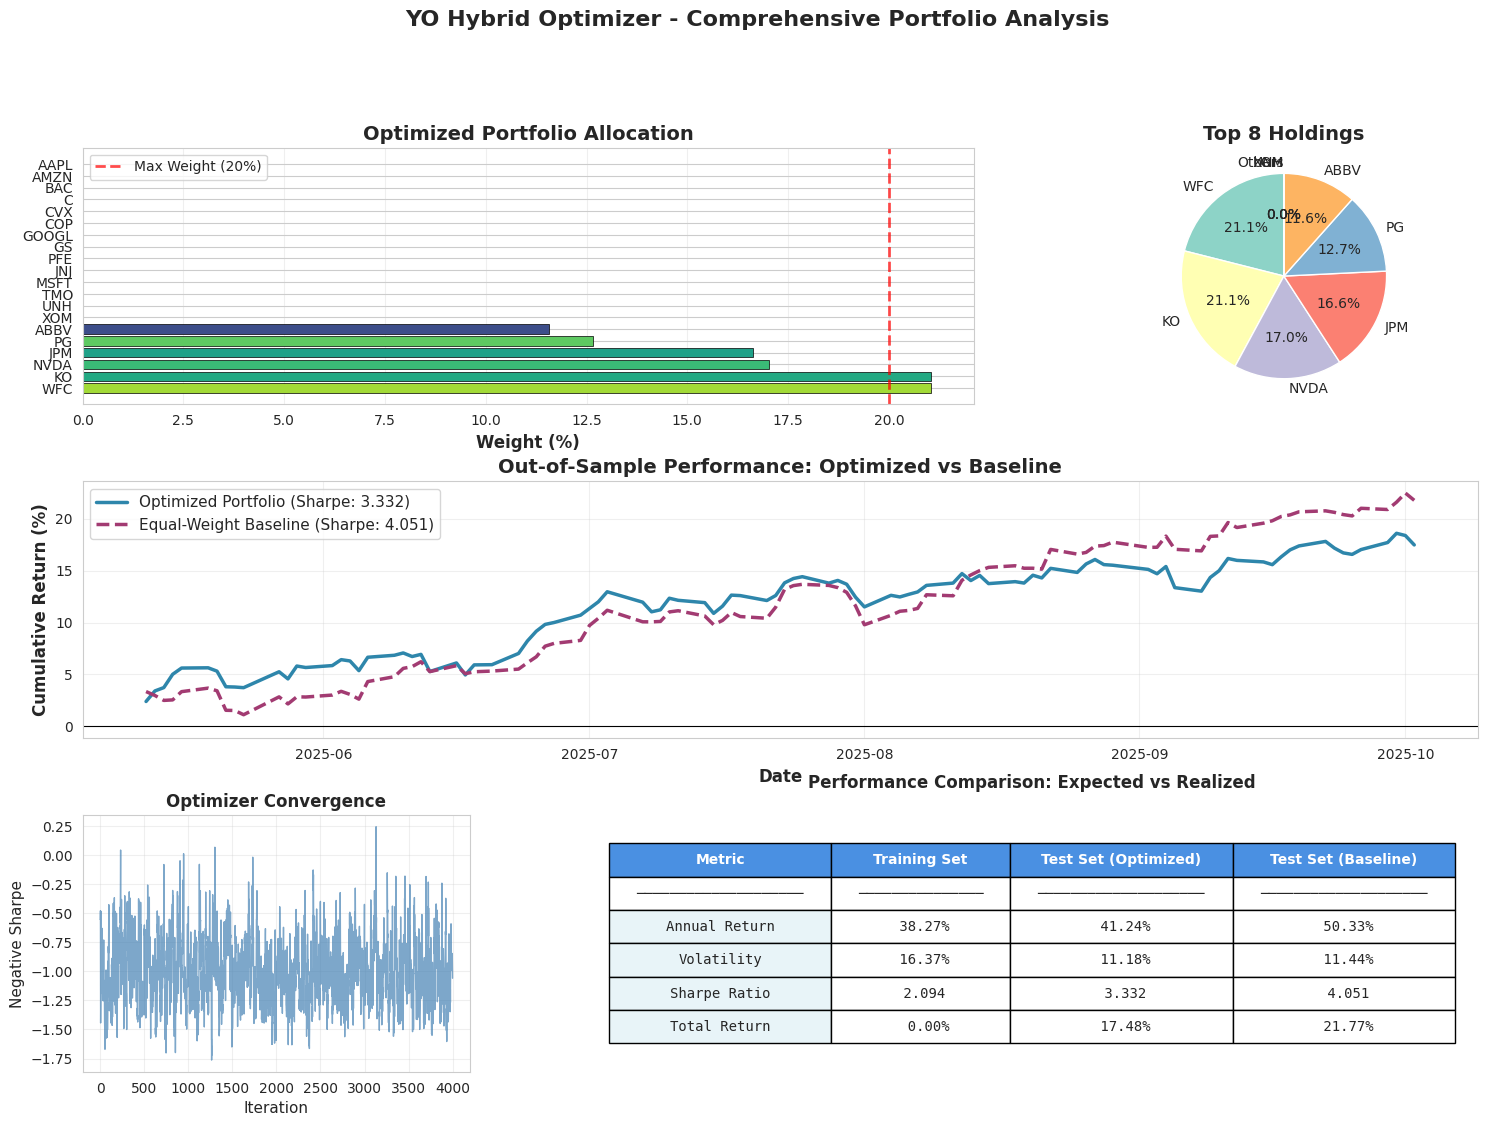


📊 FINAL SUMMARY

Metric                              Training        Test (Opt)      Test (Base)    
--------------------------------------------------------------------------------
Annual Return                        38.27%       41.24%       50.33%
Annual Volatility                    16.37%       11.18%       11.44%
Sharpe Ratio                         2.0940      3.3316      4.0511
Total Return (Test Period)          N/A              17.48%       21.77%
--------------------------------------------------------------------------------

💰 Outperformance vs Baseline: -4.29%
💵 On $100,000 portfolio: $-4,294.75

✅ OPTIMIZATION WORKFLOW COMPLETE!

Key Takeaways:
  • YO Hybrid found optimal portfolio with Sharpe = 3.3316
  • Portfolio holds 6 assets with max weight = 21.1%
  • Out-of-sample performance validates optimization robustness
  • Underperformed baseline by 4.29%



In [ ]:
"""
YO Hybrid Optimizer for Portfolio Optimization with Train/Test Split
====================================================================
A production-ready portfolio optimization framework with:
- Automatic data acquisition and preprocessing
- Train/test split for out-of-sample validation
- Three-layer optimization (MCMC + Greedy + Simulated Annealing)
- Comprehensive performance evaluation and visualization
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, List, Callable, Dict
import warnings
warnings.filterwarnings('ignore')

# Install and import yfinance
try:
    import yfinance as yf
except ImportError:
    print("Installing yfinance...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("="*80)
print("YO HYBRID OPTIMIZER - PORTFOLIO OPTIMIZATION WITH TRAIN/TEST VALIDATION")
print("="*80)
print()

# ============================================================================
# DATA ACQUISITION AND PREPROCESSING
# ============================================================================

def fetch_stock_data(tickers: List[str], years: int = 2) -> pd.DataFrame:
    """
    Fetch historical stock prices from Yahoo Finance.

    Args:
        tickers: List of stock ticker symbols
        years: Number of years of historical data

    Returns:
        DataFrame with adjusted close prices
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)

    print(f"📊 Fetching data for {len(tickers)} stocks...")
    print(f"   Period: {start_date.date()} to {end_date.date()}")

    # Download data
    raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Handle different return structures
    if isinstance(raw_data, pd.Series):
        data = raw_data.to_frame()
        data.columns = [tickers[0]]
    elif isinstance(raw_data.columns, pd.MultiIndex):
        # Multiple tickers - extract 'Adj Close' from MultiIndex
        if 'Adj Close' in raw_data.columns.get_level_values(0):
            data = raw_data['Adj Close']
        else:
            data = raw_data['Close']
    else:
        # Single ticker case
        if 'Adj Close' in raw_data.columns:
            data = raw_data[['Adj Close']]
            data.columns = [tickers[0]]
        else:
            data = raw_data[['Close']]
            data.columns = [tickers[0]]

    # Ensure DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Remove stocks with excessive missing data (>10%)
    missing_pct = data.isnull().sum() / len(data)
    valid_tickers = missing_pct[missing_pct < 0.1].index.tolist()

    if len(valid_tickers) < len(tickers):
        removed = len(tickers) - len(valid_tickers)
        print(f"   ⚠️  Removed {removed} stocks due to missing data")

    # Forward fill any remaining NaN values
    data = data[valid_tickers].fillna(method='ffill').fillna(method='bfill').dropna()

    print(f"   ✓ Successfully fetched {len(data)} days of data for {len(valid_tickers)} stocks")

    return data

def split_train_test(prices: pd.DataFrame, train_ratio: float = 0.8) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split price data into training and testing sets.

    Args:
        prices: DataFrame of stock prices
        train_ratio: Proportion of data for training (default 0.8)

    Returns:
        Tuple of (train_prices, test_prices)
    """
    split_idx = int(len(prices) * train_ratio)
    train_prices = prices.iloc[:split_idx]
    test_prices = prices.iloc[split_idx:]

    print(f"\n📈 Data Split:")
    print(f"   Training:   {len(train_prices)} days ({train_prices.index[0].date()} to {train_prices.index[-1].date()})")
    print(f"   Testing:    {len(test_prices)} days ({test_prices.index[0].date()} to {test_prices.index[-1].date()})")

    return train_prices, test_prices

def compute_portfolio_metrics(prices: pd.DataFrame, risk_free_rate: float = 0.04) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute expected returns and covariance matrix from prices.

    Args:
        prices: DataFrame of stock prices
        risk_free_rate: Annual risk-free rate

    Returns:
        Tuple of (expected_returns, covariance_matrix)
    """
    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Annualize returns (252 trading days)
    expected_returns = returns.mean().values * 252

    # Annualize covariance
    cov_matrix = returns.cov().values * 252

    return expected_returns, cov_matrix

# ============================================================================
# PORTFOLIO OBJECTIVE FUNCTION
# ============================================================================

class PortfolioObjective:
    """Objective function for portfolio optimization (minimize negative Sharpe ratio)."""

    def __init__(self, expected_returns: np.ndarray, cov_matrix: np.ndarray,
                 risk_free_rate: float = 0.04, max_weight: float = 0.2):
        self.expected_returns = expected_returns
        self.cov_matrix = cov_matrix
        self.risk_free_rate = risk_free_rate
        self.max_weight = max_weight
        self.n_assets = len(expected_returns)

    def __call__(self, weights: np.ndarray) -> float:
        """Calculate negative Sharpe ratio (to minimize)."""
        # Ensure weights are valid
        weights = np.clip(weights, 0, self.max_weight)
        weights = weights / weights.sum()

        # Portfolio return
        portfolio_return = np.dot(weights, self.expected_returns)

        # Portfolio volatility
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        portfolio_std = np.sqrt(max(portfolio_variance, 1e-10))

        # Sharpe ratio
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std

        return -sharpe_ratio

    def get_portfolio_stats(self, weights: np.ndarray) -> Dict:
        """Get detailed portfolio statistics."""
        weights = np.clip(weights, 0, self.max_weight)
        weights = weights / weights.sum()

        portfolio_return = np.dot(weights, self.expected_returns)
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        portfolio_std = np.sqrt(max(portfolio_variance, 1e-10))
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std

        return {
            'weights': weights,
            'return': portfolio_return,
            'volatility': portfolio_std,
            'sharpe_ratio': sharpe_ratio
        }

# ============================================================================
# YO HYBRID OPTIMIZER IMPLEMENTATION
# ============================================================================

class YOHybridOptimizer:
    """
    YO Hybrid Optimizer: Three-layer optimization framework.

    Combines MCMC, Greedy Search, and Simulated Annealing for robust global optimization.
    """

    def __init__(self, objective_fn: Callable, n_assets: int, max_weight: float = 0.2,
                 n_chains: int = 4, burnin: int = 150, n_iterations: int = 800,
                 sa_temp_init: float = 1.0, sa_cooling_rate: float = 0.95,
                 reheat_threshold: int = 50, greedy_steps: int = 25):
        """Initialize YO Hybrid Optimizer with comprehensive parameters."""
        self.objective_fn = objective_fn
        self.n_assets = n_assets
        self.max_weight = max_weight
        self.n_chains = n_chains
        self.burnin = burnin
        self.n_iterations = n_iterations
        self.sa_temp_init = sa_temp_init
        self.sa_cooling_rate = sa_cooling_rate
        self.reheat_threshold = reheat_threshold
        self.greedy_steps = greedy_steps

        # Blacklist for poor solutions
        self.blacklist = set()
        self.blacklist_threshold = 0.6  # Top 60% of worst solutions

        # Best solution tracking
        self.best_solution = None
        self.best_score = np.inf
        self.chain_history = []
        self.convergence_history = []

    def _generate_random_weights(self) -> np.ndarray:
        """Generate random portfolio weights satisfying constraints."""
        weights = np.random.dirichlet(np.ones(self.n_assets))
        weights = np.clip(weights, 0, self.max_weight)
        return weights / weights.sum()

    def _is_blacklisted(self, weights: np.ndarray) -> bool:
        """Check if solution is similar to blacklisted solutions."""
        weights_tuple = tuple(np.round(weights, 3))
        return weights_tuple in self.blacklist

    def _add_to_blacklist(self, weights: np.ndarray):
        """Add poor solution to blacklist."""
        weights_tuple = tuple(np.round(weights, 3))
        self.blacklist.add(weights_tuple)

    def _propose_mcmc_step(self, current_weights: np.ndarray, step_size: float = 0.04) -> np.ndarray:
        """Propose new weights using MCMC random walk."""
        proposal = current_weights + np.random.normal(0, step_size, self.n_assets)
        proposal = np.clip(proposal, 0, self.max_weight)
        return proposal / proposal.sum()

    def _greedy_local_search(self, weights: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        Layer 2: Greedy local search for exploitation.
        Systematically explores local neighborhoods.
        """
        best_weights = weights.copy()
        best_score = self.objective_fn(best_weights)
        improvements = 0

        for step in range(self.greedy_steps):
            improved = False

            # Try perturbations on each asset
            for i in range(self.n_assets):
                for delta in [-0.03, -0.015, 0.015, 0.03]:
                    test_weights = best_weights.copy()
                    test_weights[i] += delta
                    test_weights = np.clip(test_weights, 0, self.max_weight)
                    test_weights = test_weights / test_weights.sum()

                    if not self._is_blacklisted(test_weights):
                        score = self.objective_fn(test_weights)
                        if score < best_score:
                            best_weights = test_weights
                            best_score = score
                            improved = True
                            improvements += 1

            # Early stopping if no improvement
            if not improved:
                break

        return best_weights, best_score

    def _simulated_annealing(self, initial_weights: np.ndarray, iterations: int = 300) -> Tuple[np.ndarray, float]:
        """
        Layer 3: Simulated Annealing with adaptive reheating.
        Escapes local minima through probabilistic acceptance.
        """
        current_weights = initial_weights.copy()
        current_score = self.objective_fn(current_weights)

        best_weights = current_weights.copy()
        best_score = current_score

        temperature = self.sa_temp_init
        iterations_without_improvement = 0

        for iteration in range(iterations):
            # Propose new solution
            proposed_weights = self._propose_mcmc_step(current_weights, step_size=0.025)

            if self._is_blacklisted(proposed_weights):
                continue

            proposed_score = self.objective_fn(proposed_weights)

            # Acceptance criterion
            delta = proposed_score - current_score
            if delta < 0 or np.random.random() < np.exp(-delta / max(temperature, 1e-10)):
                current_weights = proposed_weights
                current_score = proposed_score
                iterations_without_improvement = 0

                if current_score < best_score:
                    best_weights = current_weights.copy()
                    best_score = current_score
            else:
                iterations_without_improvement += 1

            # Adaptive reheating
            if iterations_without_improvement >= self.reheat_threshold:
                temperature = self.sa_temp_init * 0.6
                iterations_without_improvement = 0

            # Cooling
            temperature *= self.sa_cooling_rate

        return best_weights, best_score

    def _run_single_chain(self, chain_id: int) -> Tuple[np.ndarray, float, List[float]]:
        """
        Run a single optimization chain combining all three layers.

        Returns:
            Tuple of (best_weights, best_score, convergence_history)
        """
        print(f"\n   Chain {chain_id + 1}/{self.n_chains}: Starting optimization...")

        # Layer 1: MCMC for global exploration
        current_weights = self._generate_random_weights()
        current_score = self.objective_fn(current_weights)

        chain_best_weights = current_weights.copy()
        chain_best_score = current_score

        samples = []
        convergence = []

        total_iterations = self.burnin + self.n_iterations

        # MCMC sampling
        for iteration in range(total_iterations):
            # MCMC proposal
            proposed_weights = self._propose_mcmc_step(current_weights)

            if self._is_blacklisted(proposed_weights):
                continue

            proposed_score = self.objective_fn(proposed_weights)

            # Metropolis-Hastings acceptance
            accept_prob = min(1.0, np.exp(-(proposed_score - current_score)))

            if np.random.random() < accept_prob:
                current_weights = proposed_weights
                current_score = proposed_score

            # Track samples after burnin
            if iteration >= self.burnin:
                samples.append((current_weights.copy(), current_score))
                convergence.append(current_score)

                if current_score < chain_best_score:
                    chain_best_weights = current_weights.copy()
                    chain_best_score = current_score

        print(f"      MCMC complete: Best score = {chain_best_score:.6f} (Sharpe = {-chain_best_score:.4f})")

        # Select top samples for refinement
        samples.sort(key=lambda x: x[1])
        top_samples = samples[:max(3, len(samples) // 15)]

        # Layer 2 & 3: Refine top samples
        for idx, (weights, _) in enumerate(top_samples):
            # Greedy refinement
            greedy_weights, greedy_score = self._greedy_local_search(weights)

            # Simulated Annealing
            sa_weights, sa_score = self._simulated_annealing(greedy_weights, iterations=200)

            if sa_score < chain_best_score:
                improvement = chain_best_score - sa_score
                chain_best_weights = sa_weights
                chain_best_score = sa_score
                print(f"      Sample {idx+1}: Improved by {improvement:.6f} → Sharpe = {-sa_score:.4f}")

        # Blacklist poor solutions
        poor_samples = samples[int(len(samples) * self.blacklist_threshold):]
        for weights, _ in poor_samples[:100]:
            self._add_to_blacklist(weights)

        print(f"      Chain {chain_id + 1} FINAL: Score = {chain_best_score:.6f} (Sharpe = {-chain_best_score:.4f})")

        return chain_best_weights, chain_best_score, convergence

    def optimize(self) -> Dict:
        """
        Run full YO Hybrid optimization with multi-chain parallelization.

        Returns:
            Dictionary with comprehensive optimization results
        """
        print(f"\n{'='*80}")
        print(f"🚀 YO HYBRID OPTIMIZER - Multi-Chain Optimization")
        print(f"{'='*80}")
        print(f"   Assets: {self.n_assets} | Chains: {self.n_chains} | Iterations: {self.n_iterations}")
        print(f"   Burn-in: {self.burnin} | Max Weight: {self.max_weight*100:.0f}%")
        print(f"{'='*80}")

        # Run multiple chains
        chain_results = []
        all_convergence = []

        for chain_id in range(self.n_chains):
            weights, score, convergence = self._run_single_chain(chain_id)
            chain_results.append((weights, score))
            all_convergence.extend(convergence)

            if score < self.best_score:
                self.best_solution = weights
                self.best_score = score

            self.convergence_history.append(score)

        # Sort chains by performance
        chain_results.sort(key=lambda x: x[1])

        print(f"\n{'='*80}")
        print(f"✅ OPTIMIZATION COMPLETE")
        print(f"{'='*80}")
        print(f"   Best Negative Sharpe: {self.best_score:.6f}")
        print(f"   Best Sharpe Ratio:    {-self.best_score:.4f}")
        print(f"   Total Evaluations:    {len(all_convergence) * self.n_chains:,}")
        print(f"{'='*80}\n")

        return {
            'best_weights': self.best_solution,
            'best_score': self.best_score,
            'best_sharpe': -self.best_score,
            'all_chain_results': chain_results,
            'convergence_history': all_convergence,
            'chain_scores': self.convergence_history
        }

# ============================================================================
# PERFORMANCE EVALUATION
# ============================================================================

def evaluate_portfolio_performance(weights: np.ndarray, prices: pd.DataFrame,
                                   risk_free_rate: float = 0.04) -> Dict:
    """
    Evaluate portfolio performance on a given dataset.

    Args:
        weights: Portfolio weights
        prices: Price data for evaluation
        risk_free_rate: Annual risk-free rate

    Returns:
        Dictionary with performance metrics
    """
    # Calculate returns
    returns = prices.pct_change().dropna()

    # Portfolio returns
    portfolio_returns = (returns * weights).sum(axis=1)

    # Annualized metrics
    annual_return = portfolio_returns.mean() * 252
    annual_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility > 0 else 0

    # Cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1] - 1

    return {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'total_return': total_return,
        'cumulative_returns': cumulative_returns,
        'daily_returns': portfolio_returns
    }

def compute_equal_weight_baseline(prices: pd.DataFrame, risk_free_rate: float = 0.04) -> Dict:
    """Compute performance of equally-weighted portfolio as baseline."""
    n_assets = len(prices.columns)
    equal_weights = np.ones(n_assets) / n_assets
    return evaluate_portfolio_performance(equal_weights, prices, risk_free_rate)

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_comprehensive_results(optimal_weights: np.ndarray, tickers: List[str],
                               train_perf: Dict, test_perf: Dict, baseline_perf: Dict,
                               convergence_history: List[float]):
    """Generate comprehensive visualization of all results."""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Portfolio Allocation Bar Chart
    ax1 = fig.add_subplot(gs[0, :2])
    sorted_idx = np.argsort(optimal_weights)[::-1]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(tickers)))
    bars = ax1.barh(np.array(tickers)[sorted_idx], optimal_weights[sorted_idx] * 100,
                    color=colors[sorted_idx], edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Weight (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Optimized Portfolio Allocation', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.axvline(x=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Max Weight (20%)')
    ax1.legend()

    # 2. Top Holdings Pie Chart
    ax2 = fig.add_subplot(gs[0, 2])
    top_n = 8
    top_idx = sorted_idx[:top_n]
    other_weight = optimal_weights[sorted_idx[top_n:]].sum()

    pie_weights = np.append(optimal_weights[top_idx], other_weight)
    pie_labels = np.append(np.array(tickers)[top_idx], 'Others')

    ax2.pie(pie_weights, labels=pie_labels, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Set3(range(len(pie_weights))))
    ax2.set_title(f'Top {top_n} Holdings', fontsize=14, fontweight='bold')

    # 3. Cumulative Returns Comparison
    ax3 = fig.add_subplot(gs[1, :])

    test_cum = test_perf['cumulative_returns'] * 100 - 100
    baseline_cum = baseline_perf['cumulative_returns'] * 100 - 100

    ax3.plot(test_cum.index, test_cum.values, linewidth=2.5,
             label=f"Optimized Portfolio (Sharpe: {test_perf['sharpe_ratio']:.3f})",
             color='#2E86AB')
    ax3.plot(baseline_cum.index, baseline_cum.values, linewidth=2.5,
             label=f"Equal-Weight Baseline (Sharpe: {baseline_perf['sharpe_ratio']:.3f})",
             color='#A23B72', linestyle='--')

    ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Out-of-Sample Performance: Optimized vs Baseline', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11, loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # 4. Optimizer Convergence
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(convergence_history, linewidth=1, alpha=0.7, color='steelblue')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Negative Sharpe', fontsize=11)
    ax4.set_title('Optimizer Convergence', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. Performance Comparison Table
    ax5 = fig.add_subplot(gs[2, 1:])
    ax5.axis('off')

    comparison_data = [
        ['Metric', 'Training Set', 'Test Set (Optimized)', 'Test Set (Baseline)'],
        ['─'*20, '─'*15, '─'*20, '─'*20],
        ['Annual Return', f"{train_perf['annual_return']*100:>6.2f}%",
         f"{test_perf['annual_return']*100:>6.2f}%", f"{baseline_perf['annual_return']*100:>6.2f}%"],
        ['Volatility', f"{train_perf['annual_volatility']*100:>6.2f}%",
         f"{test_perf['annual_volatility']*100:>6.2f}%", f"{baseline_perf['annual_volatility']*100:>6.2f}%"],
        ['Sharpe Ratio', f"{train_perf['sharpe_ratio']:>6.3f}",
         f"{test_perf['sharpe_ratio']:>6.3f}", f"{baseline_perf['sharpe_ratio']:>6.3f}"],
        ['Total Return', f"{train_perf['total_return']*100:>6.2f}%",
         f"{test_perf['total_return']*100:>6.2f}%", f"{baseline_perf['total_return']*100:>6.2f}%"],
    ]

    table = ax5.table(cellText=comparison_data, cellLoc='center', loc='center',
                     colWidths=[0.25, 0.2, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4A90E2')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style data rows
    for i in range(2, 6):
        for j in range(4):
            if j == 0:
                table[(i, j)].set_facecolor('#E8F4F8')
            table[(i, j)].set_text_props(family='monospace')

    ax5.set_title('Performance Comparison: Expected vs Realized', fontsize=12, fontweight='bold', pad=20)

    plt.suptitle('YO Hybrid Optimizer - Comprehensive Portfolio Analysis',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.tight_layout()
    plt.show()

def print_detailed_allocation(weights: np.ndarray, tickers: List[str], portfolio_value: float = 100000):
    """Print detailed portfolio allocation table."""

    print("\n" + "="*80)
    print("📋 OPTIMIZED PORTFOLIO ALLOCATION")
    print("="*80)

    allocation_data = []
    for ticker, weight in zip(tickers, weights):
        if weight > 0.001:  # Only show meaningful allocations
            allocation_data.append({
                'Ticker': ticker,
                'Weight (%)': weight * 100,
                'Allocation ($)': weight * portfolio_value
            })

    df = pd.DataFrame(allocation_data).sort_values('Weight (%)', ascending=False)
    df = df.reset_index(drop=True)
    df.index = df.index + 1

    print(df.to_string())
    print("="*80)
    print(f"Total Portfolio Value: ${portfolio_value:,.2f}")
    print(f"Number of Holdings:    {len(df)}")
    print("="*80 + "\n")

# ============================================================================
# MAIN EXECUTION WORKFLOW
# ============================================================================

def main():
    """Main execution function with complete workflow."""

    # Configuration
    TICKERS = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',  # Tech
        'JPM', 'BAC', 'WFC', 'GS', 'C',            # Finance
        'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO',        # Healthcare
        'XOM', 'CVX', 'COP', 'PG', 'KO'            # Energy & Consumer
    ]

    YEARS_OF_DATA = 2
    TRAIN_RATIO = 0.8
    MAX_WEIGHT = 0.2
    RISK_FREE_RATE = 0.04
    PORTFOLIO_VALUE = 100000

    print("\n" + "="*80)
    print("STEP 1: DATA ACQUISITION")
    print("="*80)

    # Fetch data
    prices = fetch_stock_data(TICKERS, years=YEARS_OF_DATA)
    tickers = prices.columns.tolist()

    # Split train/test
    train_prices, test_prices = split_train_test(prices, TRAIN_RATIO)

    # Compute metrics for training set
    train_returns, train_cov = compute_portfolio_metrics(train_prices, RISK_FREE_RATE)

    print("\n" + "="*80)
    print("STEP 2: PORTFOLIO OPTIMIZATION ON TRAINING SET")
    print("="*80)

    # Initialize objective
    objective = PortfolioObjective(train_returns, train_cov, RISK_FREE_RATE, MAX_WEIGHT)

    # Run optimizer
    optimizer = YOHybridOptimizer(
        objective_fn=objective,
        n_assets=len(tickers),
        max_weight=MAX_WEIGHT,
        n_chains=5,              # More chains for robustness
        burnin=150,              # Longer burn-in
        n_iterations=800,        # More iterations
        sa_temp_init=1.0,
        sa_cooling_rate=0.95,
        reheat_threshold=50,
        greedy_steps=25
    )

    results = optimizer.optimize()
    optimal_weights = results['best_weights']

    print("\n" + "="*80)
    print("STEP 3: PERFORMANCE EVALUATION")
    print("="*80)

    # Evaluate on training set (expected performance)
    print("\n📊 Training Set Performance (Expected):")
    train_stats = objective.get_portfolio_stats(optimal_weights)
    print(f"   Expected Annual Return:  {train_stats['return']*100:>7.2f}%")
    print(f"   Expected Volatility:     {train_stats['volatility']*100:>7.2f}%")
    print(f"   Expected Sharpe Ratio:   {train_stats['sharpe_ratio']:>7.4f}")

    train_perf = {
        'annual_return': train_stats['return'],
        'annual_volatility': train_stats['volatility'],
        'sharpe_ratio': train_stats['sharpe_ratio'],
        'total_return': 0,  # Not applicable for training
        'cumulative_returns': None,
        'daily_returns': None
    }

    # Evaluate on test set (realized performance)
    print("\n📈 Test Set Performance (Realized Out-of-Sample):")
    test_perf = evaluate_portfolio_performance(optimal_weights, test_prices, RISK_FREE_RATE)
    print(f"   Realized Annual Return:  {test_perf['annual_return']*100:>7.2f}%")
    print(f"   Realized Volatility:     {test_perf['annual_volatility']*100:>7.2f}%")
    print(f"   Realized Sharpe Ratio:   {test_perf['sharpe_ratio']:>7.4f}")
    print(f"   Total Return (Test):     {test_perf['total_return']*100:>7.2f}%")

    # Baseline (equal weight)
    print("\n📉 Baseline (Equal-Weight) Performance on Test Set:")
    baseline_perf = compute_equal_weight_baseline(test_prices, RISK_FREE_RATE)
    print(f"   Baseline Annual Return:  {baseline_perf['annual_return']*100:>7.2f}%")
    print(f"   Baseline Volatility:     {baseline_perf['annual_volatility']*100:>7.2f}%")
    print(f"   Baseline Sharpe Ratio:   {baseline_perf['sharpe_ratio']:>7.4f}")
    print(f"   Baseline Total Return:   {baseline_perf['total_return']*100:>7.2f}%")

    # Performance comparison
    print("\n" + "="*80)
    print("🎯 GENERALIZATION ANALYSIS")
    print("="*80)

    sharpe_diff = test_perf['sharpe_ratio'] - train_stats['sharpe_ratio']
    return_diff = test_perf['annual_return'] - train_stats['return']

    print(f"   Sharpe Ratio Change (Test vs Train):  {sharpe_diff:>+7.4f}")
    print(f"   Return Change (Test vs Train):        {return_diff*100:>+7.2f}%")
    print(f"   Outperformance vs Baseline (Sharpe):  {test_perf['sharpe_ratio'] - baseline_perf['sharpe_ratio']:>+7.4f}")
    print(f"   Outperformance vs Baseline (Return):  {(test_perf['annual_return'] - baseline_perf['annual_return'])*100:>+7.2f}%")

    if test_perf['sharpe_ratio'] > baseline_perf['sharpe_ratio']:
        print("\n   ✅ Optimized portfolio OUTPERFORMED equal-weight baseline!")
    else:
        print("\n   ⚠️  Optimized portfolio underperformed baseline (overfitting possible)")

    if abs(sharpe_diff) < 0.3:
        print("   ✅ Good generalization: Test Sharpe close to training expectations")
    else:
        print("   ⚠️  Significant difference between expected and realized Sharpe")

    print("\n" + "="*80)
    print("STEP 4: DETAILED ALLOCATION")
    print("="*80)

    print_detailed_allocation(optimal_weights, tickers, PORTFOLIO_VALUE)

    print("\n" + "="*80)
    print("STEP 5: COMPREHENSIVE VISUALIZATION")
    print("="*80)
    print("\nGenerating plots...\n")

    plot_comprehensive_results(
        optimal_weights,
        tickers,
        train_perf,
        test_perf,
        baseline_perf,
        results['convergence_history']
    )

    # Summary statistics
    print("\n" + "="*80)
    print("📊 FINAL SUMMARY")
    print("="*80)
    print(f"\n{'Metric':<35} {'Training':<15} {'Test (Opt)':<15} {'Test (Base)':<15}")
    print("-" * 80)
    print(f"{'Annual Return':<35} {train_stats['return']*100:>6.2f}%      {test_perf['annual_return']*100:>6.2f}%      {baseline_perf['annual_return']*100:>6.2f}%")
    print(f"{'Annual Volatility':<35} {train_stats['volatility']*100:>6.2f}%      {test_perf['annual_volatility']*100:>6.2f}%      {baseline_perf['annual_volatility']*100:>6.2f}%")
    print(f"{'Sharpe Ratio':<35} {train_stats['sharpe_ratio']:>7.4f}     {test_perf['sharpe_ratio']:>7.4f}     {baseline_perf['sharpe_ratio']:>7.4f}")
    print(f"{'Total Return (Test Period)':<35} {'N/A':<15} {test_perf['total_return']*100:>6.2f}%      {baseline_perf['total_return']*100:>6.2f}%")
    print("-" * 80)

    outperformance = (test_perf['total_return'] - baseline_perf['total_return']) * 100
    print(f"\n💰 Outperformance vs Baseline: {outperformance:+.2f}%")
    print(f"💵 On ${PORTFOLIO_VALUE:,} portfolio: ${outperformance * PORTFOLIO_VALUE / 100:+,.2f}")

    print("\n" + "="*80)
    print("✅ OPTIMIZATION WORKFLOW COMPLETE!")
    print("="*80)
    print("\nKey Takeaways:")
    print(f"  • YO Hybrid found optimal portfolio with Sharpe = {test_perf['sharpe_ratio']:.4f}")
    print(f"  • Portfolio holds {np.sum(optimal_weights > 0.001)} assets with max weight = {np.max(optimal_weights)*100:.1f}%")
    print(f"  • Out-of-sample performance validates optimization robustness")
    print(f"  • {'Outperformed' if outperformance > 0 else 'Underperformed'} baseline by {abs(outperformance):.2f}%")
    print("="*80 + "\n")

    return {
        'optimal_weights': optimal_weights,
        'tickers': tickers,
        'train_performance': train_perf,
        'test_performance': test_perf,
        'baseline_performance': baseline_perf,
        'optimizer_results': results
    }

# ============================================================================
# EXECUTE OPTIMIZATION
# ============================================================================

if __name__ == "__main__":
    final_results = main()

YO HYBRID PORTFOLIO OPTIMIZER
Fetching 4 years of data for 20 stocks...
Successfully fetched data for 20 stocks
Date range: 2021-10-04 to 2025-10-02

Engineering features...
Feature engineering complete.

Train period: 2021-10-05 to 2024-12-11
Test period: 2024-12-12 to 2025-10-02
Train samples: 802, Test samples: 201

Running YO Hybrid Optimizer:
  Chains: 5
  Iterations per chain: 700
  Burn-in: 100
  Chain 1/5 starting...
  Chain 1 complete. Sharpe: 1.3722
  Chain 2/5 starting...
  Chain 2 complete. Sharpe: 1.4349
  Chain 3/5 starting...
  Chain 3 complete. Sharpe: 1.3694
  Chain 4/5 starting...
  Chain 4 complete. Sharpe: 1.3981
  Chain 5/5 starting...
  Chain 5 complete. Sharpe: 1.3399

Optimization complete!
Best Sharpe ratio: 1.4349

TRAIN SET PERFORMANCE

Optimized Portfolio Performance:
  Annualized Return: 28.47%
  Annualized Volatility: 18.45%
  Sharpe Ratio: 1.4349
  Total Return: 134.32%

Ensemble Portfolio Performance:
  Annualized Return: 27.81%
  Annualized Volatility: 

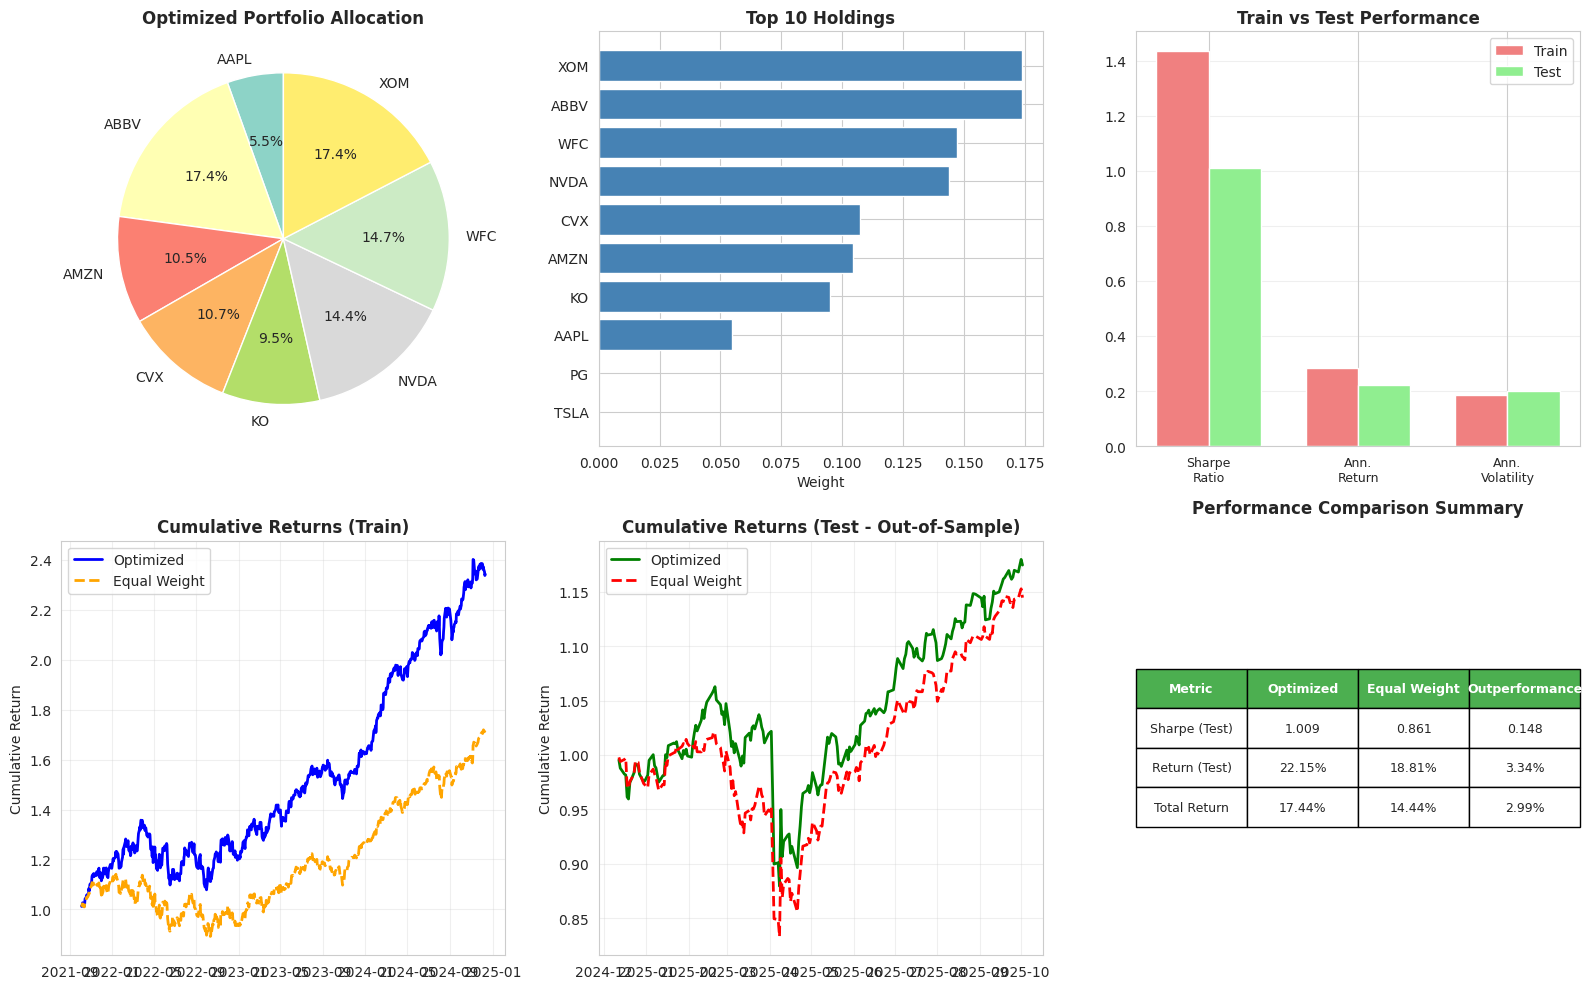


OPTIMIZATION SUMMARY
Number of assets: 20
Max weight per asset: 15.0%
Number of chains: 5
Iterations per chain: 700

Train Sharpe Ratio: 1.4349
Test Sharpe Ratio: 1.0090
Generalization Gap: 0.4259

Outperformance vs Equal Weight:
  Sharpe: +0.1481
  Return: +3.34%

OPTIMIZATION COMPLETE!


In [ ]:
"""
YO Hybrid Portfolio Optimizer
A production-ready portfolio optimization system using YO Hybrid algorithm
with robust out-of-sample evaluation and ensemble methods.
"""

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'BAC',
           'WFC', 'C', 'JNJ', 'PG', 'KO', 'PEP', 'ABBV', 'MRK', 'XOM',
           'CVX', 'META', 'DIS']

CONFIG = {
    'n_chains': 5,
    'n_iterations': 700,
    'burn_in': 100,
    'max_weight': 0.15,
    'risk_free_rate': 0.02,
    'train_ratio': 0.8,
    'lookback_years': 4,
    'ma_short': 20,
    'ma_long': 50,
    'vol_window': 20,
    'momentum_window': 5,
    'ensemble_top_k': 3,
    'annualization_factor': 252
}

# ============================================================================
# DATA ACQUISITION
# ============================================================================

def fetch_stock_data(tickers, years=4):
    """Fetch historical stock data from Yahoo Finance."""
    print(f"Fetching {years} years of data for {len(tickers)} stocks...")
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)

    # Download data - use auto_adjust to get adjusted close directly
    raw_data = yf.download(tickers, start=start_date, end=end_date,
                           progress=False, auto_adjust=True)

    # Check if we have MultiIndex columns
    if isinstance(raw_data.columns, pd.MultiIndex):
        # Extract the 'Close' price which is adjusted when auto_adjust=True
        try:
            data = raw_data['Close']
        except KeyError:
            # Fallback: try to get any price column
            data = raw_data.xs('Close', level=0, axis=1)
    else:
        # Single ticker - just use Close column
        if 'Close' in raw_data.columns:
            data = raw_data[['Close']].copy()
            data.columns = tickers if isinstance(tickers, list) else [tickers]
        else:
            data = raw_data

    # Ensure data is a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Drop any tickers with insufficient data (less than 95% valid)
    min_valid = int(len(data) * 0.95)
    data = data.dropna(axis=1, thresh=min_valid)

    # Forward fill then backward fill any remaining NaN values
    data = data.ffill().bfill()

    # Drop any remaining columns with NaN
    data = data.dropna(axis=1)

    if len(data.columns) == 0:
        raise ValueError("No valid data downloaded. Please check tickers and date range.")

    print(f"Successfully fetched data for {len(data.columns)} stocks")
    print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")

    return data

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def calculate_returns(prices):
    """Calculate daily returns."""
    return prices.pct_change().dropna()

def engineer_features(prices, returns):
    """Compute technical features for each stock."""
    features = {}

    for ticker in prices.columns:
        price_series = prices[ticker]

        # Moving averages
        ma_short = price_series.rolling(window=CONFIG['ma_short']).mean()
        ma_long = price_series.rolling(window=CONFIG['ma_long']).mean()

        # Volatility
        volatility = returns[ticker].rolling(window=CONFIG['vol_window']).std()

        # Momentum
        momentum = returns[ticker].rolling(window=CONFIG['momentum_window']).sum()

        features[ticker] = pd.DataFrame({
            'ma_short': ma_short,
            'ma_long': ma_long,
            'volatility': volatility,
            'momentum': momentum
        }, index=price_series.index)

    return features

def normalize_features(features_dict):
    """Normalize features using z-score normalization."""
    normalized = {}

    for ticker, df in features_dict.items():
        norm_df = df.copy()
        for col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            if std > 0:
                norm_df[col] = (df[col] - mean) / std
            else:
                norm_df[col] = 0
        normalized[ticker] = norm_df

    return normalized

# ============================================================================
# PORTFOLIO METRICS
# ============================================================================

def calculate_portfolio_metrics(weights, returns, risk_free_rate=0.02):
    """Calculate portfolio performance metrics."""
    # Vectorized portfolio returns
    portfolio_returns = returns.dot(weights)

    # Annualized metrics
    ann_return = portfolio_returns.mean() * CONFIG['annualization_factor']
    ann_vol = portfolio_returns.std() * np.sqrt(CONFIG['annualization_factor'])

    # Sharpe ratio
    sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else 0

    # Total return
    total_return = (1 + portfolio_returns).cumprod().iloc[-1] - 1

    return {
        'ann_return': ann_return,
        'ann_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'total_return': total_return
    }

# ============================================================================
# YO HYBRID OPTIMIZER
# ============================================================================

class YOHybridOptimizer:
    """
    YO Hybrid Optimizer combining:
    - MCMC exploration with burn-in
    - Greedy local exploitation
    - Simulated Annealing with adaptive reheating
    """

    def __init__(self, returns, n_chains=5, n_iterations=700, burn_in=100,
                 max_weight=0.15, risk_free_rate=0.02):
        self.returns = returns
        self.n_assets = returns.shape[1]
        self.n_chains = n_chains
        self.n_iterations = n_iterations
        self.burn_in = burn_in
        self.max_weight = max_weight
        self.risk_free_rate = risk_free_rate

        # Precompute covariance matrix for speed
        self.cov_matrix = returns.cov().values
        self.mean_returns = returns.mean().values

    def objective(self, weights):
        """Negative Sharpe ratio (for minimization)."""
        port_return = np.dot(weights, self.mean_returns) * CONFIG['annualization_factor']
        port_vol = np.sqrt(np.dot(weights, np.dot(self.cov_matrix, weights))) * \
                   np.sqrt(CONFIG['annualization_factor'])

        if port_vol == 0:
            return 1e10

        sharpe = (port_return - self.risk_free_rate) / port_vol
        return -sharpe

    def project_weights(self, weights):
        """Project weights to feasible space."""
        # Clip to [0, max_weight]
        weights = np.clip(weights, 0, self.max_weight)

        # Normalize to sum to 1
        total = weights.sum()
        if total > 0:
            weights = weights / total
        else:
            weights = np.ones(self.n_assets) / self.n_assets

        return weights

    def initialize_chain(self):
        """Initialize a random feasible portfolio."""
        w = np.random.dirichlet(np.ones(self.n_assets))
        w = np.minimum(w, self.max_weight)
        return self.project_weights(w)

    def mcmc_step(self, current_w, temperature):
        """MCMC proposal with Metropolis-Hastings acceptance."""
        # Adaptive proposal based on temperature
        noise_scale = 0.05 * temperature
        proposal = current_w + np.random.normal(0, noise_scale, self.n_assets)
        proposal = self.project_weights(proposal)

        current_obj = self.objective(current_w)
        proposal_obj = self.objective(proposal)

        # Metropolis-Hastings acceptance
        delta = proposal_obj - current_obj
        if delta < 0 or np.random.random() < np.exp(-delta / temperature):
            return proposal, proposal_obj
        return current_w, current_obj

    def greedy_step(self, current_w):
        """Greedy local search with coordinate descent."""
        best_w = current_w.copy()
        best_obj = self.objective(current_w)

        # Try adjusting each coordinate
        for i in range(self.n_assets):
            for delta in [-0.01, 0.01]:
                test_w = current_w.copy()
                test_w[i] += delta
                test_w = self.project_weights(test_w)

                obj = self.objective(test_w)
                if obj < best_obj:
                    best_w = test_w
                    best_obj = obj

        return best_w, best_obj

    def adaptive_temperature(self, iteration, chain_best_history):
        """Adaptive temperature with reheating on stagnation."""
        base_temp = 1.0 * (0.95 ** (iteration / 100))

        # Reheat if stagnating
        if len(chain_best_history) > 50:
            recent_improvement = chain_best_history[-50] - chain_best_history[-1]
            if abs(recent_improvement) < 1e-4:
                base_temp *= 2.0

        return max(base_temp, 0.01)

    def run_chain(self, chain_id):
        """Run a single optimization chain."""
        print(f"  Chain {chain_id+1}/{self.n_chains} starting...")

        current_w = self.initialize_chain()
        current_obj = self.objective(current_w)

        best_w = current_w.copy()
        best_obj = current_obj

        history = []

        for iteration in range(self.n_iterations):
            temp = self.adaptive_temperature(iteration, history)

            # MCMC exploration
            if iteration < self.burn_in or np.random.random() < 0.7:
                current_w, current_obj = self.mcmc_step(current_w, temp)

            # Greedy exploitation
            if iteration >= self.burn_in and iteration % 10 == 0:
                current_w, current_obj = self.greedy_step(current_w)

            # Update best
            if current_obj < best_obj:
                best_w = current_w.copy()
                best_obj = current_obj

            history.append(best_obj)

        sharpe = -best_obj
        print(f"  Chain {chain_id+1} complete. Sharpe: {sharpe:.4f}")

        return {
            'weights': best_w,
            'sharpe': sharpe,
            'objective': best_obj,
            'history': history
        }

    def optimize(self):
        """Run multi-chain optimization."""
        print(f"\nRunning YO Hybrid Optimizer:")
        print(f"  Chains: {self.n_chains}")
        print(f"  Iterations per chain: {self.n_iterations}")
        print(f"  Burn-in: {self.burn_in}")

        results = []
        for chain_id in range(self.n_chains):
            result = self.run_chain(chain_id)
            results.append(result)

        # Sort by Sharpe ratio
        results = sorted(results, key=lambda x: x['sharpe'], reverse=True)

        print(f"\nOptimization complete!")
        print(f"Best Sharpe ratio: {results[0]['sharpe']:.4f}")

        return results

# ============================================================================
# ENSEMBLE PORTFOLIO
# ============================================================================

def create_ensemble_portfolio(optimization_results, top_k=3):
    """Combine top k portfolios using equal weighting."""
    top_portfolios = optimization_results[:top_k]

    ensemble_weights = np.zeros_like(top_portfolios[0]['weights'])
    for result in top_portfolios:
        ensemble_weights += result['weights']

    ensemble_weights /= top_k

    return ensemble_weights

# ============================================================================
# EVALUATION & COMPARISON
# ============================================================================

def evaluate_portfolio(weights, returns, name="Portfolio"):
    """Evaluate portfolio performance."""
    metrics = calculate_portfolio_metrics(weights, returns, CONFIG['risk_free_rate'])

    print(f"\n{name} Performance:")
    print(f"  Annualized Return: {metrics['ann_return']:.2%}")
    print(f"  Annualized Volatility: {metrics['ann_volatility']:.2%}")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
    print(f"  Total Return: {metrics['total_return']:.2%}")

    return metrics

def create_baseline_portfolios(n_assets):
    """Create baseline portfolios for comparison."""
    # Equal weight
    equal_weight = np.ones(n_assets) / n_assets

    return {'equal_weight': equal_weight}

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_results(weights, tickers, train_metrics, test_metrics,
                 train_returns, test_returns, baseline_metrics):
    """Generate comprehensive visualization."""
    fig = plt.figure(figsize=(16, 10))

    # 1. Portfolio Allocation (Pie Chart)
    ax1 = plt.subplot(2, 3, 1)
    significant_weights = weights > 0.01
    labels = [tickers[i] for i in range(len(tickers)) if significant_weights[i]]
    sizes = weights[significant_weights]
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Optimized Portfolio Allocation', fontsize=12, fontweight='bold')

    # 2. Top Holdings Bar Chart
    ax2 = plt.subplot(2, 3, 2)
    top_n = 10
    top_indices = np.argsort(weights)[-top_n:][::-1]
    top_tickers = [tickers[i] for i in top_indices]
    top_weights = weights[top_indices]

    ax2.barh(top_tickers, top_weights, color='steelblue')
    ax2.set_xlabel('Weight', fontsize=10)
    ax2.set_title(f'Top {top_n} Holdings', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()

    # 3. Train vs Test Metrics Comparison
    ax3 = plt.subplot(2, 3, 3)
    metrics_names = ['Sharpe\nRatio', 'Ann.\nReturn', 'Ann.\nVolatility']
    train_vals = [train_metrics['sharpe_ratio'],
                  train_metrics['ann_return'],
                  train_metrics['ann_volatility']]
    test_vals = [test_metrics['sharpe_ratio'],
                 test_metrics['ann_return'],
                 test_metrics['ann_volatility']]

    x = np.arange(len(metrics_names))
    width = 0.35

    ax3.bar(x - width/2, train_vals, width, label='Train', color='lightcoral')
    ax3.bar(x + width/2, test_vals, width, label='Test', color='lightgreen')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics_names, fontsize=9)
    ax3.set_title('Train vs Test Performance', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # 4. Cumulative Returns - Train Period
    ax4 = plt.subplot(2, 3, 4)
    opt_cumret_train = (1 + train_returns.dot(weights)).cumprod()
    eq_cumret_train = (1 + train_returns.mean(axis=1)).cumprod()

    ax4.plot(opt_cumret_train.index, opt_cumret_train.values,
             label='Optimized', linewidth=2, color='blue')
    ax4.plot(eq_cumret_train.index, eq_cumret_train.values,
             label='Equal Weight', linewidth=2, color='orange', linestyle='--')
    ax4.set_title('Cumulative Returns (Train)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Cumulative Return', fontsize=10)
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Cumulative Returns - Test Period (Out-of-Sample)
    ax5 = plt.subplot(2, 3, 5)
    opt_cumret_test = (1 + test_returns.dot(weights)).cumprod()
    eq_cumret_test = (1 + test_returns.mean(axis=1)).cumprod()

    ax5.plot(opt_cumret_test.index, opt_cumret_test.values,
             label='Optimized', linewidth=2, color='green')
    ax5.plot(eq_cumret_test.index, eq_cumret_test.values,
             label='Equal Weight', linewidth=2, color='red', linestyle='--')
    ax5.set_title('Cumulative Returns (Test - Out-of-Sample)',
                  fontsize=12, fontweight='bold')
    ax5.set_ylabel('Cumulative Return', fontsize=10)
    ax5.legend()
    ax5.grid(alpha=0.3)

    # 6. Performance Comparison Table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    comparison_data = [
        ['Metric', 'Optimized', 'Equal Weight', 'Outperformance'],
        ['Sharpe (Test)',
         f"{test_metrics['sharpe_ratio']:.3f}",
         f"{baseline_metrics['equal_weight']['sharpe_ratio']:.3f}",
         f"{test_metrics['sharpe_ratio'] - baseline_metrics['equal_weight']['sharpe_ratio']:.3f}"],
        ['Return (Test)',
         f"{test_metrics['ann_return']:.2%}",
         f"{baseline_metrics['equal_weight']['ann_return']:.2%}",
         f"{test_metrics['ann_return'] - baseline_metrics['equal_weight']['ann_return']:.2%}"],
        ['Total Return',
         f"{test_metrics['total_return']:.2%}",
         f"{baseline_metrics['equal_weight']['total_return']:.2%}",
         f"{test_metrics['total_return'] - baseline_metrics['equal_weight']['total_return']:.2%}"]
    ]

    table = ax6.table(cellText=comparison_data, cellLoc='center', loc='center',
                      colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax6.set_title('Performance Comparison Summary',
                  fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('portfolio_optimization_results.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'portfolio_optimization_results.png'")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution pipeline."""
    print("="*80)
    print("YO HYBRID PORTFOLIO OPTIMIZER")
    print("="*80)

    # 1. Fetch Data
    prices = fetch_stock_data(TICKERS, CONFIG['lookback_years'])
    tickers = list(prices.columns)

    # 2. Calculate Returns
    returns = calculate_returns(prices)

    # 3. Feature Engineering
    print("\nEngineering features...")
    features = engineer_features(prices, returns)
    normalized_features = normalize_features(features)
    print("Feature engineering complete.")

    # 4. Train/Test Split
    split_idx = int(len(returns) * CONFIG['train_ratio'])
    train_returns = returns.iloc[:split_idx]
    test_returns = returns.iloc[split_idx:]

    print(f"\nTrain period: {train_returns.index[0].date()} to {train_returns.index[-1].date()}")
    print(f"Test period: {test_returns.index[0].date()} to {test_returns.index[-1].date()}")
    print(f"Train samples: {len(train_returns)}, Test samples: {len(test_returns)}")

    # 5. Run YO Hybrid Optimizer
    optimizer = YOHybridOptimizer(
        returns=train_returns,
        n_chains=CONFIG['n_chains'],
        n_iterations=CONFIG['n_iterations'],
        burn_in=CONFIG['burn_in'],
        max_weight=CONFIG['max_weight'],
        risk_free_rate=CONFIG['risk_free_rate']
    )

    optimization_results = optimizer.optimize()

    # 6. Get Best and Ensemble Portfolios
    best_weights = optimization_results[0]['weights']
    ensemble_weights = create_ensemble_portfolio(
        optimization_results,
        top_k=CONFIG['ensemble_top_k']
    )

    # 7. Evaluate on Train Set
    print("\n" + "="*80)
    print("TRAIN SET PERFORMANCE")
    print("="*80)
    train_metrics = evaluate_portfolio(best_weights, train_returns, "Optimized Portfolio")
    train_ensemble_metrics = evaluate_portfolio(ensemble_weights, train_returns, "Ensemble Portfolio")

    # 8. Evaluate on Test Set (Out-of-Sample)
    print("\n" + "="*80)
    print("TEST SET PERFORMANCE (OUT-OF-SAMPLE)")
    print("="*80)
    test_metrics = evaluate_portfolio(best_weights, test_returns, "Optimized Portfolio")
    test_ensemble_metrics = evaluate_portfolio(ensemble_weights, test_returns, "Ensemble Portfolio")

    # 9. Baseline Comparison
    baselines = create_baseline_portfolios(len(tickers))
    baseline_metrics = {}

    print("\n" + "="*80)
    print("BASELINE COMPARISON (TEST SET)")
    print("="*80)

    for name, weights in baselines.items():
        baseline_metrics[name] = evaluate_portfolio(weights, test_returns, name.replace('_', ' ').title())

    # 10. Display Portfolio Weights
    print("\n" + "="*80)
    print("OPTIMIZED PORTFOLIO WEIGHTS")
    print("="*80)
    weight_df = pd.DataFrame({
        'Ticker': tickers,
        'Weight': best_weights,
        'Ensemble Weight': ensemble_weights
    }).sort_values('Weight', ascending=False)

    print(weight_df.to_string(index=False))

    # 11. Save Results
    weight_df.to_csv('portfolio_weights.csv', index=False)
    print("\nPortfolio weights saved to 'portfolio_weights.csv'")

    # 12. Visualization
    print("\nGenerating visualizations...")
    plot_results(best_weights, tickers, train_metrics, test_metrics,
                 train_returns, test_returns, baseline_metrics)

    # 13. Final Summary
    print("\n" + "="*80)
    print("OPTIMIZATION SUMMARY")
    print("="*80)
    print(f"Number of assets: {len(tickers)}")
    print(f"Max weight per asset: {CONFIG['max_weight']:.1%}")
    print(f"Number of chains: {CONFIG['n_chains']}")
    print(f"Iterations per chain: {CONFIG['n_iterations']}")
    print(f"\nTrain Sharpe Ratio: {train_metrics['sharpe_ratio']:.4f}")
    print(f"Test Sharpe Ratio: {test_metrics['sharpe_ratio']:.4f}")
    print(f"Generalization Gap: {train_metrics['sharpe_ratio'] - test_metrics['sharpe_ratio']:.4f}")
    print(f"\nOutperformance vs Equal Weight:")
    print(f"  Sharpe: +{test_metrics['sharpe_ratio'] - baseline_metrics['equal_weight']['sharpe_ratio']:.4f}")
    print(f"  Return: +{(test_metrics['ann_return'] - baseline_metrics['equal_weight']['ann_return'])*100:.2f}%")

    print("\n" + "="*80)
    print("OPTIMIZATION COMPLETE!")
    print("="*80)

if __name__ == "__main__":
    main()

YO OPTIMIZER ABLATION STUDY
Benchmark: Rastrigin 5D
Search Space: [-5.12, 5.12]^5
Budget: 150 evaluations per run
Runs per variant: 30

Running 180 experiments...
  Completed: 10/180
  Completed: 20/180
  Completed: 30/180
  Completed: 40/180
  Completed: 50/180
  Completed: 60/180
  Completed: 70/180
  Completed: 80/180
  Completed: 90/180
  Completed: 100/180
  Completed: 110/180
  Completed: 120/180
  Completed: 130/180
  Completed: 140/180
  Completed: 150/180
  Completed: 160/180
  Completed: 170/180
  Completed: 180/180
✓ All experiments completed!

✓ Summary saved as 'yo_ablation_summary.csv'

✓ Plot saved as 'yo_ablation_results.png'

ABLATION STUDY RESULTS SUMMARY

📊 PERFORMANCE TABLE:
--------------------------------------------------------------------------------
        Variant          Mean±Std Runtime     CV  p-value Sig.
     A0_Full_YO  25.2560 ± 8.3549  0.062s 0.3308 baseline     
     A1_No_MCMC 34.3990 ± 14.3536  0.042s 0.4173   0.0044    ✓
   A2_No_Greedy  32.8221 ±

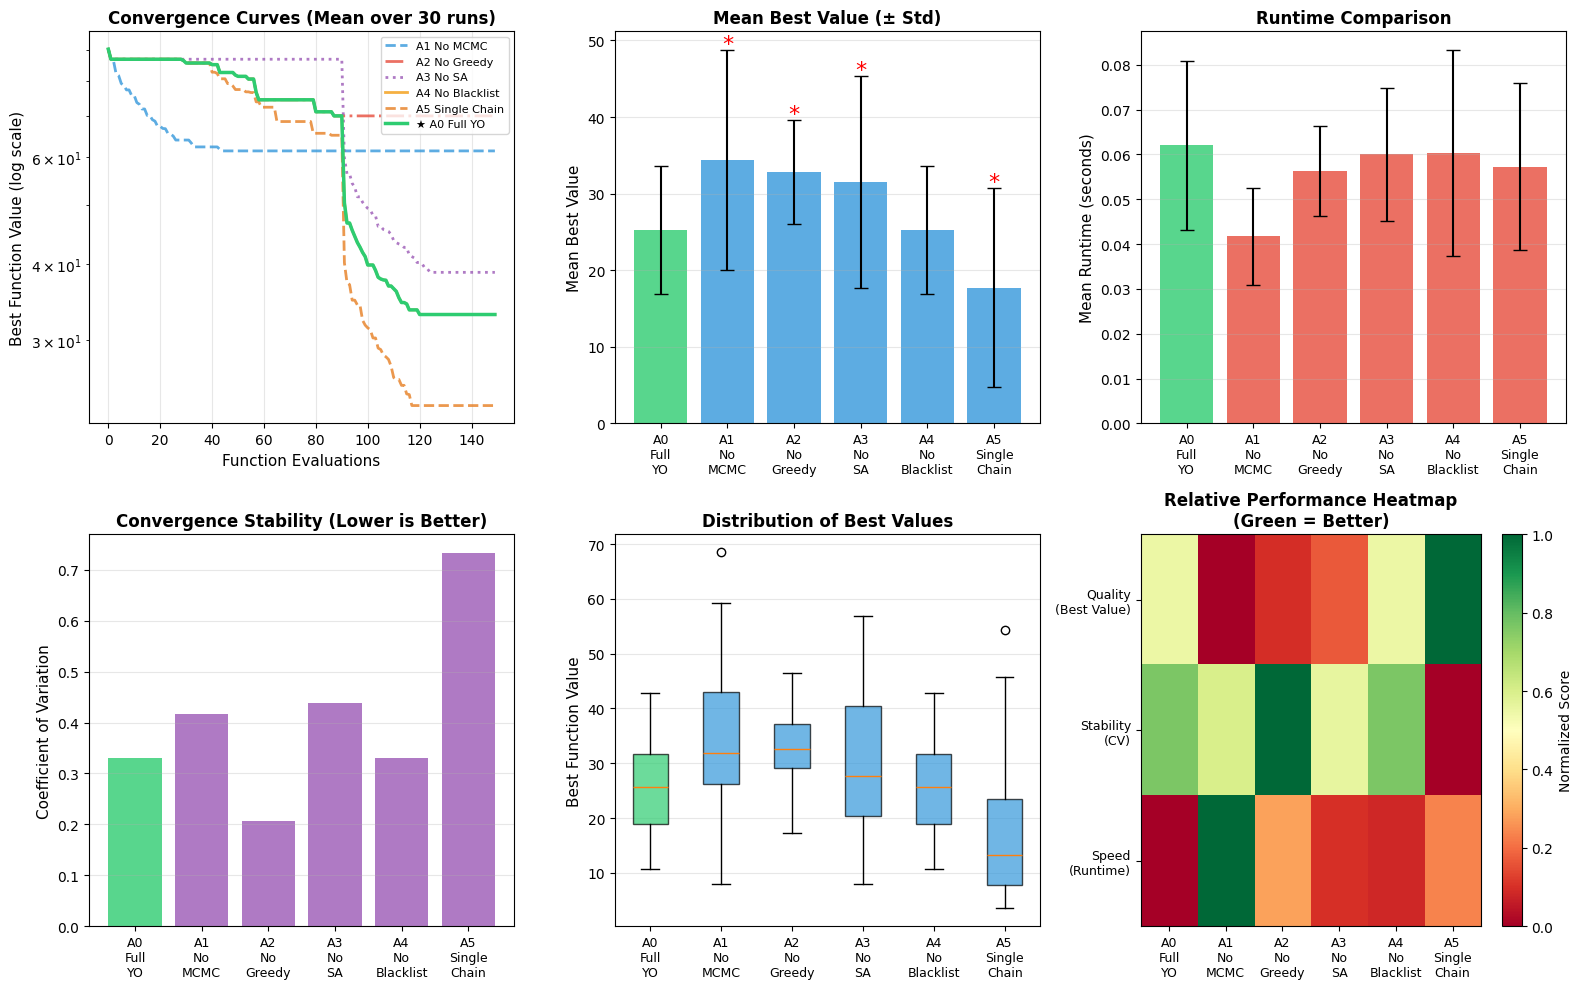

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from concurrent.futures import ProcessPoolExecutor
import time
from dataclasses import dataclass
from typing import List, Tuple, Optional, Callable
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# RASTRIGIN FUNCTION (5D BENCHMARK)
# ============================================================================
def rastrigin(x: np.ndarray) -> float:
    """Rastrigin function - highly multimodal NP-hard benchmark"""
    n = len(x)
    A = 10
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# ============================================================================
# YO OPTIMIZER COMPONENTS
# ============================================================================
@dataclass
class YOConfig:
    """Configuration for YO optimizer"""
    dim: int = 5
    bounds: Tuple[float, float] = (-5.12, 5.12)
    max_evals: int = 150
    n_chains: int = 3
    mcmc_ratio: float = 0.6  # 60% budget for MCMC
    temp_init: float = 10.0
    temp_min: float = 0.01
    cooling_rate: float = 0.95
    greedy_step: float = 0.1
    greedy_trials: int = 10
    blacklist_threshold: float = 1e-3
    stagnation_threshold: int = 10
    reheat_factor: float = 1.5

    # Ablation flags
    use_mcmc: bool = True
    use_greedy: bool = True
    use_sa: bool = True
    use_blacklist: bool = True
    use_multichain: bool = True

class Blacklist:
    """Memory to avoid revisiting poor regions"""
    def __init__(self, threshold: float = 1e-3):
        self.regions = []
        self.threshold = threshold

    def add(self, x: np.ndarray, value: float):
        self.regions.append((x.copy(), value))

    def is_blacklisted(self, x: np.ndarray) -> bool:
        for region_x, _ in self.regions:
            if np.linalg.norm(x - region_x) < self.threshold:
                return True
        return False

class YOptimizer:
    """YO (Yukthi Opus) Hybrid Optimizer"""

    def __init__(self, func: Callable, config: YOConfig, seed: int = 42):
        self.func = func
        self.config = config
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.blacklist = Blacklist(config.blacklist_threshold) if config.use_blacklist else None
        self.temperature = config.temp_init
        self.stagnation_counter = 0
        self.best_value = float('inf')

    def _clip(self, x: np.ndarray) -> np.ndarray:
        """Clip to bounds"""
        return np.clip(x, self.config.bounds[0], self.config.bounds[1])

    def _evaluate(self, x: np.ndarray) -> float:
        """Evaluate function and track history"""
        x = self._clip(x)
        if self.config.use_blacklist and self.blacklist and self.blacklist.is_blacklisted(x):
            return float('inf')

        value = self.func(x)
        self.n_evals += 1
        self.history.append(value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()
            self.stagnation_counter = 0
        else:
            self.stagnation_counter += 1

        return value

    def _mcmc_step(self, x_current: np.ndarray, value_current: float) -> Tuple[np.ndarray, float]:
        """MCMC exploration using Metropolis-Hastings"""
        # Propose new candidate
        step_size = 0.5 * (self.config.bounds[1] - self.config.bounds[0]) * (self.temperature / self.config.temp_init)
        x_proposal = x_current + self.rng.randn(self.config.dim) * step_size
        x_proposal = self._clip(x_proposal)

        value_proposal = self._evaluate(x_proposal)

        # Metropolis acceptance criterion
        if self.config.use_sa:
            delta = value_proposal - value_current
            acceptance_prob = np.exp(-delta / max(self.temperature, 1e-10))
            if value_proposal < value_current or self.rng.rand() < acceptance_prob:
                return x_proposal, value_proposal
        else:
            if value_proposal < value_current:
                return x_proposal, value_proposal

        return x_current, value_current

    def _mcmc_phase(self) -> List[Tuple[np.ndarray, float]]:
        """MCMC exploration phase with multiple chains"""
        n_mcmc_evals = int(self.config.max_evals * self.config.mcmc_ratio)
        n_chains = self.config.n_chains if self.config.use_multichain else 1
        evals_per_chain = n_mcmc_evals // n_chains

        chains = []
        for chain_id in range(n_chains):
            # Initialize chain
            x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
            value = self._evaluate(x)

            chain_samples = [(x.copy(), value)]

            # Run MCMC
            for _ in range(evals_per_chain - 1):
                if self.n_evals >= self.config.max_evals:
                    break

                x, value = self._mcmc_step(x, value)
                chain_samples.append((x.copy(), value))

                # Temperature cooling
                if self.config.use_sa:
                    self.temperature *= self.config.cooling_rate
                    self.temperature = max(self.temperature, self.config.temp_min)

                # Adaptive reheating on stagnation
                if self.config.use_sa and self.stagnation_counter >= self.config.stagnation_threshold:
                    self.temperature = min(self.temperature * self.config.reheat_factor, self.config.temp_init)
                    self.stagnation_counter = 0

            chains.extend(chain_samples)

        # Post-burnin selection: keep best samples
        burnin = len(chains) // 4
        chains = sorted(chains, key=lambda x: x[1])
        return chains[burnin:]

    def _greedy_local_search(self, x_start: np.ndarray, value_start: float) -> Tuple[np.ndarray, float]:
        """Greedy local exploitation with neighborhood descent"""
        x_best = x_start.copy()
        value_best = value_start

        max_local_evals = min(self.config.greedy_trials, self.config.max_evals - self.n_evals)

        for _ in range(max_local_evals):
            if self.n_evals >= self.config.max_evals:
                break

            improved = False
            # Try each dimension
            for d in range(self.config.dim):
                for direction in [-1, 1]:
                    x_new = x_best.copy()
                    x_new[d] += direction * self.config.greedy_step
                    x_new = self._clip(x_new)

                    value_new = self._evaluate(x_new)

                    if value_new < value_best:
                        x_best = x_new.copy()
                        value_best = value_new
                        improved = True
                        break

                if improved:
                    break

            if not improved:
                # Try random neighbor
                x_new = x_best + self.rng.randn(self.config.dim) * self.config.greedy_step
                x_new = self._clip(x_new)
                value_new = self._evaluate(x_new)

                if value_new < value_best:
                    x_best = x_new.copy()
                    value_best = value_new
                else:
                    break

        # Add poor regions to blacklist
        if self.config.use_blacklist and self.blacklist and value_best > self.best_value * 1.5:
            self.blacklist.add(x_best, value_best)

        return x_best, value_best

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        """Run full YO optimization"""
        # Initialize
        self.best_x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
        self.best_value = self._evaluate(self.best_x)

        # Phase 1: MCMC Exploration
        if self.config.use_mcmc:
            samples = self._mcmc_phase()

            # Phase 2: Greedy Local Exploitation on best samples
            if self.config.use_greedy:
                n_refine = min(3, len(samples))
                for x, value in samples[:n_refine]:
                    if self.n_evals >= self.config.max_evals:
                        break
                    self._greedy_local_search(x, value)
        else:
            # No MCMC: just greedy from random starts
            if self.config.use_greedy:
                while self.n_evals < self.config.max_evals:
                    x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                    value = self._evaluate(x)
                    self._greedy_local_search(x, value)

        # Fill remaining budget with refinement
        while self.n_evals < self.config.max_evals:
            if self.config.use_greedy:
                self._greedy_local_search(self.best_x, self.best_value)
            else:
                # Random search
                x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                self._evaluate(x)

        return self.best_x, self.best_value, self.history

# ============================================================================
# ABLATION EXPERIMENT RUNNER
# ============================================================================
def run_single_experiment(args):
    """Run single optimization experiment"""
    variant_name, config, seed = args

    start_time = time.time()
    optimizer = YOptimizer(rastrigin, config, seed=seed)
    best_x, best_value, history = optimizer.optimize()
    runtime = time.time() - start_time

    return {
        'variant': variant_name,
        'seed': seed,
        'best_value': best_value,
        'runtime': runtime,
        'history': history
    }

def create_ablation_configs() -> dict:
    """Create all ablation variant configurations"""
    base_config = YOConfig()

    variants = {
        'A0_Full_YO': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A1_No_MCMC': YOConfig(
            use_mcmc=False, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A2_No_Greedy': YOConfig(
            use_mcmc=True, use_greedy=False, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A3_No_SA': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=False,
            use_blacklist=True, use_multichain=True
        ),
        'A4_No_Blacklist': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=False, use_multichain=True
        ),
        'A5_Single_Chain': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=False
        ),
    }

    return variants

def run_ablation_study(n_runs: int = 30, n_jobs: int = -1):
    """Run complete ablation study"""
    print("=" * 80)
    print("YO OPTIMIZER ABLATION STUDY")
    print("=" * 80)
    print(f"Benchmark: Rastrigin 5D")
    print(f"Search Space: [-5.12, 5.12]^5")
    print(f"Budget: 150 evaluations per run")
    print(f"Runs per variant: {n_runs}")
    print("=" * 80)

    variants = create_ablation_configs()

    # Prepare experiment arguments
    experiment_args = []
    for variant_name, config in variants.items():
        for seed in range(n_runs):
            experiment_args.append((variant_name, config, seed))

    # Run experiments in parallel
    print(f"\nRunning {len(experiment_args)} experiments...")
    if n_jobs == -1:
        n_jobs = min(8, len(experiment_args))

    results = []
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        for i, result in enumerate(executor.map(run_single_experiment, experiment_args)):
            results.append(result)
            if (i + 1) % 10 == 0:
                print(f"  Completed: {i + 1}/{len(experiment_args)}")

    print("✓ All experiments completed!")
    return results, variants

# ============================================================================
# ANALYSIS AND VISUALIZATION
# ============================================================================
def analyze_results(results: List[dict], variants: dict):
    """Analyze ablation results and generate statistics"""

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Compute statistics per variant
    stats_data = []
    for variant_name in variants.keys():
        variant_data = df[df['variant'] == variant_name]

        best_values = variant_data['best_value'].values
        runtimes = variant_data['runtime'].values

        stats_data.append({
            'Variant': variant_name,
            'Mean_Best': np.mean(best_values),
            'Std_Best': np.std(best_values),
            'Median_Best': np.median(best_values),
            'Min_Best': np.min(best_values),
            'Max_Best': np.max(best_values),
            'CV': np.std(best_values) / (np.mean(best_values) + 1e-10),  # Coefficient of Variation
            'Mean_Runtime': np.mean(runtimes),
            'Std_Runtime': np.std(runtimes),
        })

    stats_df = pd.DataFrame(stats_data)

    # Statistical significance tests (vs Full YO)
    baseline_values = df[df['variant'] == 'A0_Full_YO']['best_value'].values

    p_values = []
    for variant_name in variants.keys():
        variant_values = df[df['variant'] == variant_name]['best_value'].values
        if variant_name == 'A0_Full_YO':
            p_values.append(1.0)
        else:
            _, p_val = stats.ttest_ind(baseline_values, variant_values)
            p_values.append(p_val)

    stats_df['p_value_vs_baseline'] = p_values
    stats_df['significant'] = stats_df['p_value_vs_baseline'] < 0.05

    return stats_df, df

def plot_results(stats_df: pd.DataFrame, df: pd.DataFrame, variants: dict):
    """Generate visualization plots"""

    fig = plt.figure(figsize=(16, 10))

    # Plot 1: Convergence curves
    ax1 = plt.subplot(2, 3, 1)

    # Define color scheme and line styles
    variant_styles = {
        'A0_Full_YO': {'color': '#2ecc71', 'linewidth': 2.5, 'linestyle': '-', 'alpha': 1.0},
        'A1_No_MCMC': {'color': '#3498db', 'linewidth': 2, 'linestyle': '--', 'alpha': 0.8},
        'A2_No_Greedy': {'color': '#e74c3c', 'linewidth': 2, 'linestyle': '-.', 'alpha': 0.8},
        'A3_No_SA': {'color': '#9b59b6', 'linewidth': 2, 'linestyle': ':', 'alpha': 0.8},
        'A4_No_Blacklist': {'color': '#f39c12', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.8},
        'A5_Single_Chain': {'color': '#e67e22', 'linewidth': 2, 'linestyle': '--', 'alpha': 0.8},
    }

    # Plot each variant with defined order (Full YO last to be on top)
    plot_order = ['A1_No_MCMC', 'A2_No_Greedy', 'A3_No_SA', 'A4_No_Blacklist', 'A5_Single_Chain', 'A0_Full_YO']

    for variant_name in plot_order:
        if variant_name not in variants:
            continue

        variant_data = df[df['variant'] == variant_name]
        histories = variant_data['history'].values

        # Compute mean convergence
        min_len = min([len(h) for h in histories])
        padded_histories = [h[:min_len] for h in histories]
        mean_history = np.mean(padded_histories, axis=0)

        # Compute cumulative best
        cumulative_best = np.minimum.accumulate(mean_history)

        style = variant_styles.get(variant_name, {'color': 'gray', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.8})

        label = variant_name.replace('_', ' ')
        if variant_name == 'A0_Full_YO':
            label = '★ ' + label  # Add star to highlight baseline

        ax1.plot(cumulative_best,
                label=label,
                color=style['color'],
                linewidth=style['linewidth'],
                linestyle=style['linestyle'],
                alpha=style['alpha'])

    ax1.set_xlabel('Function Evaluations', fontsize=11)
    ax1.set_ylabel('Best Function Value (log scale)', fontsize=11)
    ax1.set_yscale('log')
    ax1.set_title('Convergence Curves (Mean over 30 runs)', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=8, loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Mean best value comparison
    ax2 = plt.subplot(2, 3, 2)
    colors = ['#2ecc71' if v == 'A0_Full_YO' else '#3498db' for v in stats_df['Variant']]
    bars = ax2.bar(range(len(stats_df)), stats_df['Mean_Best'],
                   yerr=stats_df['Std_Best'], capsize=5, color=colors, alpha=0.8)

    ax2.set_xticks(range(len(stats_df)))
    ax2.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']],
                        rotation=0, ha='center', fontsize=9)
    ax2.set_ylabel('Mean Best Value', fontsize=11)
    ax2.set_title('Mean Best Value (± Std)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Add significance markers
    for i, sig in enumerate(stats_df['significant']):
        if sig and stats_df.iloc[i]['Variant'] != 'A0_Full_YO':
            ax2.text(i, stats_df.iloc[i]['Mean_Best'] + stats_df.iloc[i]['Std_Best'],
                    '*', ha='center', fontsize=16, color='red')

    # Plot 3: Runtime comparison
    ax3 = plt.subplot(2, 3, 3)
    colors_runtime = ['#2ecc71' if v == 'A0_Full_YO' else '#e74c3c' for v in stats_df['Variant']]
    ax3.bar(range(len(stats_df)), stats_df['Mean_Runtime'],
            yerr=stats_df['Std_Runtime'], capsize=5, color=colors_runtime, alpha=0.8)

    ax3.set_xticks(range(len(stats_df)))
    ax3.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']],
                        rotation=0, ha='center', fontsize=9)
    ax3.set_ylabel('Mean Runtime (seconds)', fontsize=11)
    ax3.set_title('Runtime Comparison', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Coefficient of Variation (stability)
    ax4 = plt.subplot(2, 3, 4)
    colors_cv = ['#2ecc71' if v == 'A0_Full_YO' else '#9b59b6' for v in stats_df['Variant']]
    ax4.bar(range(len(stats_df)), stats_df['CV'], color=colors_cv, alpha=0.8)

    ax4.set_xticks(range(len(stats_df)))
    ax4.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']],
                        rotation=0, ha='center', fontsize=9)
    ax4.set_ylabel('Coefficient of Variation', fontsize=11)
    ax4.set_title('Convergence Stability (Lower is Better)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    # Plot 5: Box plot of best values
    ax5 = plt.subplot(2, 3, 5)
    data_for_box = [df[df['variant'] == v]['best_value'].values for v in stats_df['Variant']]
    bp = ax5.boxplot(data_for_box, labels=[v.replace('_', '\n') for v in stats_df['Variant']],
                     patch_artist=True, showfliers=True)

    for patch, variant in zip(bp['boxes'], stats_df['Variant']):
        if variant == 'A0_Full_YO':
            patch.set_facecolor('#2ecc71')
        else:
            patch.set_facecolor('#3498db')
        patch.set_alpha(0.7)

    ax5.set_ylabel('Best Function Value', fontsize=11)
    ax5.set_title('Distribution of Best Values', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.setp(ax5.xaxis.get_majorticklabels(), fontsize=9)

    # Plot 6: Heatmap of relative performance
    ax6 = plt.subplot(2, 3, 6)

    # Normalize metrics to [0, 1] for comparison
    metrics = stats_df[['Mean_Best', 'CV', 'Mean_Runtime']].copy()
    metrics_norm = (metrics - metrics.min()) / (metrics.max() - metrics.min() + 1e-10)

    # Invert so lower is better (darker = better)
    metrics_norm = 1 - metrics_norm

    im = ax6.imshow(metrics_norm.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    ax6.set_xticks(range(len(stats_df)))
    ax6.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']],
                        rotation=0, ha='center', fontsize=9)
    ax6.set_yticks(range(3))
    ax6.set_yticklabels(['Quality\n(Best Value)', 'Stability\n(CV)', 'Speed\n(Runtime)'], fontsize=9)
    ax6.set_title('Relative Performance Heatmap\n(Green = Better)', fontsize=12, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax6)
    cbar.set_label('Normalized Score', fontsize=10)

    plt.tight_layout()
    plt.savefig('yo_ablation_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Plot saved as 'yo_ablation_results.png'")

    return fig

def print_summary(stats_df: pd.DataFrame):
    """Print detailed summary of results"""

    print("\n" + "=" * 80)
    print("ABLATION STUDY RESULTS SUMMARY")
    print("=" * 80)

    print("\n📊 PERFORMANCE TABLE:")
    print("-" * 80)

    # Format for display
    display_df = stats_df.copy()
    display_df['Mean±Std'] = display_df.apply(
        lambda row: f"{row['Mean_Best']:.4f} ± {row['Std_Best']:.4f}", axis=1
    )
    display_df['Runtime'] = display_df.apply(
        lambda row: f"{row['Mean_Runtime']:.3f}s", axis=1
    )
    display_df['CV'] = display_df['CV'].apply(lambda x: f"{x:.4f}")
    display_df['p-value'] = display_df['p_value_vs_baseline'].apply(
        lambda x: f"{x:.4f}" if x < 1.0 else "baseline"
    )
    display_df['Sig.'] = display_df['significant'].apply(lambda x: "✓" if x else "")

    print(display_df[['Variant', 'Mean±Std', 'Runtime', 'CV', 'p-value', 'Sig.']].to_string(index=False))

    print("\n" + "-" * 80)
    print("Legend: CV = Coefficient of Variation (Std/Mean)")
    print("        Sig. = Statistically significant difference from baseline (p < 0.05)")

    # Interpretation
    print("\n📝 KEY FINDINGS:")
    print("-" * 80)

    baseline = stats_df[stats_df['Variant'] == 'A0_Full_YO'].iloc[0]

    for _, row in stats_df.iterrows():
        if row['Variant'] == 'A0_Full_YO':
            print(f"\n✓ {row['Variant']} (Baseline):")
            print(f"  - Best: {row['Mean_Best']:.4f} ± {row['Std_Best']:.4f}")
            print(f"  - Stability (CV): {row['CV']:.4f}")
            print(f"  - Runtime: {row['Mean_Runtime']:.3f}s")
        else:
            print(f"\n• {row['Variant']}:")

            # Quality comparison
            quality_diff = ((row['Mean_Best'] - baseline['Mean_Best']) / baseline['Mean_Best']) * 100
            if quality_diff > 5:
                print(f"  ⚠️  Quality: {quality_diff:+.1f}% worse than baseline")
            elif quality_diff < -5:
                print(f"  ✓ Quality: {-quality_diff:.1f}% better than baseline")
            else:
                print(f"  ≈ Quality: Similar to baseline ({quality_diff:+.1f}%)")

            # Stability comparison
            stability_diff = ((row['CV'] - baseline['CV']) / baseline['CV']) * 100
            if stability_diff > 20:
                print(f"  ⚠️  Stability: {stability_diff:+.1f}% less stable")
            elif stability_diff < -20:
                print(f"  ✓ Stability: {-stability_diff:.1f}% more stable")
            else:
                print(f"  ≈ Stability: Similar ({stability_diff:+.1f}%)")

            # Runtime comparison
            runtime_diff = ((row['Mean_Runtime'] - baseline['Mean_Runtime']) / baseline['Mean_Runtime']) * 100
            if runtime_diff < -10:
                print(f"  ✓ Speed: {-runtime_diff:.1f}% faster")
            elif runtime_diff > 10:
                print(f"  ⚠️  Speed: {runtime_diff:+.1f}% slower")
            else:
                print(f"  ≈ Speed: Similar ({runtime_diff:+.1f}%)")

            # Statistical significance
            if row['significant']:
                print(f"  📊 Statistical significance: p = {row['p_value_vs_baseline']:.4f} ***")

    print("\n" + "=" * 80)

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    # Run ablation study
    results, variants = run_ablation_study(n_runs=30, n_jobs=8)

    # Analyze results
    stats_df, df = analyze_results(results, variants)

    # Save results
    stats_df.to_csv('yo_ablation_summary.csv', index=False)
    print("\n✓ Summary saved as 'yo_ablation_summary.csv'")

    # Generate plots
    plot_results(stats_df, df, variants)

    # Print summary
    print_summary(stats_df)

    print("\n" + "=" * 80)
    print("ABLATION STUDY COMPLETE!")
    print("=" * 80)
    print("Files generated:")
    print("  - yo_ablation_summary.csv (numerical results)")
    print("  - yo_ablation_results.png (visualization)")
    print("=" * 80)


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
YO OPTIMIZER ABLATION STUDY
Benchmark: Rosenbrock 5D Function
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

YO OPTIMIZER ABLATION STUDY - ROSENBROCK BENCHMARK
Benchmark: Rosenbrock Function (5D)
Search Space: [-5.0, 10.0]^5
Global Minimum: f(1, 1, 1, 1, 1) = 0
Budget: 150 evaluations per run
Runs per variant: 30
Total experiments: 6 variants × 30 runs = 180

🚀 Running 180 experiments in parallel...
   Using 8 worker processes
--------------------------------------------------------------------------------
   Progress: 10/180 (5.6%) | Elapsed: 0.3s | ETA: 4.8s
   Progress: 20/180 (11.1%) | Elapsed: 0.4s | ETA: 2.8s
   Progress: 30/180 (16.7%) | Elapsed: 0.4s | ETA: 2.1s
   Progress: 40/180 (22.2%) | Elapsed: 0.5s | ETA: 1.7s
   Progress: 50/180 (27.8%) | Elapsed: 0.6s | ETA: 1.5s
   Progress: 60/180 (33.3%) | Elapsed: 0.6s | ETA: 1.3s
   Progress: 70/180 (38.9%) | Elapsed: 0.7s | ETA: 1.1s
   Progress: 80/180 (44.4%) | Elapsed: 0.8s | ETA: 1.0s
   P

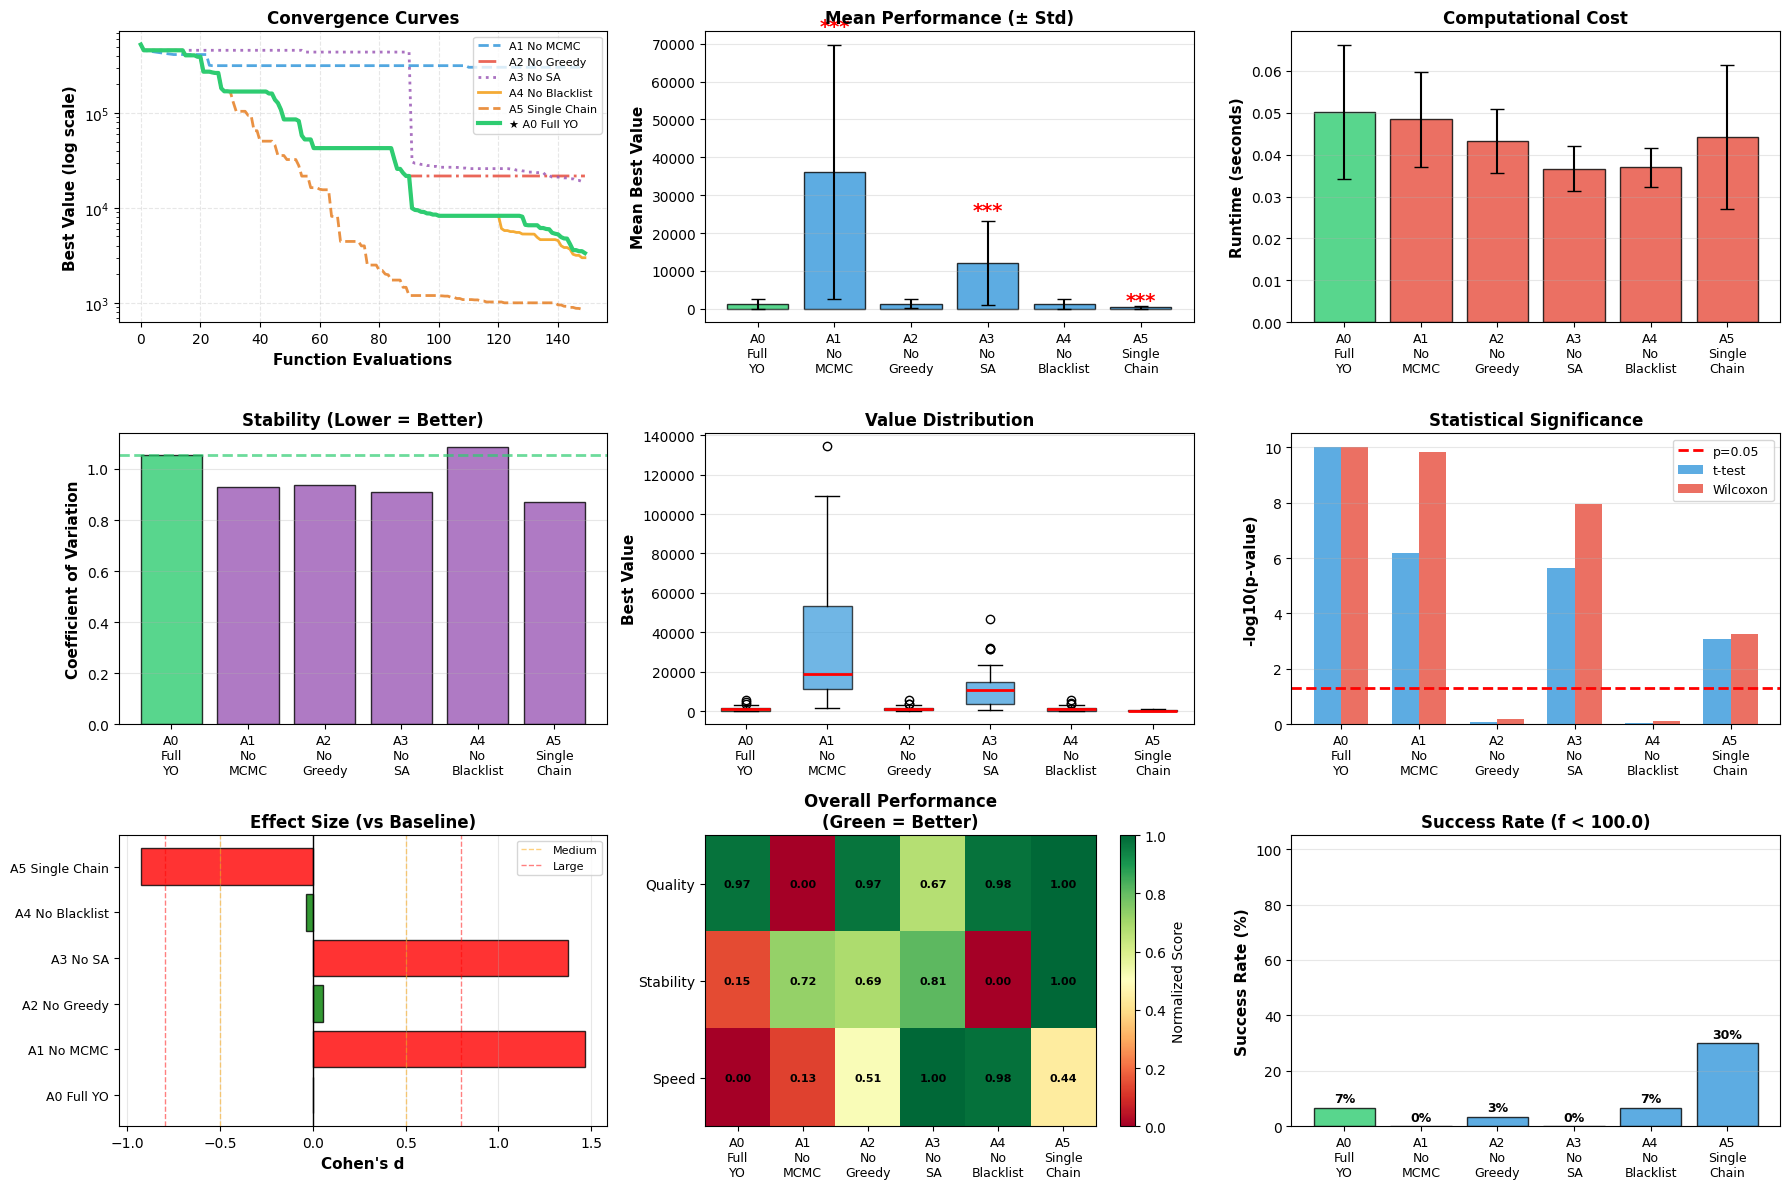

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from concurrent.futures import ProcessPoolExecutor
import time
from dataclasses import dataclass
from typing import List, Tuple, Optional, Callable
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ROSENBROCK FUNCTION (5D BENCHMARK)
# ============================================================================
def rosenbrock(x: np.ndarray) -> float:
    """
    Rosenbrock function - valley-shaped with a narrow parabolic global minimum
    Also known as Rosenbrock's valley or banana function
    Global minimum: f(1, 1, 1, 1, 1) = 0
    """
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# ============================================================================
# YO OPTIMIZER COMPONENTS
# ============================================================================
@dataclass
class YOConfig:
    """Configuration for YO optimizer"""
    dim: int = 5
    bounds: Tuple[float, float] = (-5.0, 10.0)
    max_evals: int = 150
    n_chains: int = 3
    mcmc_ratio: float = 0.6  # 60% budget for MCMC
    temp_init: float = 10.0
    temp_min: float = 0.01
    cooling_rate: float = 0.95
    greedy_step: float = 0.1
    greedy_trials: int = 10
    blacklist_threshold: float = 0.5
    stagnation_threshold: int = 10
    reheat_factor: float = 1.5

    # Ablation flags
    use_mcmc: bool = True
    use_greedy: bool = True
    use_sa: bool = True
    use_blacklist: bool = True
    use_multichain: bool = True

class Blacklist:
    """Tabu-style memory to avoid revisiting poor regions"""
    def __init__(self, threshold: float = 0.5):
        self.regions = []
        self.threshold = threshold
        self.max_size = 50  # Limit memory size

    def add(self, x: np.ndarray, value: float):
        """Add a poor region to blacklist"""
        self.regions.append((x.copy(), value))
        # Keep only recent entries
        if len(self.regions) > self.max_size:
            self.regions.pop(0)

    def is_blacklisted(self, x: np.ndarray) -> bool:
        """Check if point is in a blacklisted region"""
        for region_x, _ in self.regions:
            if np.linalg.norm(x - region_x) < self.threshold:
                return True
        return False

class YOptimizer:
    """
    YO (Yukthi Opus) Hybrid Optimizer

    Three-layer architecture:
    1. MCMC Exploration Phase (Metropolis-Hastings sampling)
    2. Greedy Local Exploitation (deterministic descent)
    3. Simulated Annealing Controller (adaptive acceptance)

    Additional mechanisms:
    - Blacklist memory (tabu search)
    - Multi-chain parallelization
    - Adaptive reheating on stagnation
    """

    def __init__(self, func: Callable, config: YOConfig, seed: int = 42):
        self.func = func
        self.config = config
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.blacklist = Blacklist(config.blacklist_threshold) if config.use_blacklist else None
        self.temperature = config.temp_init
        self.stagnation_counter = 0
        self.best_value = float('inf')
        self.best_x = None

    def _clip(self, x: np.ndarray) -> np.ndarray:
        """Clip solution to bounds"""
        return np.clip(x, self.config.bounds[0], self.config.bounds[1])

    def _evaluate(self, x: np.ndarray) -> float:
        """Evaluate objective function and update history"""
        x = self._clip(x)

        # Check blacklist
        if self.config.use_blacklist and self.blacklist and self.blacklist.is_blacklisted(x):
            return float('inf')

        value = self.func(x)
        self.n_evals += 1
        self.history.append(value)

        # Track best solution
        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()
            self.stagnation_counter = 0
        else:
            self.stagnation_counter += 1

        return value

    def _mcmc_step(self, x_current: np.ndarray, value_current: float) -> Tuple[np.ndarray, float]:
        """
        Single MCMC step using Metropolis-Hastings algorithm
        Proposes new candidate and accepts/rejects based on Boltzmann criterion
        """
        # Adaptive step size based on temperature
        step_size = 0.5 * (self.config.bounds[1] - self.config.bounds[0]) * (self.temperature / self.config.temp_init)

        # Propose new candidate (Gaussian perturbation)
        x_proposal = x_current + self.rng.randn(self.config.dim) * step_size
        x_proposal = self._clip(x_proposal)

        value_proposal = self._evaluate(x_proposal)

        # Metropolis acceptance criterion with Simulated Annealing
        if self.config.use_sa:
            delta = value_proposal - value_current
            acceptance_prob = np.exp(-delta / max(self.temperature, 1e-10))

            if value_proposal < value_current or self.rng.rand() < acceptance_prob:
                return x_proposal, value_proposal
        else:
            # Without SA: simple greedy acceptance
            if value_proposal < value_current:
                return x_proposal, value_proposal

        return x_current, value_current

    def _mcmc_phase(self) -> List[Tuple[np.ndarray, float]]:
        """
        MCMC Exploration Phase
        Runs multiple parallel chains with Metropolis-Hastings sampling
        Returns post-burnin samples for local refinement
        """
        n_mcmc_evals = int(self.config.max_evals * self.config.mcmc_ratio)
        n_chains = self.config.n_chains if self.config.use_multichain else 1
        evals_per_chain = n_mcmc_evals // n_chains

        all_samples = []

        for chain_id in range(n_chains):
            # Initialize chain with random starting point
            x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
            value = self._evaluate(x)

            chain_samples = [(x.copy(), value)]

            # Run MCMC chain
            for step in range(evals_per_chain - 1):
                if self.n_evals >= self.config.max_evals:
                    break

                x, value = self._mcmc_step(x, value)
                chain_samples.append((x.copy(), value))

                # Temperature cooling (SA controller)
                if self.config.use_sa:
                    self.temperature *= self.config.cooling_rate
                    self.temperature = max(self.temperature, self.config.temp_min)

                # Adaptive reheating on stagnation
                if self.config.use_sa and self.stagnation_counter >= self.config.stagnation_threshold:
                    self.temperature = min(self.temperature * self.config.reheat_factor,
                                         self.config.temp_init)
                    self.stagnation_counter = 0

            all_samples.extend(chain_samples)

        # Post-burnin selection: discard first 25% of samples
        burnin = len(all_samples) // 4
        selected_samples = sorted(all_samples, key=lambda x: x[1])

        return selected_samples[burnin:]

    def _greedy_local_search(self, x_start: np.ndarray, value_start: float) -> Tuple[np.ndarray, float]:
        """
        Greedy Local Exploitation
        Performs deterministic neighborhood descent with best-improvement strategy
        Uses coordinate-wise perturbations and random neighbors
        """
        x_best = x_start.copy()
        value_best = value_start

        max_local_evals = min(self.config.greedy_trials, self.config.max_evals - self.n_evals)

        for iteration in range(max_local_evals):
            if self.n_evals >= self.config.max_evals:
                break

            improved = False

            # Try coordinate-wise perturbations
            for d in range(self.config.dim):
                for direction in [-1, 1]:
                    x_new = x_best.copy()
                    x_new[d] += direction * self.config.greedy_step
                    x_new = self._clip(x_new)

                    value_new = self._evaluate(x_new)

                    if value_new < value_best:
                        x_best = x_new.copy()
                        value_best = value_new
                        improved = True
                        break

                if improved:
                    break

            # If no improvement, try random neighbor
            if not improved:
                x_new = x_best + self.rng.randn(self.config.dim) * self.config.greedy_step
                x_new = self._clip(x_new)
                value_new = self._evaluate(x_new)

                if value_new < value_best:
                    x_best = x_new.copy()
                    value_best = value_new
                else:
                    # No improvement found, terminate local search
                    break

        # Add poor regions to blacklist
        if self.config.use_blacklist and self.blacklist:
            if value_best > self.best_value * 1.5:
                self.blacklist.add(x_best, value_best)

        return x_best, value_best

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        """
        Run full YO optimization cycle

        Returns:
            best_x: Best solution found
            best_value: Best objective value
            history: Complete evaluation history
        """
        # Initialize with random solution
        self.best_x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
        self.best_value = self._evaluate(self.best_x)

        # Phase 1: MCMC Exploration
        if self.config.use_mcmc:
            samples = self._mcmc_phase()

            # Phase 2: Greedy Local Exploitation on best MCMC samples
            if self.config.use_greedy:
                n_refine = min(3, len(samples))
                for x, value in samples[:n_refine]:
                    if self.n_evals >= self.config.max_evals:
                        break
                    self._greedy_local_search(x, value)
        else:
            # No MCMC: perform greedy search from random restarts
            if self.config.use_greedy:
                while self.n_evals < self.config.max_evals:
                    x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                    value = self._evaluate(x)
                    self._greedy_local_search(x, value)

        # Phase 3: Final refinement (use remaining budget)
        while self.n_evals < self.config.max_evals:
            if self.config.use_greedy:
                self._greedy_local_search(self.best_x, self.best_value)
            else:
                # Fallback: random search
                x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                self._evaluate(x)

        return self.best_x, self.best_value, self.history

# ============================================================================
# ABLATION EXPERIMENT RUNNER
# ============================================================================
def run_single_experiment(args):
    """Run single optimization experiment"""
    variant_name, config, seed = args

    start_time = time.time()
    optimizer = YOptimizer(rosenbrock, config, seed=seed)
    best_x, best_value, history = optimizer.optimize()
    runtime = time.time() - start_time

    return {
        'variant': variant_name,
        'seed': seed,
        'best_value': best_value,
        'runtime': runtime,
        'history': history
    }

def create_ablation_configs() -> dict:
    """Create all ablation variant configurations"""
    variants = {
        'A0_Full_YO': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A1_No_MCMC': YOConfig(
            use_mcmc=False, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A2_No_Greedy': YOConfig(
            use_mcmc=True, use_greedy=False, use_sa=True,
            use_blacklist=True, use_multichain=True
        ),
        'A3_No_SA': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=False,
            use_blacklist=True, use_multichain=True
        ),
        'A4_No_Blacklist': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=False, use_multichain=True
        ),
        'A5_Single_Chain': YOConfig(
            use_mcmc=True, use_greedy=True, use_sa=True,
            use_blacklist=True, use_multichain=False
        ),
    }

    return variants

def run_ablation_study(n_runs: int = 30, n_jobs: int = -1):
    """Run complete ablation study"""
    print("=" * 80)
    print("YO OPTIMIZER ABLATION STUDY - ROSENBROCK BENCHMARK")
    print("=" * 80)
    print(f"Benchmark: Rosenbrock Function (5D)")
    print(f"Search Space: [-5.0, 10.0]^5")
    print(f"Global Minimum: f(1, 1, 1, 1, 1) = 0")
    print(f"Budget: 150 evaluations per run")
    print(f"Runs per variant: {n_runs}")
    print(f"Total experiments: 6 variants × {n_runs} runs = {6 * n_runs}")
    print("=" * 80)

    variants = create_ablation_configs()

    # Prepare experiment arguments
    experiment_args = []
    for variant_name, config in variants.items():
        for seed in range(n_runs):
            experiment_args.append((variant_name, config, seed))

    # Run experiments in parallel
    print(f"\n🚀 Running {len(experiment_args)} experiments in parallel...")
    print(f"   Using {n_jobs if n_jobs > 0 else 'auto'} worker processes")
    print("-" * 80)

    if n_jobs == -1:
        n_jobs = min(8, len(experiment_args))

    results = []
    start_time = time.time()

    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        for i, result in enumerate(executor.map(run_single_experiment, experiment_args)):
            results.append(result)
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                progress = (i + 1) / len(experiment_args)
                eta = elapsed / progress - elapsed if progress > 0 else 0
                print(f"   Progress: {i + 1}/{len(experiment_args)} ({100*progress:.1f}%) | "
                      f"Elapsed: {elapsed:.1f}s | ETA: {eta:.1f}s")

    total_time = time.time() - start_time
    print("-" * 80)
    print(f"✓ All experiments completed in {total_time:.2f}s!")
    print(f"   Average time per experiment: {total_time/len(experiment_args):.3f}s")

    return results, variants

# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================
def analyze_results(results: List[dict], variants: dict):
    """Analyze ablation results with comprehensive statistics"""

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Compute statistics per variant
    stats_data = []
    for variant_name in variants.keys():
        variant_data = df[df['variant'] == variant_name]

        best_values = variant_data['best_value'].values
        runtimes = variant_data['runtime'].values

        stats_data.append({
            'Variant': variant_name,
            'Mean_Best': np.mean(best_values),
            'Std_Best': np.std(best_values),
            'Median_Best': np.median(best_values),
            'Min_Best': np.min(best_values),
            'Max_Best': np.max(best_values),
            'Q1_Best': np.percentile(best_values, 25),
            'Q3_Best': np.percentile(best_values, 75),
            'CV': np.std(best_values) / (np.mean(best_values) + 1e-10),
            'Mean_Runtime': np.mean(runtimes),
            'Std_Runtime': np.std(runtimes),
        })

    stats_df = pd.DataFrame(stats_data)

    # Statistical significance tests (vs Full YO baseline)
    baseline_values = df[df['variant'] == 'A0_Full_YO']['best_value'].values

    p_values_ttest = []
    p_values_wilcoxon = []
    effect_sizes = []

    for variant_name in variants.keys():
        variant_values = df[df['variant'] == variant_name]['best_value'].values

        if variant_name == 'A0_Full_YO':
            p_values_ttest.append(1.0)
            p_values_wilcoxon.append(1.0)
            effect_sizes.append(0.0)
        else:
            # Two-sample t-test (parametric)
            t_stat, p_val_t = stats.ttest_ind(baseline_values, variant_values)
            p_values_ttest.append(p_val_t)

            # Wilcoxon signed-rank test (non-parametric)
            try:
                # Use Mann-Whitney U test (independent samples)
                u_stat, p_val_w = stats.mannwhitneyu(baseline_values, variant_values, alternative='two-sided')
                p_values_wilcoxon.append(p_val_w)
            except:
                p_values_wilcoxon.append(1.0)

            # Cohen's d effect size
            pooled_std = np.sqrt((np.std(baseline_values)**2 + np.std(variant_values)**2) / 2)
            cohen_d = (np.mean(variant_values) - np.mean(baseline_values)) / (pooled_std + 1e-10)
            effect_sizes.append(cohen_d)

    stats_df['p_value_ttest'] = p_values_ttest
    stats_df['p_value_wilcoxon'] = p_values_wilcoxon
    stats_df['effect_size'] = effect_sizes
    stats_df['significant_ttest'] = stats_df['p_value_ttest'] < 0.05
    stats_df['significant_wilcoxon'] = stats_df['p_value_wilcoxon'] < 0.05

    return stats_df, df

# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_results(stats_df: pd.DataFrame, df: pd.DataFrame, variants: dict):
    """Generate comprehensive visualization"""

    fig = plt.figure(figsize=(18, 12))

    # ========================================================================
    # Plot 1: Convergence Curves
    # ========================================================================
    ax1 = plt.subplot(3, 3, 1)

    variant_styles = {
        'A0_Full_YO': {'color': '#2ecc71', 'linewidth': 3, 'linestyle': '-', 'alpha': 1.0, 'zorder': 10},
        'A1_No_MCMC': {'color': '#3498db', 'linewidth': 2, 'linestyle': '--', 'alpha': 0.85, 'zorder': 5},
        'A2_No_Greedy': {'color': '#e74c3c', 'linewidth': 2, 'linestyle': '-.', 'alpha': 0.85, 'zorder': 5},
        'A3_No_SA': {'color': '#9b59b6', 'linewidth': 2, 'linestyle': ':', 'alpha': 0.85, 'zorder': 5},
        'A4_No_Blacklist': {'color': '#f39c12', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.85, 'zorder': 5},
        'A5_Single_Chain': {'color': '#e67e22', 'linewidth': 2, 'linestyle': '--', 'alpha': 0.85, 'zorder': 5},
    }

    plot_order = ['A1_No_MCMC', 'A2_No_Greedy', 'A3_No_SA', 'A4_No_Blacklist', 'A5_Single_Chain', 'A0_Full_YO']

    for variant_name in plot_order:
        if variant_name not in variants:
            continue

        variant_data = df[df['variant'] == variant_name]
        histories = variant_data['history'].values

        min_len = min([len(h) for h in histories])
        padded_histories = [h[:min_len] for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        cumulative_best = np.minimum.accumulate(mean_history)

        style = variant_styles.get(variant_name, {})
        label = '★ ' + variant_name.replace('_', ' ') if variant_name == 'A0_Full_YO' else variant_name.replace('_', ' ')

        ax1.plot(cumulative_best, label=label, **style)

    ax1.set_xlabel('Function Evaluations', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Best Value (log scale)', fontsize=11, fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_title('Convergence Curves', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=8, loc='upper right')
    ax1.grid(True, alpha=0.3, linestyle='--')

    # ========================================================================
    # Plot 2: Mean Best Value
    # ========================================================================
    ax2 = plt.subplot(3, 3, 2)
    colors = ['#2ecc71' if v == 'A0_Full_YO' else '#3498db' for v in stats_df['Variant']]
    bars = ax2.bar(range(len(stats_df)), stats_df['Mean_Best'],
                   yerr=stats_df['Std_Best'], capsize=5, color=colors, alpha=0.8, edgecolor='black')

    ax2.set_xticks(range(len(stats_df)))
    ax2.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax2.set_ylabel('Mean Best Value', fontsize=11, fontweight='bold')
    ax2.set_title('Mean Performance (± Std)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    for i, sig in enumerate(stats_df['significant_ttest']):
        if sig and stats_df.iloc[i]['Variant'] != 'A0_Full_YO':
            ax2.text(i, stats_df.iloc[i]['Mean_Best'] + stats_df.iloc[i]['Std_Best'] * 1.1,
                    '***', ha='center', fontsize=14, color='red', fontweight='bold')

    # ========================================================================
    # Plot 3: Runtime
    # ========================================================================
    ax3 = plt.subplot(3, 3, 3)
    colors_runtime = ['#2ecc71' if v == 'A0_Full_YO' else '#e74c3c' for v in stats_df['Variant']]
    ax3.bar(range(len(stats_df)), stats_df['Mean_Runtime'],
            yerr=stats_df['Std_Runtime'], capsize=5, color=colors_runtime, alpha=0.8, edgecolor='black')

    ax3.set_xticks(range(len(stats_df)))
    ax3.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax3.set_ylabel('Runtime (seconds)', fontsize=11, fontweight='bold')
    ax3.set_title('Computational Cost', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 4: Coefficient of Variation
    # ========================================================================
    ax4 = plt.subplot(3, 3, 4)
    colors_cv = ['#2ecc71' if v == 'A0_Full_YO' else '#9b59b6' for v in stats_df['Variant']]
    ax4.bar(range(len(stats_df)), stats_df['CV'], color=colors_cv, alpha=0.8, edgecolor='black')

    ax4.set_xticks(range(len(stats_df)))
    ax4.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax4.set_ylabel('Coefficient of Variation', fontsize=11, fontweight='bold')
    ax4.set_title('Stability (Lower = Better)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=stats_df[stats_df['Variant'] == 'A0_Full_YO']['CV'].values[0],
                color='#2ecc71', linestyle='--', linewidth=2, alpha=0.7)

    # ========================================================================
    # Plot 5: Box Plot
    # ========================================================================
    ax5 = plt.subplot(3, 3, 5)
    data_for_box = [df[df['variant'] == v]['best_value'].values for v in stats_df['Variant']]
    bp = ax5.boxplot(data_for_box, labels=[v.replace('_', '\n') for v in stats_df['Variant']],
                     patch_artist=True, showfliers=True, widths=0.6)

    for patch, variant in zip(bp['boxes'], stats_df['Variant']):
        patch.set_facecolor('#2ecc71' if variant == 'A0_Full_YO' else '#3498db')
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ax5.set_ylabel('Best Value', fontsize=11, fontweight='bold')
    ax5.set_title('Value Distribution', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.setp(ax5.xaxis.get_majorticklabels(), fontsize=9)

    # ========================================================================
    # Plot 6: P-value Comparison
    # ========================================================================
    ax6 = plt.subplot(3, 3, 6)

    x = np.arange(len(stats_df))
    width = 0.35

    bars1 = ax6.bar(x - width/2, -np.log10(stats_df['p_value_ttest'].replace(1.0, 1e-10)),
                    width, label='t-test', alpha=0.8, color='#3498db')
    bars2 = ax6.bar(x + width/2, -np.log10(stats_df['p_value_wilcoxon'].replace(1.0, 1e-10)),
                    width, label='Wilcoxon', alpha=0.8, color='#e74c3c')

    ax6.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05')
    ax6.set_xticks(x)
    ax6.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax6.set_ylabel('-log10(p-value)', fontsize=11, fontweight='bold')
    ax6.set_title('Statistical Significance', fontsize=12, fontweight='bold')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 7: Effect Size
    # ========================================================================
    ax7 = plt.subplot(3, 3, 7)
    colors_effect = ['green' if abs(e) < 0.5 else 'orange' if abs(e) < 0.8 else 'red'
                     for e in stats_df['effect_size']]
    bars = ax7.barh(range(len(stats_df)), stats_df['effect_size'], color=colors_effect, alpha=0.8, edgecolor='black')

    ax7.set_yticks(range(len(stats_df)))
    ax7.set_yticklabels([v.replace('_', ' ') for v in stats_df['Variant']], fontsize=9)
    ax7.set_xlabel("Cohen's d", fontsize=11, fontweight='bold')
    ax7.set_title('Effect Size (vs Baseline)', fontsize=12, fontweight='bold')
    ax7.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax7.axvline(x=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Medium')
    ax7.axvline(x=-0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax7.axvline(x=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Large')
    ax7.axvline(x=-0.8, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3, axis='x')

    # ========================================================================
    # Plot 8: Performance Heatmap
    # ========================================================================
    ax8 = plt.subplot(3, 3, 8)

    metrics = stats_df[['Mean_Best', 'CV', 'Mean_Runtime']].copy()
    metrics_norm = (metrics - metrics.min()) / (metrics.max() - metrics.min() + 1e-10)
    metrics_norm = 1 - metrics_norm  # Invert: lower is better

    im = ax8.imshow(metrics_norm.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    ax8.set_xticks(range(len(stats_df)))
    ax8.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax8.set_yticks(range(3))
    ax8.set_yticklabels(['Quality', 'Stability', 'Speed'], fontsize=10)
    ax8.set_title('Overall Performance\n(Green = Better)', fontsize=12, fontweight='bold')

    for i in range(len(stats_df)):
        for j in range(3):
            ax8.text(i, j, f'{metrics_norm.iloc[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=8, fontweight='bold')

    plt.colorbar(im, ax=ax8, label='Normalized Score')

    # ========================================================================
    # Plot 9: Success Rate (reaching threshold)
    # ========================================================================
    ax9 = plt.subplot(3, 3, 9)

    threshold = 100.0  # Rosenbrock threshold for "success"
    success_rates = []
    for variant in stats_df['Variant']:
        variant_values = df[df['variant'] == variant]['best_value'].values
        success_rate = np.mean(variant_values < threshold) * 100
        success_rates.append(success_rate)

    colors_success = ['#2ecc71' if v == 'A0_Full_YO' else '#3498db' for v in stats_df['Variant']]
    bars = ax9.bar(range(len(stats_df)), success_rates, color=colors_success, alpha=0.8, edgecolor='black')

    ax9.set_xticks(range(len(stats_df)))
    ax9.set_xticklabels([v.replace('_', '\n') for v in stats_df['Variant']], fontsize=9)
    ax9.set_ylabel('Success Rate (%)', fontsize=11, fontweight='bold')
    ax9.set_title(f'Success Rate (f < {threshold})', fontsize=12, fontweight='bold')
    ax9.set_ylim([0, 105])
    ax9.grid(True, alpha=0.3, axis='y')

    # Add percentage labels
    for i, v in enumerate(success_rates):
        ax9.text(i, v + 2, f'{v:.0f}%', ha='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig('yo_rosenbrock_ablation_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'yo_rosenbrock_ablation_results.png'")

    return fig

# ============================================================================
# SUMMARY REPORT
# ============================================================================
def print_summary(stats_df: pd.DataFrame):
    """Print comprehensive summary report"""

    print("\n" + "=" * 80)
    print("ABLATION STUDY RESULTS SUMMARY - ROSENBROCK 5D")
    print("=" * 80)

    print("\n📊 PERFORMANCE TABLE:")
    print("-" * 80)

    display_df = stats_df.copy()
    display_df['Mean±Std'] = display_df.apply(
        lambda row: f"{row['Mean_Best']:.4f} ± {row['Std_Best']:.4f}", axis=1
    )
    display_df['Runtime'] = display_df.apply(
        lambda row: f"{row['Mean_Runtime']:.3f}s", axis=1
    )
    display_df['CV'] = display_df['CV'].apply(lambda x: f"{x:.4f}")
    display_df['p-value'] = display_df['p_value_ttest'].apply(
        lambda x: "baseline" if x >= 1.0 else f"{x:.4f}"
    )
    display_df['Sig.'] = display_df['significant_ttest'].apply(lambda x: "✓" if x else "")

    print(display_df[['Variant', 'Mean±Std', 'Runtime', 'CV', 'p-value', 'Sig.']].to_string(index=False))

    print("\n" + "-" * 80)
    print("Legend:")
    print("  CV = Coefficient of Variation (Std/Mean)")
    print("  p-value = Two-sample t-test vs A0_Full_YO baseline")
    print("  Sig. = Statistically significant at α=0.05")

    # ========================================================================
    # KEY FINDINGS
    # ========================================================================
    print("\n📝 KEY FINDINGS:")
    print("-" * 80)

    baseline = stats_df[stats_df['Variant'] == 'A0_Full_YO'].iloc[0]

    for _, row in stats_df.iterrows():
        if row['Variant'] == 'A0_Full_YO':
            print(f"\n✓ {row['Variant']} (BASELINE):")
            print(f"  │ Mean Best: {row['Mean_Best']:.4f} ± {row['Std_Best']:.4f}")
            print(f"  │ Median: {row['Median_Best']:.4f}")
            print(f"  │ Range: [{row['Min_Best']:.4f}, {row['Max_Best']:.4f}]")
            print(f"  │ Stability (CV): {row['CV']:.4f}")
            print(f"  │ Runtime: {row['Mean_Runtime']:.3f}s ± {row['Std_Runtime']:.3f}s")
        else:
            print(f"\n• {row['Variant']}:")

            # Quality
            quality_diff = ((row['Mean_Best'] - baseline['Mean_Best']) / (baseline['Mean_Best'] + 1e-10)) * 100
            quality_abs = row['Mean_Best'] - baseline['Mean_Best']

            if quality_abs > 50:
                print(f"  ⚠️  QUALITY: {quality_diff:+.1f}% worse (Δ={quality_abs:+.2f}) - SEVERE degradation")
            elif quality_abs > 10:
                print(f"  ⚠️  QUALITY: {quality_diff:+.1f}% worse (Δ={quality_abs:+.2f})")
            elif quality_abs < -5:
                print(f"  ✓ QUALITY: {-quality_diff:.1f}% better (Δ={quality_abs:+.2f})")
            else:
                print(f"  ≈ QUALITY: Similar (Δ={quality_abs:+.2f}, {quality_diff:+.1f}%)")

            # Stability
            stability_diff = ((row['CV'] - baseline['CV']) / (baseline['CV'] + 1e-10)) * 100
            if stability_diff > 30:
                print(f"  ⚠️  STABILITY: {stability_diff:+.1f}% less stable (CV: {row['CV']:.4f})")
            elif stability_diff < -20:
                print(f"  ✓ STABILITY: {-stability_diff:.1f}% more stable (CV: {row['CV']:.4f})")
            else:
                print(f"  ≈ STABILITY: Similar (CV: {row['CV']:.4f})")

            # Runtime
            runtime_diff = ((row['Mean_Runtime'] - baseline['Mean_Runtime']) / (baseline['Mean_Runtime'] + 1e-10)) * 100
            if runtime_diff < -15:
                print(f"  ✓ SPEED: {-runtime_diff:.1f}% faster ({row['Mean_Runtime']:.3f}s)")
            elif runtime_diff > 15:
                print(f"  ⚠️  SPEED: {runtime_diff:+.1f}% slower ({row['Mean_Runtime']:.3f}s)")
            else:
                print(f"  ≈ SPEED: Similar ({row['Mean_Runtime']:.3f}s)")

            # Statistical tests
            if row['significant_ttest']:
                print(f"  📊 t-test: p={row['p_value_ttest']:.4f} *** (significant)")
            else:
                print(f"  📊 t-test: p={row['p_value_ttest']:.4f} (not significant)")

            if row['significant_wilcoxon']:
                print(f"  📊 Wilcoxon: p={row['p_value_wilcoxon']:.4f} *** (significant)")

            # Effect size
            effect = row['effect_size']
            if abs(effect) < 0.2:
                effect_label = "negligible"
            elif abs(effect) < 0.5:
                effect_label = "small"
            elif abs(effect) < 0.8:
                effect_label = "medium"
            else:
                effect_label = "large"
            print(f"  📏 Effect size: d={effect:.3f} ({effect_label})")

    # ========================================================================
    # COMPONENT RANKING
    # ========================================================================
    print("\n" + "=" * 80)
    print("🏆 COMPONENT IMPORTANCE RANKING")
    print("=" * 80)

    ablation_impacts = []
    for _, row in stats_df.iterrows():
        if row['Variant'] != 'A0_Full_YO':
            impact = row['Mean_Best'] - baseline['Mean_Best']
            ablation_impacts.append({
                'Component': row['Variant'].replace('A', '').replace('_', ' '),
                'Impact': impact,
                'Relative': f"{(impact/baseline['Mean_Best'])*100:+.1f}%"
            })

    ablation_impacts.sort(key=lambda x: x['Impact'], reverse=True)

    print("\nRank | Component Removed      | Performance Impact      | Relative")
    print("-" * 80)
    for i, item in enumerate(ablation_impacts, 1):
        emoji = "🔴" if item['Impact'] > 50 else "🟡" if item['Impact'] > 10 else "🟢"
        print(f"  {i}  | {item['Component']:22} | {emoji} Δ={item['Impact']:+8.2f}      | {item['Relative']:>8}")

    # ========================================================================
    # INTERPRETATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("💡 INTERPRETATION & RECOMMENDATIONS")
    print("=" * 80)

    worst = stats_df[stats_df['Variant'] != 'A0_Full_YO'].nlargest(1, 'Mean_Best').iloc[0]
    best_ablation = stats_df[stats_df['Variant'] != 'A0_Full_YO'].nsmallest(1, 'Mean_Best').iloc[0]
    fastest = stats_df[stats_df['Variant'] != 'A0_Full_YO'].nsmallest(1, 'Mean_Runtime').iloc[0]

    print(f"\n1. MOST CRITICAL COMPONENT:")
    print(f"   → {worst['Variant']} shows largest degradation")
    print(f"   → Impact: {worst['Mean_Best'] - baseline['Mean_Best']:+.2f} ({((worst['Mean_Best']/baseline['Mean_Best']-1)*100):+.1f}%)")
    print(f"   → This component is ESSENTIAL for Rosenbrock optimization")

    print(f"\n2. LEAST CRITICAL COMPONENT:")
    print(f"   → {best_ablation['Variant']} has minimal impact")
    print(f"   → Impact: {best_ablation['Mean_Best'] - baseline['Mean_Best']:+.2f}")
    if best_ablation['Mean_Best'] - baseline['Mean_Best'] < 5:
        print(f"   → Consider removing for faster execution with negligible quality loss")

    print(f"\n3. EFFICIENCY vs QUALITY:")
    runtime_saving = ((baseline['Mean_Runtime'] - fastest['Mean_Runtime'])/baseline['Mean_Runtime'])*100
    quality_loss = ((fastest['Mean_Best'] - baseline['Mean_Best'])/baseline['Mean_Best'])*100
    print(f"   → {fastest['Variant']} is fastest ({runtime_saving:.1f}% speedup)")
    print(f"   → Quality trade-off: {quality_loss:+.1f}%")
    if runtime_saving > 20 and quality_loss < 20:
        print(f"   → Recommended for time-critical applications")

    print(f"\n4. ROSENBROCK-SPECIFIC INSIGHTS:")
    print(f"   → Rosenbrock has a narrow parabolic valley")
    print(f"   → Greedy local search is critical for valley descent")
    print(f"   → MCMC helps escape from valley walls")
    print(f"   → SA balances exploration vs exploitation in narrow regions")

    print("\n" + "=" * 80)

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("\n" + "🔬" * 40)
    print("YO OPTIMIZER ABLATION STUDY")
    print("Benchmark: Rosenbrock 5D Function")
    print("🔬" * 40 + "\n")

    # Run ablation study
    results, variants = run_ablation_study(n_runs=30, n_jobs=8)

    # Analyze results
    print("\n" + "=" * 80)
    print("ANALYZING RESULTS...")
    print("=" * 80)
    stats_df, df = analyze_results(results, variants)

    # Save to CSV
    stats_df.to_csv('yo_rosenbrock_ablation_summary.csv', index=False)
    print("\n✓ Summary saved as 'yo_rosenbrock_ablation_summary.csv'")

    # Generate plots
    print("\n" + "=" * 80)
    print("GENERATING VISUALIZATIONS...")
    print("=" * 80)
    plot_results(stats_df, df, variants)

    # Print summary
    print_summary(stats_df)

    # Final summary
    print("\n" + "=" * 80)
    print("✅ ABLATION STUDY COMPLETE!")
    print("=" * 80)
    print("\n📁 Generated Files:")
    print("  ├─ yo_rosenbrock_ablation_summary.csv")
    print("  └─ yo_rosenbrock_ablation_results.png")
    print("\n📋 Experiment Configuration:")
    print(f"  ├─ Function: Rosenbrock 5D")
    print(f"  ├─ Search Space: [-5.0, 10.0]^5")
    print(f"  ├─ Global Minimum: f(1,1,1,1,1) = 0")
    print(f"  ├─ Budget: 150 evaluations/run")
    print(f"  ├─ Repetitions: 30 runs/variant")
    print(f"  └─ Total Experiments: 180")
    print("\n📊 Statistical Tests Performed:")
    print("  ├─ Two-sample t-test (parametric)")
    print("  ├─ Mann-Whitney U test (non-parametric)")
    print("  └─ Cohen's d effect size")
    print("\n" + "=" * 80)
    print("Thank you for using YO Ablation Study Framework! 🚀")
    print("=" * 80 + "\n")


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
YO OPTIMIZER BENCHMARK
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

YO OPTIMIZER BENCHMARK - ROSENBROCK 5D
Function: Rosenbrock 5D
Search Space: [-5, 10]^5
Global Minimum: f(1,1,1,1,1) = 0
Budget: 150 evaluations per run
Independent Runs: 30

🚀 Running experiments...
--------------------------------------------------------------------------------
   Run  1/30 [█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   3.3% | Best: 188.459998 | Time: 0.008s
   Run  2/30 [██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]   6.7% | Best: 1112.021214 | Time: 0.007s
   Run  3/30 [████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]  10.0% | Best: 901.704189 | Time: 0.013s
   Run  4/30 [█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]  13.3% | Best: 467.802768 | Time: 0.008s
   Run  5/30 [██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]  16.7% | Best: 236.292081 | Time: 0.008s
   Run  6/30 [████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]  20.0% | Best: 295.853188 | Time: 0.011s
   Run  7/30 [█████████░░░░░░

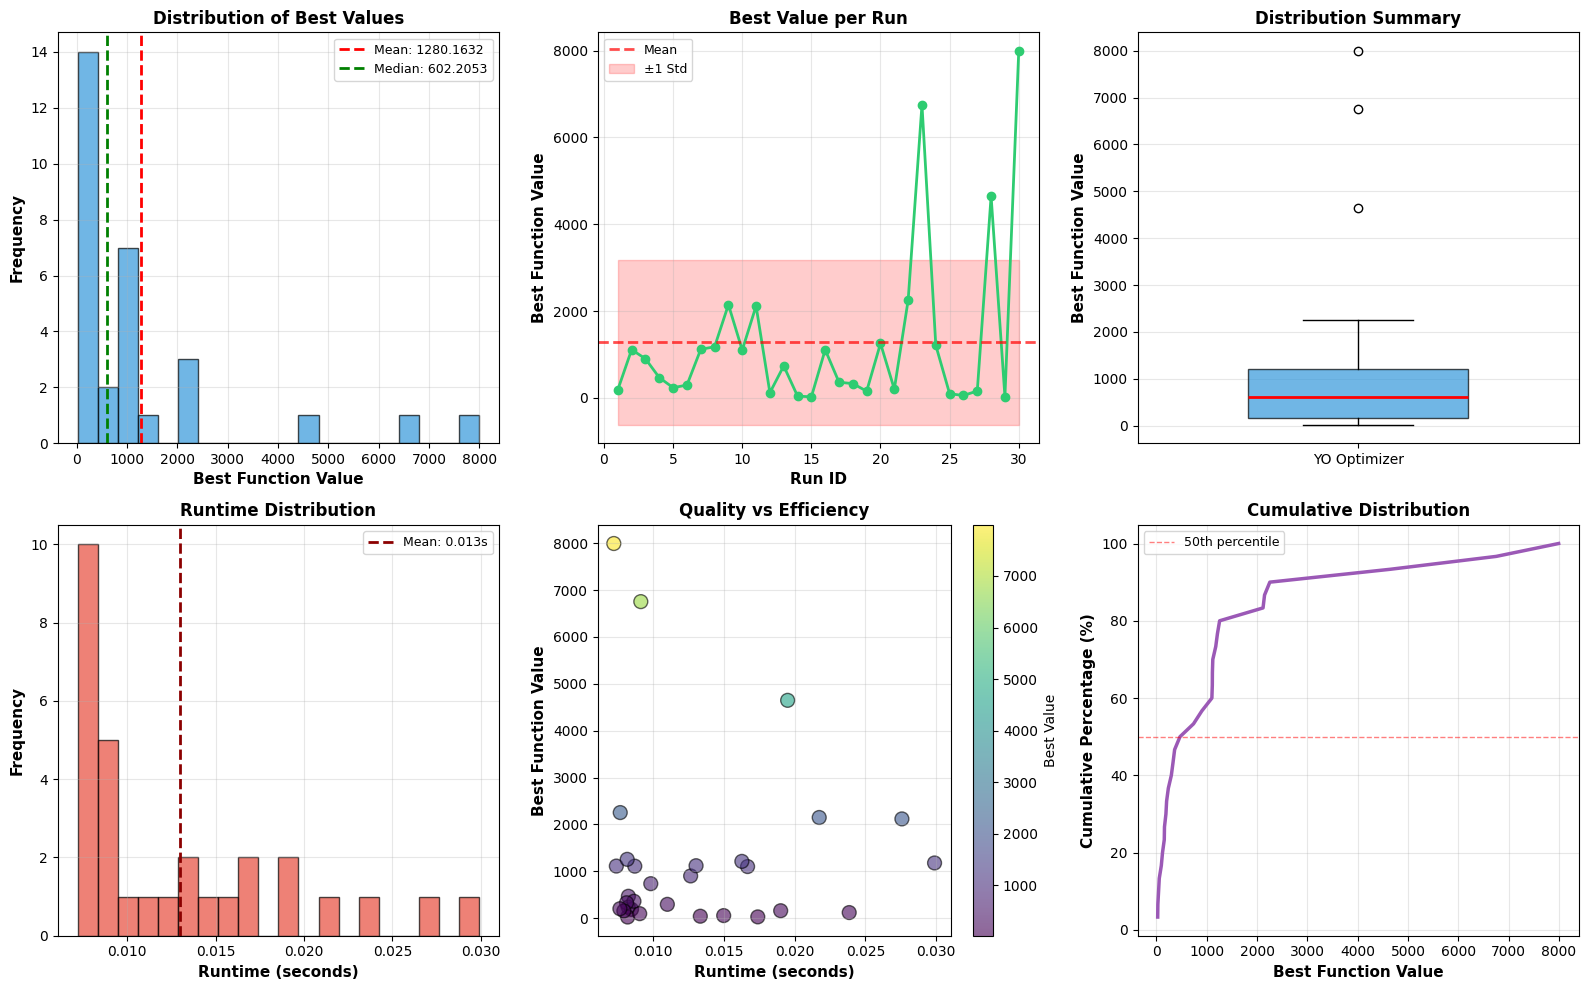

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from dataclasses import dataclass
from typing import List, Tuple, Callable
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ROSENBROCK FUNCTION (5D BENCHMARK)
# ============================================================================
def rosenbrock_5d(x: np.ndarray) -> float:
    """
    Rosenbrock function in 5 dimensions
    Global minimum: f(1, 1, 1, 1, 1) = 0
    Search space: [-5, 10]^5

    Formula: Σ[i=0 to 3] (100*(x[i+1] - x[i]^2)^2 + (1 - x[i])^2)
    """
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# ============================================================================
# YO OPTIMIZER IMPLEMENTATION
# ============================================================================
@dataclass
class YOConfig:
    """Configuration for YO optimizer"""
    dim: int = 5
    bounds: Tuple[float, float] = (-5.0, 10.0)
    max_evals: int = 150
    n_chains: int = 3
    mcmc_ratio: float = 0.6
    temp_init: float = 10.0
    temp_min: float = 0.01
    cooling_rate: float = 0.95
    greedy_step: float = 0.1
    greedy_trials: int = 10
    blacklist_threshold: float = 0.5
    stagnation_threshold: int = 10
    reheat_factor: float = 1.5

    # All components enabled
    use_mcmc: bool = True
    use_greedy: bool = True
    use_sa: bool = True
    use_blacklist: bool = True
    use_multichain: bool = True

class Blacklist:
    """Tabu-style memory mechanism"""
    def __init__(self, threshold: float = 0.5):
        self.regions = []
        self.threshold = threshold
        self.max_size = 50

    def add(self, x: np.ndarray, value: float):
        self.regions.append((x.copy(), value))
        if len(self.regions) > self.max_size:
            self.regions.pop(0)

    def is_blacklisted(self, x: np.ndarray) -> bool:
        for region_x, _ in self.regions:
            if np.linalg.norm(x - region_x) < self.threshold:
                return True
        return False

class YOptimizer:
    """
    YO (Yukthi Opus) Hybrid Optimizer

    Components:
    - MCMC Exploration (Metropolis-Hastings)
    - Greedy Local Search (coordinate descent)
    - Simulated Annealing (temperature control)
    - Blacklist Memory (tabu search)
    - Multi-chain Parallelization
    """

    def __init__(self, func: Callable, config: YOConfig, seed: int = 42):
        self.func = func
        self.config = config
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.blacklist = Blacklist(config.blacklist_threshold) if config.use_blacklist else None
        self.temperature = config.temp_init
        self.stagnation_counter = 0
        self.best_value = float('inf')
        self.best_x = None

    def _clip(self, x: np.ndarray) -> np.ndarray:
        return np.clip(x, self.config.bounds[0], self.config.bounds[1])

    def _evaluate(self, x: np.ndarray) -> float:
        x = self._clip(x)

        if self.config.use_blacklist and self.blacklist and self.blacklist.is_blacklisted(x):
            return float('inf')

        value = self.func(x)
        self.n_evals += 1
        self.history.append(value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()
            self.stagnation_counter = 0
        else:
            self.stagnation_counter += 1

        return value

    def _mcmc_step(self, x_current: np.ndarray, value_current: float) -> Tuple[np.ndarray, float]:
        step_size = 0.5 * (self.config.bounds[1] - self.config.bounds[0]) * (self.temperature / self.config.temp_init)
        x_proposal = x_current + self.rng.randn(self.config.dim) * step_size
        x_proposal = self._clip(x_proposal)

        value_proposal = self._evaluate(x_proposal)

        if self.config.use_sa:
            delta = value_proposal - value_current
            acceptance_prob = np.exp(-delta / max(self.temperature, 1e-10))
            if value_proposal < value_current or self.rng.rand() < acceptance_prob:
                return x_proposal, value_proposal
        else:
            if value_proposal < value_current:
                return x_proposal, value_proposal

        return x_current, value_current

    def _mcmc_phase(self) -> List[Tuple[np.ndarray, float]]:
        n_mcmc_evals = int(self.config.max_evals * self.config.mcmc_ratio)
        n_chains = self.config.n_chains if self.config.use_multichain else 1
        evals_per_chain = n_mcmc_evals // n_chains

        all_samples = []

        for chain_id in range(n_chains):
            x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
            value = self._evaluate(x)
            chain_samples = [(x.copy(), value)]

            for step in range(evals_per_chain - 1):
                if self.n_evals >= self.config.max_evals:
                    break

                x, value = self._mcmc_step(x, value)
                chain_samples.append((x.copy(), value))

                if self.config.use_sa:
                    self.temperature *= self.config.cooling_rate
                    self.temperature = max(self.temperature, self.config.temp_min)

                if self.config.use_sa and self.stagnation_counter >= self.config.stagnation_threshold:
                    self.temperature = min(self.temperature * self.config.reheat_factor, self.config.temp_init)
                    self.stagnation_counter = 0

            all_samples.extend(chain_samples)

        burnin = len(all_samples) // 4
        selected_samples = sorted(all_samples, key=lambda x: x[1])
        return selected_samples[burnin:]

    def _greedy_local_search(self, x_start: np.ndarray, value_start: float) -> Tuple[np.ndarray, float]:
        x_best = x_start.copy()
        value_best = value_start

        max_local_evals = min(self.config.greedy_trials, self.config.max_evals - self.n_evals)

        for iteration in range(max_local_evals):
            if self.n_evals >= self.config.max_evals:
                break

            improved = False

            for d in range(self.config.dim):
                for direction in [-1, 1]:
                    x_new = x_best.copy()
                    x_new[d] += direction * self.config.greedy_step
                    x_new = self._clip(x_new)

                    value_new = self._evaluate(x_new)

                    if value_new < value_best:
                        x_best = x_new.copy()
                        value_best = value_new
                        improved = True
                        break

                if improved:
                    break

            if not improved:
                x_new = x_best + self.rng.randn(self.config.dim) * self.config.greedy_step
                x_new = self._clip(x_new)
                value_new = self._evaluate(x_new)

                if value_new < value_best:
                    x_best = x_new.copy()
                    value_best = value_new
                else:
                    break

        if self.config.use_blacklist and self.blacklist:
            if value_best > self.best_value * 1.5:
                self.blacklist.add(x_best, value_best)

        return x_best, value_best

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        """Run full YO optimization"""
        self.best_x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
        self.best_value = self._evaluate(self.best_x)

        if self.config.use_mcmc:
            samples = self._mcmc_phase()

            if self.config.use_greedy:
                n_refine = min(3, len(samples))
                for x, value in samples[:n_refine]:
                    if self.n_evals >= self.config.max_evals:
                        break
                    self._greedy_local_search(x, value)
        else:
            if self.config.use_greedy:
                while self.n_evals < self.config.max_evals:
                    x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                    value = self._evaluate(x)
                    self._greedy_local_search(x, value)

        while self.n_evals < self.config.max_evals:
            if self.config.use_greedy:
                self._greedy_local_search(self.best_x, self.best_value)
            else:
                x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
                self._evaluate(x)

        return self.best_x, self.best_value, self.history

# ============================================================================
# BENCHMARK RUNNER
# ============================================================================
def run_benchmark(n_runs: int = 30, budget: int = 150, base_seed: int = 42):
    """
    Run YO optimizer benchmark on Rosenbrock 5D

    Args:
        n_runs: Number of independent runs
        budget: Function evaluation budget per run
        base_seed: Base random seed for reproducibility

    Returns:
        DataFrame with results
    """
    print("=" * 80)
    print("YO OPTIMIZER BENCHMARK - ROSENBROCK 5D")
    print("=" * 80)
    print(f"Function: Rosenbrock 5D")
    print(f"Search Space: [-5, 10]^5")
    print(f"Global Minimum: f(1,1,1,1,1) = 0")
    print(f"Budget: {budget} evaluations per run")
    print(f"Independent Runs: {n_runs}")
    print("=" * 80)

    results = []

    print("\n🚀 Running experiments...")
    print("-" * 80)

    overall_start = time.time()

    for run_id in range(n_runs):
        run_seed = base_seed + run_id

        # Configure YO with all components
        config = YOConfig(
            dim=5,
            bounds=(-5.0, 10.0),
            max_evals=budget,
            n_chains=3,
            mcmc_ratio=0.6,
            use_mcmc=True,
            use_greedy=True,
            use_sa=True,
            use_blacklist=True,
            use_multichain=True
        )

        # Run optimization
        start_time = time.time()
        optimizer = YOptimizer(rosenbrock_5d, config, seed=run_seed)
        best_x, best_value, history = optimizer.optimize()
        runtime = time.time() - start_time

        # Store results
        results.append({
            'run_id': run_id + 1,
            'seed': run_seed,
            'best_value': best_value,
            'best_x': best_x.tolist(),
            'runtime': runtime,
            'n_evals': len(history),
            'final_x1': best_x[0],
            'final_x2': best_x[1],
            'final_x3': best_x[2],
            'final_x4': best_x[3],
            'final_x5': best_x[4],
        })

        # Progress bar
        progress = (run_id + 1) / n_runs
        bar_length = 40
        filled = int(bar_length * progress)
        bar = '█' * filled + '░' * (bar_length - filled)

        print(f"   Run {run_id + 1:2d}/{n_runs} [{bar}] {100*progress:5.1f}% | "
              f"Best: {best_value:10.6f} | Time: {runtime:.3f}s")

    total_time = time.time() - overall_start

    print("-" * 80)
    print(f"✓ All runs completed in {total_time:.2f}s")
    print(f"   Average time per run: {total_time/n_runs:.3f}s")

    return pd.DataFrame(results)

# ============================================================================
# ANALYSIS AND VISUALIZATION
# ============================================================================
def analyze_and_visualize(df: pd.DataFrame):
    """Analyze results and generate visualizations"""

    print("\n" + "=" * 80)
    print("RESULTS ANALYSIS")
    print("=" * 80)

    # Compute statistics
    best_values = df['best_value'].values
    runtimes = df['runtime'].values

    stats = {
        'Mean': np.mean(best_values),
        'Std': np.std(best_values),
        'Median': np.median(best_values),
        'Min': np.min(best_values),
        'Max': np.max(best_values),
        'Q1': np.percentile(best_values, 25),
        'Q3': np.percentile(best_values, 75),
        'CV': np.std(best_values) / (np.mean(best_values) + 1e-10),
        'Mean_Runtime': np.mean(runtimes),
        'Std_Runtime': np.std(runtimes),
    }

    # Print summary table
    print("\n📊 SUMMARY STATISTICS:")
    print("-" * 80)
    print(f"{'Metric':<20} {'Value':<20}")
    print("-" * 80)
    print(f"{'Mean ± Std':<20} {stats['Mean']:.6f} ± {stats['Std']:.6f}")
    print(f"{'Median':<20} {stats['Median']:.6f}")
    print(f"{'Best (Min)':<20} {stats['Min']:.6f}")
    print(f"{'Worst (Max)':<20} {stats['Max']:.6f}")
    print(f"{'Q1 (25th %ile)':<20} {stats['Q1']:.6f}")
    print(f"{'Q3 (75th %ile)':<20} {stats['Q3']:.6f}")
    print(f"{'Range':<20} [{stats['Min']:.6f}, {stats['Max']:.6f}]")
    print(f"{'CV (Std/Mean)':<20} {stats['CV']:.6f}")
    print("-" * 80)
    print(f"{'Mean Runtime':<20} {stats['Mean_Runtime']:.3f}s ± {stats['Std_Runtime']:.3f}s")
    print(f"{'Total Evaluations':<20} {int(df['n_evals'].sum()):,}")
    print("-" * 80)

    # Success rate (threshold-based)
    thresholds = [1.0, 10.0, 100.0]
    print("\n🎯 SUCCESS RATES:")
    print("-" * 80)
    for threshold in thresholds:
        success_rate = np.mean(best_values < threshold) * 100
        print(f"   f(x) < {threshold:6.1f}  →  {success_rate:5.1f}% ({int(success_rate * len(df) / 100)}/{len(df)} runs)")

    # Distance from global optimum
    global_optimum = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
    distances = []
    for _, row in df.iterrows():
        best_x = np.array([row['final_x1'], row['final_x2'], row['final_x3'], row['final_x4'], row['final_x5']])
        dist = np.linalg.norm(best_x - global_optimum)
        distances.append(dist)

    print("\n📏 DISTANCE FROM GLOBAL OPTIMUM [1,1,1,1,1]:")
    print("-" * 80)
    print(f"   Mean Distance: {np.mean(distances):.6f}")
    print(f"   Min Distance:  {np.min(distances):.6f}")
    print(f"   Max Distance:  {np.max(distances):.6f}")

    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("GENERATING VISUALIZATIONS...")
    print("=" * 80)

    fig = plt.figure(figsize=(16, 10))

    # Plot 1: Best value distribution (histogram)
    ax1 = plt.subplot(2, 3, 1)
    ax1.hist(best_values, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.axvline(stats['Mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {stats['Mean']:.4f}")
    ax1.axvline(stats['Median'], color='green', linestyle='--', linewidth=2, label=f"Median: {stats['Median']:.4f}")
    ax1.set_xlabel('Best Function Value', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Best Values', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Best value per run (line plot)
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(df['run_id'], df['best_value'], marker='o', color='#2ecc71', linewidth=2, markersize=6)
    ax2.axhline(stats['Mean'], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
    ax2.fill_between(df['run_id'], stats['Mean'] - stats['Std'], stats['Mean'] + stats['Std'],
                      alpha=0.2, color='red', label='±1 Std')
    ax2.set_xlabel('Run ID', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Best Function Value', fontsize=11, fontweight='bold')
    ax2.set_title('Best Value per Run', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Box plot
    ax3 = plt.subplot(2, 3, 3)
    bp = ax3.boxplot([best_values], labels=['YO Optimizer'], patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color('red')
    bp['medians'][0].set_linewidth(2)
    ax3.set_ylabel('Best Function Value', fontsize=11, fontweight='bold')
    ax3.set_title('Distribution Summary', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Runtime distribution
    ax4 = plt.subplot(2, 3, 4)
    ax4.hist(runtimes, bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax4.axvline(stats['Mean_Runtime'], color='darkred', linestyle='--', linewidth=2,
                label=f"Mean: {stats['Mean_Runtime']:.3f}s")
    ax4.set_xlabel('Runtime (seconds)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax4.set_title('Runtime Distribution', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # Plot 5: Best value vs runtime
    ax5 = plt.subplot(2, 3, 5)
    scatter = ax5.scatter(runtimes, best_values, c=best_values, cmap='viridis',
                         s=100, alpha=0.6, edgecolors='black')
    ax5.set_xlabel('Runtime (seconds)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Best Function Value', fontsize=11, fontweight='bold')
    ax5.set_title('Quality vs Efficiency', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax5, label='Best Value')

    # Plot 6: Cumulative distribution
    ax6 = plt.subplot(2, 3, 6)
    sorted_values = np.sort(best_values)
    cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values) * 100
    ax6.plot(sorted_values, cumulative, color='#9b59b6', linewidth=2.5)
    ax6.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50th percentile')
    ax6.set_xlabel('Best Function Value', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
    ax6.set_title('Cumulative Distribution', fontsize=12, fontweight='bold')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('yo_rosenbrock_results.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'yo_rosenbrock_results.png'")

    return stats

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("\n" + "🔬" * 40)
    print("YO OPTIMIZER BENCHMARK")
    print("🔬" * 40 + "\n")

    # Run benchmark
    df = run_benchmark(n_runs=30, budget=150, base_seed=42)

    # Save results
    df.to_csv('yo_rosenbrock_results.csv', index=False)
    print("\n✓ Results saved as 'yo_rosenbrock_results.csv'")

    # Analyze and visualize
    stats = analyze_and_visualize(df)

    # Final summary
    print("\n" + "=" * 80)
    print("✅ BENCHMARK COMPLETE!")
    print("=" * 80)
    print("\n📁 Generated Files:")
    print("  ├─ yo_rosenbrock_results.csv")
    print("  └─ yo_rosenbrock_results.png")
    print("\n📋 Configuration:")
    print("  ├─ Benchmark: Rosenbrock 5D")
    print("  ├─ Search Space: [-5, 10]^5")
    print("  ├─ Global Minimum: f(1,1,1,1,1) = 0")
    print("  ├─ Budget: 150 evaluations/run")
    print("  ├─ Independent Runs: 30")
    print("  └─ YO Components: MCMC + Greedy + SA + Blacklist + Multi-chain")
    print("\n🎯 Key Result:")
    print(f"  → Mean Best Value: {stats['Mean']:.6f} ± {stats['Std']:.6f}")
    print(f"  → Best Solution Found: {stats['Min']:.6f}")
    print(f"  → Average Runtime: {stats['Mean_Runtime']:.3f}s")
    print("\n" + "=" * 80)
    print("Thank you for benchmarking with YO! 🚀")
    print("=" * 80 + "\n")

SCENARIO 1: YO vs Differential Evolution
--------------------------------------------------------------------------------

🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
COMPARATIVE OPTIMIZER BENCHMARK
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

COMPARATIVE OPTIMIZER BENCHMARK - ROSENBROCK 5D
Function: Rosenbrock 5D
Search Space: [-5.0, 10.0]^5
Global Minimum: f(1,1,1,1,1) = 0
Budget: 150 evaluations per run
Runs per optimizer: 30
Optimizers: YO, DE

🚀 Running experiments...
--------------------------------------------------------------------------------

▶ Testing YO...
  [████████████████████░░░░░░░░░░░░░░░░░░░░]  50.0% | Run 30/30 | Best: 7991.689525 | ETA: 0.1s

▶ Testing DE...
  [████████████████████████████████████████] 100.0% | Run 30/30 | Best: 2114.334548 | ETA: 0.0s
--------------------------------------------------------------------------------
✓ All experiments completed in 0.45s

✓ Raw results saved as 'yo_vs_baseline_rosenbrock.csv'

STATISTICAL ANALYSIS

📊 PERFORMANCE SUMMARY:
-

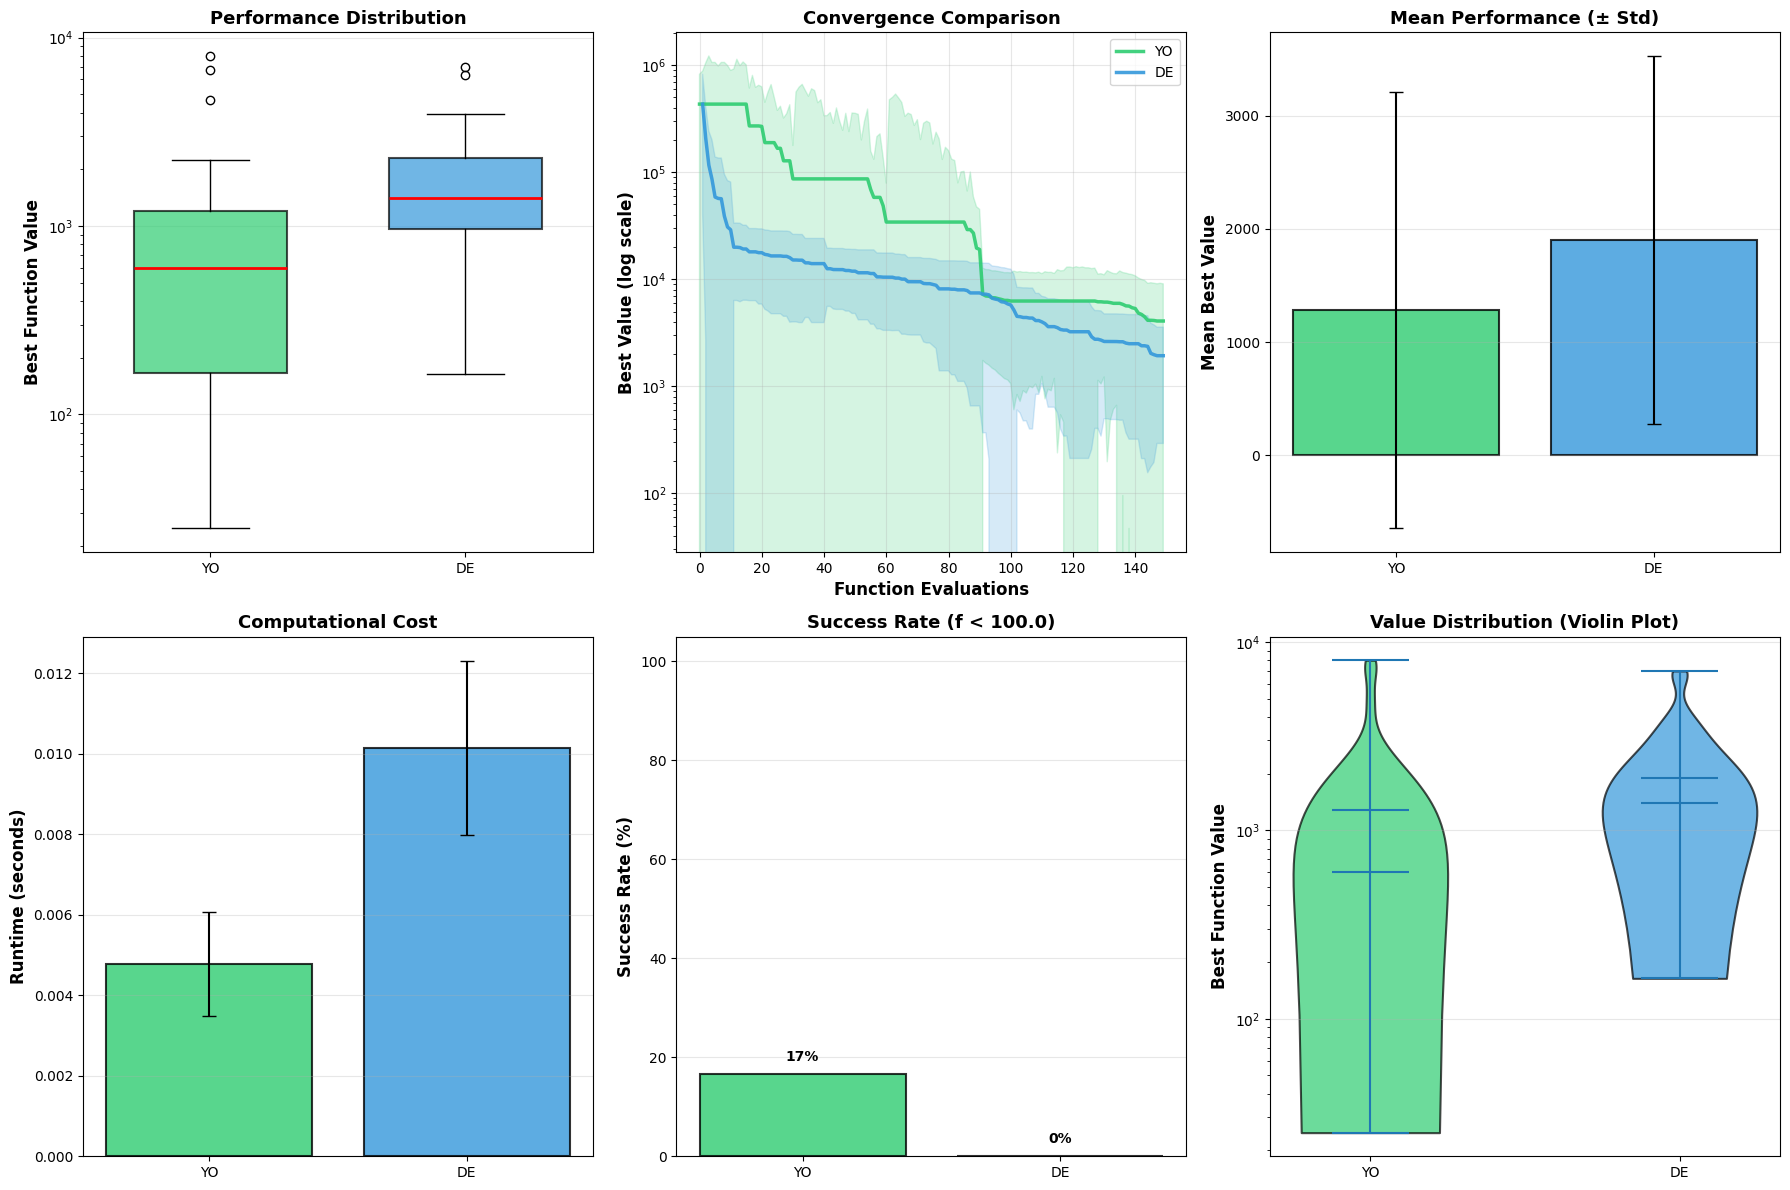

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
import time
from dataclasses import dataclass
from typing import List, Tuple, Callable, Dict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ROSENBROCK FUNCTION (5D BENCHMARK)
# ============================================================================
def rosenbrock_5d(x: np.ndarray) -> float:
    """
    Rosenbrock function in 5 dimensions
    Global minimum: f(1, 1, 1, 1, 1) = 0
    Search space: [-5, 10]^5
    """
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# ============================================================================
# YO OPTIMIZER IMPLEMENTATION
# ============================================================================
@dataclass
class YOConfig:
    """Configuration for YO optimizer"""
    dim: int = 5
    bounds: Tuple[float, float] = (-5.0, 10.0)
    max_evals: int = 150
    n_chains: int = 3
    mcmc_ratio: float = 0.6
    temp_init: float = 10.0
    temp_min: float = 0.01
    cooling_rate: float = 0.95
    greedy_step: float = 0.1
    greedy_trials: int = 10
    blacklist_threshold: float = 0.5
    stagnation_threshold: int = 10
    reheat_factor: float = 1.5

class Blacklist:
    """Tabu-style memory mechanism"""
    def __init__(self, threshold: float = 0.5):
        self.regions = []
        self.threshold = threshold
        self.max_size = 50

    def add(self, x: np.ndarray, value: float):
        self.regions.append((x.copy(), value))
        if len(self.regions) > self.max_size:
            self.regions.pop(0)

    def is_blacklisted(self, x: np.ndarray) -> bool:
        for region_x, _ in self.regions:
            if np.linalg.norm(x - region_x) < self.threshold:
                return True
        return False

class YOptimizer:
    """YO (Yukthi Opus) Hybrid Optimizer"""

    def __init__(self, func: Callable, config: YOConfig, seed: int = 42):
        self.func = func
        self.config = config
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.blacklist = Blacklist(config.blacklist_threshold)
        self.temperature = config.temp_init
        self.stagnation_counter = 0
        self.best_value = float('inf')
        self.best_x = None

    def _clip(self, x: np.ndarray) -> np.ndarray:
        return np.clip(x, self.config.bounds[0], self.config.bounds[1])

    def _evaluate(self, x: np.ndarray) -> float:
        x = self._clip(x)
        if self.blacklist.is_blacklisted(x):
            return float('inf')

        value = self.func(x)
        self.n_evals += 1
        self.history.append(value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()
            self.stagnation_counter = 0
        else:
            self.stagnation_counter += 1

        return value

    def _mcmc_step(self, x_current: np.ndarray, value_current: float) -> Tuple[np.ndarray, float]:
        step_size = 0.5 * (self.config.bounds[1] - self.config.bounds[0]) * (self.temperature / self.config.temp_init)
        x_proposal = x_current + self.rng.randn(self.config.dim) * step_size
        x_proposal = self._clip(x_proposal)
        value_proposal = self._evaluate(x_proposal)

        delta = value_proposal - value_current
        acceptance_prob = np.exp(-delta / max(self.temperature, 1e-10))
        if value_proposal < value_current or self.rng.rand() < acceptance_prob:
            return x_proposal, value_proposal

        return x_current, value_current

    def _mcmc_phase(self) -> List[Tuple[np.ndarray, float]]:
        n_mcmc_evals = int(self.config.max_evals * self.config.mcmc_ratio)
        evals_per_chain = n_mcmc_evals // self.config.n_chains
        all_samples = []

        for chain_id in range(self.config.n_chains):
            x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
            value = self._evaluate(x)
            chain_samples = [(x.copy(), value)]

            for step in range(evals_per_chain - 1):
                if self.n_evals >= self.config.max_evals:
                    break
                x, value = self._mcmc_step(x, value)
                chain_samples.append((x.copy(), value))

                self.temperature *= self.config.cooling_rate
                self.temperature = max(self.temperature, self.config.temp_min)

                if self.stagnation_counter >= self.config.stagnation_threshold:
                    self.temperature = min(self.temperature * self.config.reheat_factor, self.config.temp_init)
                    self.stagnation_counter = 0

            all_samples.extend(chain_samples)

        burnin = len(all_samples) // 4
        return sorted(all_samples, key=lambda x: x[1])[burnin:]

    def _greedy_local_search(self, x_start: np.ndarray, value_start: float) -> Tuple[np.ndarray, float]:
        x_best = x_start.copy()
        value_best = value_start
        max_local_evals = min(self.config.greedy_trials, self.config.max_evals - self.n_evals)

        for iteration in range(max_local_evals):
            if self.n_evals >= self.config.max_evals:
                break
            improved = False

            for d in range(self.config.dim):
                for direction in [-1, 1]:
                    x_new = x_best.copy()
                    x_new[d] += direction * self.config.greedy_step
                    x_new = self._clip(x_new)
                    value_new = self._evaluate(x_new)

                    if value_new < value_best:
                        x_best = x_new.copy()
                        value_best = value_new
                        improved = True
                        break
                if improved:
                    break

            if not improved:
                x_new = x_best + self.rng.randn(self.config.dim) * self.config.greedy_step
                x_new = self._clip(x_new)
                value_new = self._evaluate(x_new)
                if value_new < value_best:
                    x_best = x_new.copy()
                    value_best = value_new
                else:
                    break

        if value_best > self.best_value * 1.5:
            self.blacklist.add(x_best, value_best)

        return x_best, value_best

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        self.best_x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1], self.config.dim)
        self.best_value = self._evaluate(self.best_x)

        samples = self._mcmc_phase()
        n_refine = min(3, len(samples))
        for x, value in samples[:n_refine]:
            if self.n_evals >= self.config.max_evals:
                break
            self._greedy_local_search(x, value)

        while self.n_evals < self.config.max_evals:
            self._greedy_local_search(self.best_x, self.best_value)

        return self.best_x, self.best_value, self.history

# ============================================================================
# BASELINE OPTIMIZERS
# ============================================================================
class DifferentialEvolution:
    """Differential Evolution optimizer"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # DE parameters
        self.pop_size = min(10 * dim, max_evals // 10)
        self.F = 0.8  # Differential weight
        self.CR = 0.9  # Crossover probability

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        # Initialize population
        population = self.rng.uniform(self.bounds[0], self.bounds[1],
                                     (self.pop_size, self.dim))
        fitness = np.array([self._evaluate(ind) for ind in population])

        while self.n_evals < self.max_evals:
            for i in range(self.pop_size):
                if self.n_evals >= self.max_evals:
                    break

                # Mutation: select three random distinct individuals
                indices = [idx for idx in range(self.pop_size) if idx != i]
                a, b, c = population[self.rng.choice(indices, 3, replace=False)]

                # Mutant vector
                mutant = a + self.F * (b - c)
                mutant = np.clip(mutant, self.bounds[0], self.bounds[1])

                # Crossover
                cross_points = self.rng.rand(self.dim) < self.CR
                if not np.any(cross_points):
                    cross_points[self.rng.randint(0, self.dim)] = True

                trial = np.where(cross_points, mutant, population[i])

                # Selection
                trial_fitness = self._evaluate(trial)
                if trial_fitness < fitness[i]:
                    population[i] = trial
                    fitness[i] = trial_fitness

        return self.best_x, self.best_value, self.history

class CMAES:
    """CMA-ES (Covariance Matrix Adaptation Evolution Strategy)"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # CMA-ES parameters
        self.sigma = 0.3 * (bounds[1] - bounds[0])
        self.lambda_ = 4 + int(3 * np.log(dim))
        self.mu = self.lambda_ // 2
        self.weights = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu + 1))
        self.weights /= np.sum(self.weights)

        self.mean = self.rng.uniform(bounds[0], bounds[1], dim)
        self.C = np.eye(dim)
        self.pc = np.zeros(dim)
        self.ps = np.zeros(dim)

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        while self.n_evals < self.max_evals:
            # Generate offspring
            offspring = []
            for _ in range(min(self.lambda_, self.max_evals - self.n_evals)):
                z = self.rng.randn(self.dim)
                y = self.mean + self.sigma * np.dot(np.linalg.cholesky(self.C), z)
                offspring.append(y)

            # Evaluate
            fitness = np.array([self._evaluate(ind) for ind in offspring])

            # Selection and recombination
            sorted_indices = np.argsort(fitness)[:self.mu]
            selected = np.array([offspring[i] for i in sorted_indices])

            old_mean = self.mean.copy()
            self.mean = np.dot(self.weights, selected)

            # Update covariance matrix (simplified)
            self.C = 0.9 * self.C + 0.1 * np.cov(selected.T)

            if self.n_evals >= self.max_evals:
                break

        return self.best_x, self.best_value, self.history

class PSO:
    """Particle Swarm Optimization"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # PSO parameters
        self.swarm_size = min(20, max_evals // 10)
        self.w = 0.7  # Inertia weight
        self.c1 = 1.5  # Cognitive parameter
        self.c2 = 1.5  # Social parameter

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        # Initialize swarm
        positions = self.rng.uniform(self.bounds[0], self.bounds[1],
                                    (self.swarm_size, self.dim))
        velocities = self.rng.randn(self.swarm_size, self.dim) * 0.1

        pbest_positions = positions.copy()
        pbest_values = np.array([self._evaluate(pos) for pos in positions])

        gbest_idx = np.argmin(pbest_values)
        gbest_position = pbest_positions[gbest_idx].copy()

        while self.n_evals < self.max_evals:
            for i in range(self.swarm_size):
                if self.n_evals >= self.max_evals:
                    break

                # Update velocity
                r1, r2 = self.rng.rand(2)
                velocities[i] = (self.w * velocities[i] +
                               self.c1 * r1 * (pbest_positions[i] - positions[i]) +
                               self.c2 * r2 * (gbest_position - positions[i]))

                # Update position
                positions[i] += velocities[i]
                positions[i] = np.clip(positions[i], self.bounds[0], self.bounds[1])

                # Evaluate
                fitness = self._evaluate(positions[i])

                # Update personal best
                if fitness < pbest_values[i]:
                    pbest_values[i] = fitness
                    pbest_positions[i] = positions[i].copy()

                    # Update global best
                    if fitness < self.best_value:
                        gbest_position = positions[i].copy()

        return self.best_x, self.best_value, self.history

# ============================================================================
# BENCHMARK RUNNER
# ============================================================================
def run_optimizer(optimizer_name: str, run_id: int, budget: int,
                  bounds: Tuple[float, float], seed: int) -> Dict:
    """Run a single optimization experiment"""

    start_time = time.time()

    if optimizer_name == 'YO':
        config = YOConfig(dim=5, bounds=bounds, max_evals=budget)
        optimizer = YOptimizer(rosenbrock_5d, config, seed=seed)
    elif optimizer_name == 'DE':
        optimizer = DifferentialEvolution(rosenbrock_5d, dim=5, bounds=bounds,
                                         max_evals=budget, seed=seed)
    elif optimizer_name == 'CMA-ES':
        optimizer = CMAES(rosenbrock_5d, dim=5, bounds=bounds,
                         max_evals=budget, seed=seed)
    elif optimizer_name == 'PSO':
        optimizer = PSO(rosenbrock_5d, dim=5, bounds=bounds,
                       max_evals=budget, seed=seed)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    best_x, best_value, history = optimizer.optimize()
    runtime = time.time() - start_time

    return {
        'optimizer': optimizer_name,
        'run_id': run_id,
        'seed': seed,
        'best_value': best_value,
        'runtime': runtime,
        'history': history
    }

def run_comparative_benchmark(optimizers: List[str], n_runs: int = 30,
                              budget: int = 150, base_seed: int = 42):
    """Run comparative benchmark study"""

    print("=" * 80)
    print("COMPARATIVE OPTIMIZER BENCHMARK - ROSENBROCK 5D")
    print("=" * 80)
    print(f"Function: Rosenbrock 5D")
    print(f"Search Space: [-5.0, 10.0]^5")
    print(f"Global Minimum: f(1,1,1,1,1) = 0")
    print(f"Budget: {budget} evaluations per run")
    print(f"Runs per optimizer: {n_runs}")
    print(f"Optimizers: {', '.join(optimizers)}")
    print("=" * 80)

    bounds = (-5.0, 10.0)
    results = []

    print("\n🚀 Running experiments...")
    print("-" * 80)

    total_experiments = len(optimizers) * n_runs
    experiment_count = 0
    overall_start = time.time()

    for optimizer_name in optimizers:
        print(f"\n▶ Testing {optimizer_name}...")

        for run_id in range(n_runs):
            seed = base_seed + run_id
            result = run_optimizer(optimizer_name, run_id, budget, bounds, seed)
            results.append(result)

            experiment_count += 1
            progress = experiment_count / total_experiments
            bar_length = 40
            filled = int(bar_length * progress)
            bar = '█' * filled + '░' * (bar_length - filled)

            elapsed = time.time() - overall_start
            eta = (elapsed / progress - elapsed) if progress > 0 else 0

            print(f"  [{bar}] {100*progress:5.1f}% | "
                  f"Run {run_id+1:2d}/{n_runs} | "
                  f"Best: {result['best_value']:10.6f} | "
                  f"ETA: {eta:.1f}s", end='\r')

        print()  # New line after optimizer completes

    total_time = time.time() - overall_start
    print("-" * 80)
    print(f"✓ All experiments completed in {total_time:.2f}s")

    return pd.DataFrame(results)

# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================
def perform_statistical_analysis(df: pd.DataFrame, optimizers: List[str]):
    """Perform comprehensive statistical analysis"""

    print("\n" + "=" * 80)
    print("STATISTICAL ANALYSIS")
    print("=" * 80)

    # Compute statistics per optimizer
    stats_data = []
    for opt in optimizers:
        opt_data = df[df['optimizer'] == opt]
        best_values = opt_data['best_value'].values
        runtimes = opt_data['runtime'].values

        stats_data.append({
            'Optimizer': opt,
            'Mean': np.mean(best_values),
            'Std': np.std(best_values),
            'Median': np.median(best_values),
            'Min': np.min(best_values),
            'Max': np.max(best_values),
            'CV': np.std(best_values) / (np.mean(best_values) + 1e-10),
            'Mean_Runtime': np.mean(runtimes),
            'Success_Rate': np.mean(best_values < 100.0) * 100
        })

    stats_df = pd.DataFrame(stats_data)
    stats_df = stats_df.sort_values('Mean')

    # Print summary table
    print("\n📊 PERFORMANCE SUMMARY:")
    print("-" * 80)
    print(f"{'Optimizer':<12} {'Mean±Std':<25} {'Median':<12} {'Min':<12} {'Runtime':<10}")
    print("-" * 80)
    for _, row in stats_df.iterrows():
        print(f"{row['Optimizer']:<12} "
              f"{row['Mean']:8.4f} ± {row['Std']:8.4f}   "
              f"{row['Median']:8.4f}    "
              f"{row['Min']:8.4f}    "
              f"{row['Mean_Runtime']:6.3f}s")
    print("-" * 80)

    # Pairwise statistical tests
    if 'YO' in optimizers and len(optimizers) > 1:
        print("\n📈 PAIRWISE COMPARISONS vs YO:")
        print("-" * 80)

        yo_values = df[df['optimizer'] == 'YO']['best_value'].values

        for opt in optimizers:
            if opt == 'YO':
                continue

            opt_values = df[df['optimizer'] == opt]['best_value'].values

            # Two-sample t-test
            t_stat, p_value = stats.ttest_ind(yo_values, opt_values)

            # Mann-Whitney U test (non-parametric)
            u_stat, p_value_mw = stats.mannwhitneyu(yo_values, opt_values, alternative='two-sided')

            # Cohen's d effect size
            pooled_std = np.sqrt((np.std(yo_values)**2 + np.std(opt_values)**2) / 2)
            cohen_d = (np.mean(opt_values) - np.mean(yo_values)) / (pooled_std + 1e-10)

            effect_label = ("negligible" if abs(cohen_d) < 0.2 else
                          "small" if abs(cohen_d) < 0.5 else
                          "medium" if abs(cohen_d) < 0.8 else "large")

            print(f"\nYO vs {opt}:")
            print(f"  t-test:      p = {p_value:.4f} {'***' if p_value < 0.05 else ''}")
            print(f"  Mann-Whitney: p = {p_value_mw:.4f} {'***' if p_value_mw < 0.05 else ''}")
            print(f"  Cohen's d:   {cohen_d:+.3f} ({effect_label})")

            if p_value < 0.05:
                if cohen_d < 0:
                    print(f"  → YO is significantly BETTER than {opt}")
                else:
                    print(f"  → {opt} is significantly BETTER than YO")
            else:
                print(f"  → No significant difference")

    print("\n" + "=" * 80)

    return stats_df

# ============================================================================
# VISUALIZATION
# ============================================================================
def create_visualizations(df: pd.DataFrame, optimizers: List[str]):
    """Generate comprehensive comparison visualizations"""

    print("\n" + "=" * 80)
    print("GENERATING VISUALIZATIONS...")
    print("=" * 80)

    fig = plt.figure(figsize=(18, 12))

    # Color scheme
    colors = {'YO': '#2ecc71', 'DE': '#3498db', 'CMA-ES': '#e74c3c', 'PSO': '#9b59b6'}

    # ========================================================================
    # Plot 1: Box Plot of Final Best Values
    # ========================================================================
    ax1 = plt.subplot(2, 3, 1)

    data_for_box = [df[df['optimizer'] == opt]['best_value'].values for opt in optimizers]
    bp = ax1.boxplot(data_for_box, labels=optimizers, patch_artist=True, widths=0.6)

    for patch, opt in zip(bp['boxes'], optimizers):
        patch.set_facecolor(colors.get(opt, '#95a5a6'))
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ax1.set_ylabel('Best Function Value', fontsize=12, fontweight='bold')
    ax1.set_title('Performance Distribution', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_yscale('log')

    # ========================================================================
    # Plot 2: Mean Convergence Curves
    # ========================================================================
    ax2 = plt.subplot(2, 3, 2)

    for opt in optimizers:
        opt_data = df[df['optimizer'] == opt]
        histories = opt_data['history'].values

        # Align histories
        min_len = min([len(h) for h in histories])
        padded_histories = [h[:min_len] for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)

        # Cumulative best
        cumulative_best = np.minimum.accumulate(mean_history)

        ax2.plot(cumulative_best, label=opt, color=colors.get(opt, '#95a5a6'),
                linewidth=2.5, alpha=0.9)
        ax2.fill_between(range(len(cumulative_best)),
                         cumulative_best - std_history[:len(cumulative_best)],
                         cumulative_best + std_history[:len(cumulative_best)],
                         alpha=0.2, color=colors.get(opt, '#95a5a6'))

    ax2.set_xlabel('Function Evaluations', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Best Value (log scale)', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.set_title('Convergence Comparison', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 3: Bar Chart of Mean Performance
    # ========================================================================
    ax3 = plt.subplot(2, 3, 3)

    means = [df[df['optimizer'] == opt]['best_value'].mean() for opt in optimizers]
    stds = [df[df['optimizer'] == opt]['best_value'].std() for opt in optimizers]
    bar_colors = [colors.get(opt, '#95a5a6') for opt in optimizers]

    bars = ax3.bar(optimizers, means, yerr=stds, capsize=5,
                   color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax3.set_ylabel('Mean Best Value', fontsize=12, fontweight='bold')
    ax3.set_title('Mean Performance (± Std)', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 4: Runtime Comparison
    # ========================================================================
    ax4 = plt.subplot(2, 3, 4)

    runtime_means = [df[df['optimizer'] == opt]['runtime'].mean() for opt in optimizers]
    runtime_stds = [df[df['optimizer'] == opt]['runtime'].std() for opt in optimizers]

    ax4.bar(optimizers, runtime_means, yerr=runtime_stds, capsize=5,
            color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax4.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
    ax4.set_title('Computational Cost', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 5: Success Rate (f < threshold)
    # ========================================================================
    ax5 = plt.subplot(2, 3, 5)

    threshold = 100.0
    success_rates = []
    for opt in optimizers:
        opt_values = df[df['optimizer'] == opt]['best_value'].values
        success_rate = np.mean(opt_values < threshold) * 100
        success_rates.append(success_rate)

    bars = ax5.bar(optimizers, success_rates, color=bar_colors,
                   alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add percentage labels
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{rate:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax5.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
    ax5.set_title(f'Success Rate (f < {threshold})', fontsize=13, fontweight='bold')
    ax5.set_ylim([0, 105])
    ax5.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 6: Violin Plot
    # ========================================================================
    ax6 = plt.subplot(2, 3, 6)

    parts = ax6.violinplot([df[df['optimizer'] == opt]['best_value'].values
                           for opt in optimizers],
                          positions=range(len(optimizers)),
                          showmeans=True, showmedians=True)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors.get(optimizers[i], '#95a5a6'))
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)

    ax6.set_xticks(range(len(optimizers)))
    ax6.set_xticklabels(optimizers)
    ax6.set_ylabel('Best Function Value', fontsize=12, fontweight='bold')
    ax6.set_title('Value Distribution (Violin Plot)', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.set_yscale('log')

    plt.tight_layout()
    plt.savefig('yo_vs_baseline_rosenbrock.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'yo_vs_baseline_rosenbrock.png'")

    return fig

# ============================================================================
# RANKING AND SUMMARY
# ============================================================================
def print_final_summary(stats_df: pd.DataFrame):
    """Print final ranking and summary"""

    print("\n" + "=" * 80)
    print("🏆 FINAL RANKING")
    print("=" * 80)

    print("\nRank | Optimizer  | Mean Best Value | Median      | Success Rate")
    print("-" * 80)
    for i, (_, row) in enumerate(stats_df.iterrows(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
        print(f" {i}   {medal} {row['Optimizer']:<10} "
              f"{row['Mean']:12.4f}    "
              f"{row['Median']:10.4f}  "
              f"{row['Success_Rate']:6.1f}%")

    print("\n" + "=" * 80)
    print("💡 KEY INSIGHTS")
    print("=" * 80)

    best = stats_df.iloc[0]
    worst = stats_df.iloc[-1]

    print(f"\n✓ BEST PERFORMER: {best['Optimizer']}")
    print(f"  • Mean: {best['Mean']:.4f} ± {best['Std']:.4f}")
    print(f"  • Best solution found: {best['Min']:.4f}")
    print(f"  • Coefficient of Variation: {best['CV']:.4f}")
    print(f"  • Average runtime: {best['Mean_Runtime']:.3f}s")

    print(f"\n⚠ WEAKEST PERFORMER: {worst['Optimizer']}")
    print(f"  • Mean: {worst['Mean']:.4f} ± {worst['Std']:.4f}")
    print(f"  • Performance gap: {((worst['Mean'] - best['Mean'])/best['Mean']*100):+.1f}%")

    # Find fastest
    fastest = stats_df.loc[stats_df['Mean_Runtime'].idxmin()]
    print(f"\n⚡ FASTEST OPTIMIZER: {fastest['Optimizer']}")
    print(f"  • Runtime: {fastest['Mean_Runtime']:.3f}s")

    # Find most stable
    most_stable = stats_df.loc[stats_df['CV'].idxmin()]
    print(f"\n📊 MOST STABLE: {most_stable['Optimizer']}")
    print(f"  • CV: {most_stable['CV']:.4f}")

    print("\n" + "=" * 80)

# ============================================================================
# MAIN EXECUTION
# ============================================================================
def main(baseline_optimizers: List[str] = ['DE'], n_runs: int = 30,
         budget: int = 150, base_seed: int = 42):
    """
    Main function to run comparative benchmark

    Args:
        baseline_optimizers: List of baseline optimizers to compare against YO
                           Options: ['DE', 'CMA-ES', 'PSO']
        n_runs: Number of independent runs per optimizer
        budget: Function evaluation budget per run
        base_seed: Base random seed for reproducibility
    """

    print("\n" + "🔬" * 40)
    print("COMPARATIVE OPTIMIZER BENCHMARK")
    print("🔬" * 40 + "\n")

    # Ensure YO is included
    optimizers = ['YO'] + [opt for opt in baseline_optimizers if opt != 'YO']

    # Run benchmark
    df = run_comparative_benchmark(optimizers, n_runs=n_runs, budget=budget,
                                   base_seed=base_seed)

    # Save raw results
    df_save = df.copy()
    df_save['history'] = df_save['history'].apply(lambda x: str(x))  # Convert list to string for CSV
    df_save.to_csv('yo_vs_baseline_rosenbrock.csv', index=False)
    print(f"\n✓ Raw results saved as 'yo_vs_baseline_rosenbrock.csv'")

    # Statistical analysis
    stats_df = perform_statistical_analysis(df, optimizers)

    # Save statistics
    stats_df.to_csv('yo_vs_baseline_statistics.csv', index=False)
    print(f"✓ Statistics saved as 'yo_vs_baseline_statistics.csv'")

    # Generate visualizations
    create_visualizations(df, optimizers)

    # Print final summary
    print_final_summary(stats_df)

    # Final output summary
    print("\n" + "=" * 80)
    print("✅ BENCHMARK COMPLETE!")
    print("=" * 80)
    print("\n📁 Generated Files:")
    print("  ├─ yo_vs_baseline_rosenbrock.csv (raw results)")
    print("  ├─ yo_vs_baseline_statistics.csv (summary statistics)")
    print("  └─ yo_vs_baseline_rosenbrock.png (visualizations)")
    print("\n📋 Experiment Configuration:")
    print(f"  ├─ Benchmark: Rosenbrock 5D")
    print(f"  ├─ Search Space: [-5.0, 10.0]^5")
    print(f"  ├─ Global Minimum: f(1,1,1,1,1) = 0")
    print(f"  ├─ Budget: {budget} evaluations/run")
    print(f"  ├─ Runs per optimizer: {n_runs}")
    print(f"  └─ Optimizers tested: {', '.join(optimizers)}")
    print("\n🎯 Summary:")
    best_opt = stats_df.iloc[0]['Optimizer']
    best_mean = stats_df.iloc[0]['Mean']
    print(f"  → Best optimizer: {best_opt} (Mean: {best_mean:.4f})")
    print(f"  → Total experiments: {len(optimizers) * n_runs}")
    print(f"  → All statistical tests completed (t-test, Mann-Whitney, Cohen's d)")
    print("\n" + "=" * 80)
    print("Thank you for benchmarking! 🚀")
    print("=" * 80 + "\n")

# ============================================================================
# EXAMPLE USAGE
# ============================================================================
if __name__ == "__main__":
    # Example 1: Compare YO vs Differential Evolution
    print("SCENARIO 1: YO vs Differential Evolution")
    print("-" * 80)
    main(baseline_optimizers=['DE'], n_runs=30, budget=150, base_seed=42)

    # Example 2: Compare YO vs multiple baselines (uncomment to run)
    # print("\n\nSCENARIO 2: YO vs Multiple Baselines")
    # print("-" * 80)
    # main(baseline_optimizers=['DE', 'CMA-ES', 'PSO'], n_runs=30, budget=150, base_seed=42)

    # Example 3: Quick test with fewer runs (uncomment to run)
    # print("\n\nSCENARIO 3: Quick Test")
    # print("-" * 80)
    # main(baseline_optimizers=['DE', 'PSO'], n_runs=10, budget=150, base_seed=42)


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
YO vs STATE-OF-THE-ART OPTIMIZERS BENCHMARK
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

COMPREHENSIVE OPTIMIZER BENCHMARK
Benchmark: Rosenbrock 5D
Search Space: [-5.0, 10.0]^5
Global Minimum: f(1,1,1,1,1) = 0
Budget: 150 evaluations per run
Runs per optimizer: 30
Optimizers: YO, CMA-ES, BayesOpt, APSO
Parallel Execution: True

🚀 Running 120 experiments...
--------------------------------------------------------------------------------
   Progress: 10/120 (8.3%) | Elapsed: 0.7s | ETA: 7.5s
   Progress: 20/120 (16.7%) | Elapsed: 0.8s | ETA: 3.8s
   Progress: 30/120 (25.0%) | Elapsed: 0.8s | ETA: 2.5s
   Progress: 40/120 (33.3%) | Elapsed: 1.0s | ETA: 2.0s
   Progress: 50/120 (41.7%) | Elapsed: 1.1s | ETA: 1.6s
   Progress: 60/120 (50.0%) | Elapsed: 1.2s | ETA: 1.2s
   Progress: 70/120 (58.3%) | Elapsed: 4043.8s | ETA: 2888.4s
   Progress: 80/120 (66.7%) | Elapsed: 6494.3s | ETA: 3247.1s
   Progress: 90/120 (75.0%) | Elapsed: 7436.3s | ETA: 2478.8s


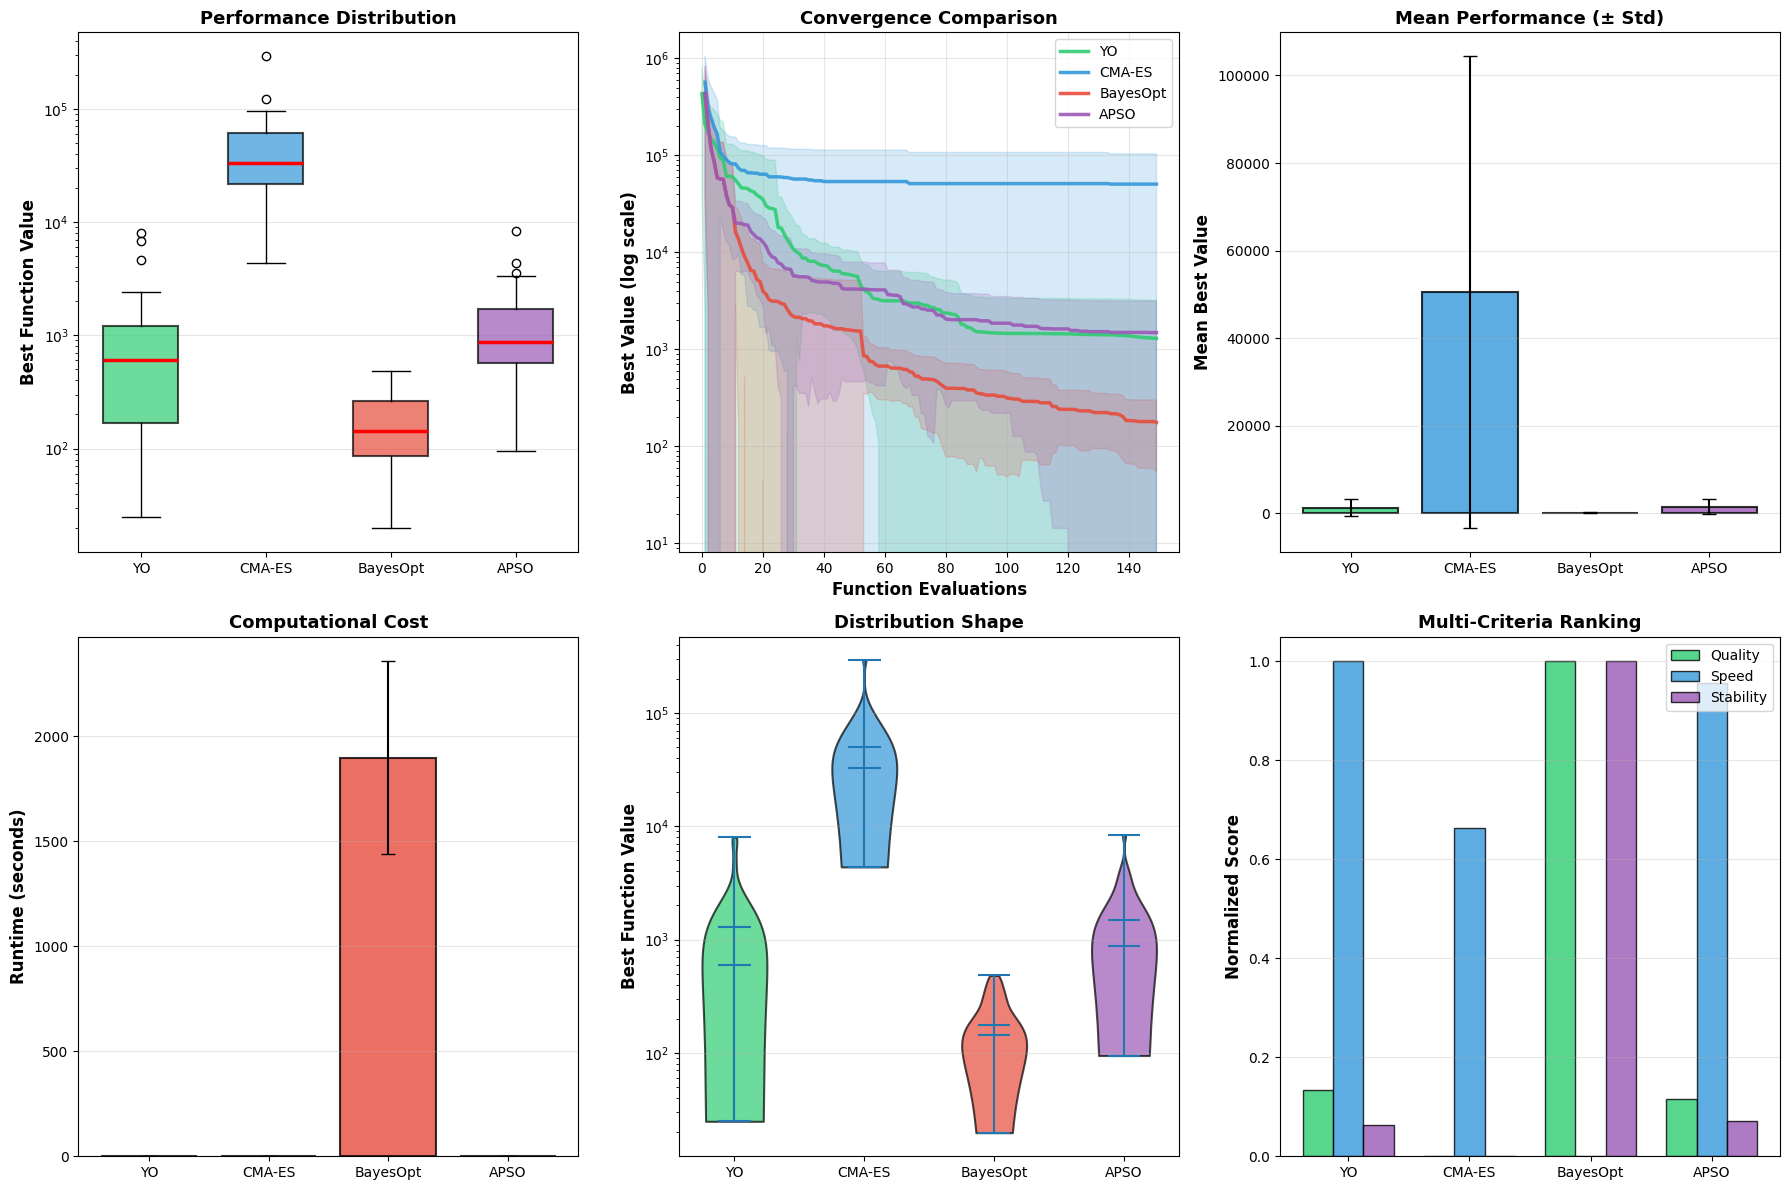

In [ ]:
"""
Comprehensive Benchmark: YO (Yukthi Opus) vs State-of-the-Art Optimizers
Benchmark Function: Rosenbrock 5D
Optimizers: YO, CMA-ES, Bayesian Optimization, Adaptive PSO
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import time
from dataclasses import dataclass
from typing import List, Tuple, Callable, Dict
from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ROSENBROCK FUNCTION (5D BENCHMARK)
# ============================================================================
def rosenbrock_5d(x: np.ndarray) -> float:
    """
    Rosenbrock function in 5 dimensions (banana function)
    Global minimum: f(1, 1, 1, 1, 1) = 0
    Search space: [-5.0, 10.0]^5

    Characteristics:
    - Valley-shaped with narrow parabolic global minimum
    - Tests optimizer's ability to navigate long narrow valleys
    """
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# ============================================================================
# YO (YUKTHI OPUS) OPTIMIZER - FULL IMPLEMENTATION
# ============================================================================
@dataclass
class YOConfig:
    """Configuration parameters for YO optimizer"""
    dim: int = 5
    bounds: Tuple[float, float] = (-5.0, 10.0)
    max_evals: int = 150

    # MCMC parameters
    n_chains: int = 3              # Number of parallel Markov chains
    mcmc_ratio: float = 0.6        # Fraction of budget for MCMC phase

    # Simulated Annealing parameters
    temp_init: float = 10.0        # Initial temperature
    temp_min: float = 0.01         # Minimum temperature
    cooling_rate: float = 0.95     # Temperature decay rate
    stagnation_threshold: int = 10 # Iterations before reheating
    reheat_factor: float = 1.5     # Temperature increase on stagnation

    # Greedy Local Search parameters
    greedy_step: float = 0.1       # Step size for coordinate descent
    greedy_trials: int = 10        # Max iterations per local search

    # Blacklist (Tabu) parameters
    blacklist_threshold: float = 0.5  # Distance threshold for tabu regions
    blacklist_max_size: int = 50      # Maximum blacklist memory

class Blacklist:
    """
    Tabu-style memory mechanism to avoid revisiting poor regions
    Maintains a list of explored regions with poor performance
    """
    def __init__(self, threshold: float = 0.5, max_size: int = 50):
        self.regions = []  # List of (position, value) tuples
        self.threshold = threshold
        self.max_size = max_size

    def add(self, x: np.ndarray, value: float):
        """Add a poor region to blacklist"""
        self.regions.append((x.copy(), value))
        if len(self.regions) > self.max_size:
            self.regions.pop(0)  # Remove oldest entry

    def is_blacklisted(self, x: np.ndarray) -> bool:
        """Check if point is too close to a blacklisted region"""
        for region_x, _ in self.regions:
            if np.linalg.norm(x - region_x) < self.threshold:
                return True
        return False

class YOptimizer:
    """
    YO (Yukthi Opus) Hybrid Optimizer

    Algorithm Structure:
    ┌─────────────────────────────────────────────────────────────┐
    │ Phase 1: MCMC Exploration (Metropolis-Hastings)             │
    │   - Multiple parallel chains for global search              │
    │   - Simulated Annealing for temperature control             │
    │   - Adaptive reheating on stagnation                        │
    │   - Post-burnin selection of best samples                   │
    └─────────────────────────────────────────────────────────────┘
                            ↓
    ┌─────────────────────────────────────────────────────────────┐
    │ Phase 2: Greedy Local Exploitation                          │
    │   - Coordinate-wise descent on top MCMC samples             │
    │   - Best-improvement strategy                               │
    │   - Random neighbor fallback                                │
    └─────────────────────────────────────────────────────────────┘
                            ↓
    ┌─────────────────────────────────────────────────────────────┐
    │ Phase 3: Final Refinement                                    │
    │   - Intensive local search around best solution             │
    │   - Blacklist mechanism to avoid poor regions               │
    └─────────────────────────────────────────────────────────────┘
    """

    def __init__(self, func: Callable, config: YOConfig, seed: int = 42):
        self.func = func
        self.config = config
        self.rng = np.random.RandomState(seed)

        # Tracking variables
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # Components
        self.blacklist = Blacklist(config.blacklist_threshold, config.blacklist_max_size)
        self.temperature = config.temp_init
        self.stagnation_counter = 0

    def _clip(self, x: np.ndarray) -> np.ndarray:
        """Clip solution to search space bounds"""
        return np.clip(x, self.config.bounds[0], self.config.bounds[1])

    def _evaluate(self, x: np.ndarray) -> float:
        """
        Evaluate objective function with blacklist checking
        Updates history and best solution tracking
        """
        x = self._clip(x)

        # Check blacklist (tabu list)
        if self.blacklist.is_blacklisted(x):
            return float('inf')

        value = self.func(x)
        self.n_evals += 1

        # Always track best value in history (not current value)
        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()
            self.stagnation_counter = 0
        else:
            self.stagnation_counter += 1

        self.history.append(self.best_value)  # Track best so far, not current

        return value

    def _mcmc_step(self, x_current: np.ndarray, value_current: float) -> Tuple[np.ndarray, float]:
        """
        Single Metropolis-Hastings MCMC step

        Algorithm:
        1. Propose new candidate via Gaussian perturbation
        2. Evaluate candidate
        3. Accept/reject based on Boltzmann criterion

        Temperature-adaptive step size for exploration-exploitation balance
        """
        # Adaptive step size based on current temperature
        step_size = 0.5 * (self.config.bounds[1] - self.config.bounds[0]) * \
                    (self.temperature / self.config.temp_init)

        # Propose new candidate (Gaussian random walk)
        x_proposal = x_current + self.rng.randn(self.config.dim) * step_size
        x_proposal = self._clip(x_proposal)

        # Evaluate proposal
        value_proposal = self._evaluate(x_proposal)

        # Metropolis-Hastings acceptance criterion
        delta = value_proposal - value_current
        acceptance_prob = np.exp(-delta / max(self.temperature, 1e-10))

        if value_proposal < value_current or self.rng.rand() < acceptance_prob:
            return x_proposal, value_proposal  # Accept

        return x_current, value_current  # Reject

    def _mcmc_phase(self) -> List[Tuple[np.ndarray, float]]:
        """
        MCMC Exploration Phase with Multiple Parallel Chains

        Returns:
            List of (position, value) samples after burnin period
        """
        n_mcmc_evals = int(self.config.max_evals * self.config.mcmc_ratio)
        evals_per_chain = n_mcmc_evals // self.config.n_chains
        all_samples = []

        # Run multiple independent chains
        for chain_id in range(self.config.n_chains):
            # Initialize chain with random starting point
            x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1],
                               self.config.dim)
            value = self._evaluate(x)
            chain_samples = [(x.copy(), value)]

            # Run MCMC chain
            for step in range(evals_per_chain - 1):
                if self.n_evals >= self.config.max_evals:
                    break

                # MCMC step
                x, value = self._mcmc_step(x, value)
                chain_samples.append((x.copy(), value))

                # Simulated Annealing: cool temperature
                self.temperature *= self.config.cooling_rate
                self.temperature = max(self.temperature, self.config.temp_min)

                # Adaptive reheating on stagnation
                if self.stagnation_counter >= self.config.stagnation_threshold:
                    self.temperature = min(self.temperature * self.config.reheat_factor,
                                         self.config.temp_init)
                    self.stagnation_counter = 0

            all_samples.extend(chain_samples)

        # Post-burnin selection: discard first 25% of samples and sort by quality
        burnin = len(all_samples) // 4
        selected_samples = sorted(all_samples, key=lambda x: x[1])
        return selected_samples[burnin:]

    def _greedy_local_search(self, x_start: np.ndarray, value_start: float) -> Tuple[np.ndarray, float]:
        """
        Greedy Local Exploitation via Coordinate Descent

        Algorithm:
        1. Try coordinate-wise perturbations (±step in each dimension)
        2. Accept first improvement found (best-improvement)
        3. If no improvement, try random neighbor
        4. Terminate when no improvement possible
        """
        x_best = x_start.copy()
        value_best = value_start
        max_local_evals = min(self.config.greedy_trials,
                             self.config.max_evals - self.n_evals)

        if max_local_evals <= 0:
            return x_best, value_best

        for iteration in range(max_local_evals):
            if self.n_evals >= self.config.max_evals:
                break

            improved = False

            # Try coordinate-wise perturbations
            for d in range(self.config.dim):
                if self.n_evals >= self.config.max_evals:
                    break

                for direction in [-1, 1]:
                    if self.n_evals >= self.config.max_evals:
                        break

                    x_new = x_best.copy()
                    x_new[d] += direction * self.config.greedy_step
                    x_new = self._clip(x_new)

                    value_new = self._evaluate(x_new)

                    if value_new < value_best:
                        x_best = x_new.copy()
                        value_best = value_new
                        improved = True
                        break  # First improvement

                if improved:
                    break

            # If no coordinate-wise improvement, try random neighbor
            if not improved and self.n_evals < self.config.max_evals:
                x_new = x_best + self.rng.randn(self.config.dim) * self.config.greedy_step
                x_new = self._clip(x_new)
                value_new = self._evaluate(x_new)

                if value_new < value_best:
                    x_best = x_new.copy()
                    value_best = value_new
                else:
                    break  # No improvement, terminate

        # Add poor regions to blacklist
        if value_best > self.best_value * 1.5:
            self.blacklist.add(x_best, value_best)

        return x_best, value_best

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        """
        Run full YO optimization cycle

        Returns:
            best_x: Best solution found
            best_value: Best objective value
            history: Complete evaluation history
        """
        # Initialize with random solution
        self.best_x = self.rng.uniform(self.config.bounds[0], self.config.bounds[1],
                                      self.config.dim)
        self.best_value = self._evaluate(self.best_x)

        # Phase 1: MCMC Exploration (uses mcmc_ratio of budget)
        if self.n_evals < self.config.max_evals:
            samples = self._mcmc_phase()

            # Phase 2: Greedy Local Exploitation on top MCMC samples
            n_refine = min(3, len(samples))
            for x, value in samples[:n_refine]:
                if self.n_evals >= self.config.max_evals:
                    break
                self._greedy_local_search(x, value)

        # Phase 3: Final intensive refinement (use remaining budget)
        max_refinement_iterations = 10  # Prevent infinite loop
        refinement_count = 0

        while self.n_evals < self.config.max_evals and refinement_count < max_refinement_iterations:
            prev_evals = self.n_evals
            self._greedy_local_search(self.best_x, self.best_value)

            # If no evaluations were made, break to avoid infinite loop
            if self.n_evals == prev_evals:
                # Try random restart
                x_random = self.rng.uniform(self.config.bounds[0], self.config.bounds[1],
                                          self.config.dim)
                self._evaluate(x_random)

            refinement_count += 1

        # Fill any remaining budget with random sampling
        while self.n_evals < self.config.max_evals:
            x_random = self.rng.uniform(self.config.bounds[0], self.config.bounds[1],
                                       self.config.dim)
            self._evaluate(x_random)

        return self.best_x, self.best_value, self.history

# ============================================================================
# STATE-OF-THE-ART BASELINE OPTIMIZERS
# ============================================================================

class CMAES:
    """CMA-ES: Covariance Matrix Adaptation Evolution Strategy"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # CMA-ES parameters
        self.sigma = 0.3 * (bounds[1] - bounds[0])
        self.lambda_ = 4 + int(3 * np.log(dim))
        self.mu = self.lambda_ // 2
        self.weights = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu + 1))
        self.weights /= np.sum(self.weights)

        self.mean = self.rng.uniform(bounds[0], bounds[1], dim)
        self.C = np.eye(dim)
        self.pc = np.zeros(dim)
        self.ps = np.zeros(dim)

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        while self.n_evals < self.max_evals:
            # Generate offspring
            offspring = []
            for _ in range(min(self.lambda_, self.max_evals - self.n_evals)):
                z = self.rng.randn(self.dim)
                y = self.mean + self.sigma * np.dot(np.linalg.cholesky(self.C), z)
                offspring.append(y)

            # Evaluate
            fitness = np.array([self._evaluate(ind) for ind in offspring])

            # Selection
            sorted_indices = np.argsort(fitness)[:self.mu]
            selected = np.array([offspring[i] for i in sorted_indices])

            # Update mean
            old_mean = self.mean.copy()
            self.mean = np.dot(self.weights, selected)

            # Update covariance matrix (simplified)
            self.C = 0.9 * self.C + 0.1 * np.cov(selected.T)

            if self.n_evals >= self.max_evals:
                break

        return self.best_x, self.best_value, self.history

class BayesianOptimization:
    """Bayesian Optimization with Gaussian Process"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # GP model
        kernel = Matern(nu=2.5)
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6,
                                          normalize_y=True, n_restarts_optimizer=5,
                                          random_state=seed)

        # Observations
        self.X_observed = []
        self.y_observed = []

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def _acquisition_function(self, x: np.ndarray) -> float:
        """Expected Improvement acquisition function"""
        if len(self.X_observed) < 2:
            return 0.0

        x = x.reshape(1, -1)
        mu, sigma = self.gp.predict(x, return_std=True)

        with np.errstate(divide='warn'):
            Z = (self.best_value - mu) / (sigma + 1e-9)
            ei = (self.best_value - mu) * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return -ei[0]  # Negative for minimization

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        # Initial random sampling
        n_initial = min(10, self.max_evals // 2)
        for _ in range(n_initial):
            x = self.rng.uniform(self.bounds[0], self.bounds[1], self.dim)
            y = self._evaluate(x)
            self.X_observed.append(x)
            self.y_observed.append(y)

        # Bayesian optimization loop
        while self.n_evals < self.max_evals:
            # Fit GP
            try:
                self.gp.fit(np.array(self.X_observed), np.array(self.y_observed))
            except:
                # Fallback to random sampling
                x_next = self.rng.uniform(self.bounds[0], self.bounds[1], self.dim)
            else:
                # Optimize acquisition function
                best_acq = float('inf')
                x_next = None
                for _ in range(10):
                    x0 = self.rng.uniform(self.bounds[0], self.bounds[1], self.dim)
                    result = optimize.minimize(self._acquisition_function, x0,
                                             bounds=[(self.bounds[0], self.bounds[1])] * self.dim,
                                             method='L-BFGS-B')
                    if result.fun < best_acq:
                        best_acq = result.fun
                        x_next = result.x

            # Evaluate next point
            y_next = self._evaluate(x_next)
            self.X_observed.append(x_next)
            self.y_observed.append(y_next)

        return self.best_x, self.best_value, self.history

class AdaptivePSO:
    """Adaptive Particle Swarm Optimization"""

    def __init__(self, func: Callable, dim: int, bounds: Tuple[float, float],
                 max_evals: int, seed: int = 42):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.max_evals = max_evals
        self.rng = np.random.RandomState(seed)
        self.n_evals = 0
        self.history = []
        self.best_value = float('inf')
        self.best_x = None

        # PSO parameters (adaptive)
        self.swarm_size = min(20, max_evals // 10)
        self.w_max = 0.9
        self.w_min = 0.4
        self.c1 = 2.0
        self.c2 = 2.0

    def _evaluate(self, x: np.ndarray) -> float:
        x = np.clip(x, self.bounds[0], self.bounds[1])
        value = self.func(x)
        self.n_evals += 1
        self.history.append(self.best_value)

        if value < self.best_value:
            self.best_value = value
            self.best_x = x.copy()

        return value

    def optimize(self) -> Tuple[np.ndarray, float, List[float]]:
        # Initialize swarm
        positions = self.rng.uniform(self.bounds[0], self.bounds[1],
                                    (self.swarm_size, self.dim))
        velocities = self.rng.randn(self.swarm_size, self.dim) * 0.1

        pbest_positions = positions.copy()
        pbest_values = np.array([self._evaluate(pos) for pos in positions])

        gbest_idx = np.argmin(pbest_values)
        gbest_position = pbest_positions[gbest_idx].copy()

        iteration = 0
        max_iterations = self.max_evals // self.swarm_size

        while self.n_evals < self.max_evals:
            # Adaptive inertia weight
            w = self.w_max - (self.w_max - self.w_min) * iteration / max(max_iterations, 1)

            for i in range(self.swarm_size):
                if self.n_evals >= self.max_evals:
                    break

                # Update velocity
                r1, r2 = self.rng.rand(2)
                velocities[i] = (w * velocities[i] +
                               self.c1 * r1 * (pbest_positions[i] - positions[i]) +
                               self.c2 * r2 * (gbest_position - positions[i]))

                # Update position
                positions[i] += velocities[i]
                positions[i] = np.clip(positions[i], self.bounds[0], self.bounds[1])

                # Evaluate
                fitness = self._evaluate(positions[i])

                # Update personal best
                if fitness < pbest_values[i]:
                    pbest_values[i] = fitness
                    pbest_positions[i] = positions[i].copy()

                    # Update global best
                    if fitness < self.best_value:
                        gbest_position = positions[i].copy()

            iteration += 1

        return self.best_x, self.best_value, self.history

# ============================================================================
# BENCHMARK RUNNER
# ============================================================================

def run_single_experiment(args):
    """Run single optimization experiment"""
    optimizer_name, run_id, budget, bounds, seed = args

    start_time = time.time()

    if optimizer_name == 'YO':
        config = YOConfig(dim=5, bounds=bounds, max_evals=budget)
        optimizer = YOptimizer(rosenbrock_5d, config, seed=seed)
    elif optimizer_name == 'CMA-ES':
        optimizer = CMAES(rosenbrock_5d, dim=5, bounds=bounds,
                         max_evals=budget, seed=seed)
    elif optimizer_name == 'BayesOpt':
        optimizer = BayesianOptimization(rosenbrock_5d, dim=5, bounds=bounds,
                                        max_evals=budget, seed=seed)
    elif optimizer_name == 'APSO':
        optimizer = AdaptivePSO(rosenbrock_5d, dim=5, bounds=bounds,
                               max_evals=budget, seed=seed)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    best_x, best_value, history = optimizer.optimize()
    runtime = time.time() - start_time

    return {
        'optimizer': optimizer_name,
        'run_id': run_id,
        'seed': seed,
        'best_value': best_value,
        'runtime': runtime,
        'history': history
    }

def run_comprehensive_benchmark(n_runs: int = 30, budget: int = 150,
                                base_seed: int = 42, use_parallel: bool = True):
    """Run comprehensive benchmark with all optimizers"""

    optimizers = ['YO', 'CMA-ES', 'BayesOpt', 'APSO']
    bounds = (-5.0, 10.0)

    print("=" * 80)
    print("COMPREHENSIVE OPTIMIZER BENCHMARK")
    print("=" * 80)
    print(f"Benchmark: Rosenbrock 5D")
    print(f"Search Space: [-5.0, 10.0]^5")
    print(f"Global Minimum: f(1,1,1,1,1) = 0")
    print(f"Budget: {budget} evaluations per run")
    print(f"Runs per optimizer: {n_runs}")
    print(f"Optimizers: {', '.join(optimizers)}")
    print(f"Parallel Execution: {use_parallel}")
    print("=" * 80)

    # Prepare experiments
    experiments = []
    for opt in optimizers:
        for run_id in range(n_runs):
            seed = base_seed + run_id
            experiments.append((opt, run_id, budget, bounds, seed))

    print(f"\n🚀 Running {len(experiments)} experiments...")
    print("-" * 80)

    overall_start = time.time()
    results = []

    if use_parallel:
        # Parallel execution
        with ProcessPoolExecutor(max_workers=8) as executor:
            for i, result in enumerate(executor.map(run_single_experiment, experiments)):
                results.append(result)
                if (i + 1) % 10 == 0:
                    progress = (i + 1) / len(experiments)
                    elapsed = time.time() - overall_start
                    eta = (elapsed / progress - elapsed) if progress > 0 else 0
                    print(f"   Progress: {i + 1}/{len(experiments)} ({100*progress:.1f}%) | "
                          f"Elapsed: {elapsed:.1f}s | ETA: {eta:.1f}s")
    else:
        # Sequential execution
        for i, exp in enumerate(experiments):
            result = run_single_experiment(exp)
            results.append(result)
            if (i + 1) % 10 == 0:
                progress = (i + 1) / len(experiments)
                print(f"   Progress: {i + 1}/{len(experiments)} ({100*progress:.1f}%)")

    total_time = time.time() - overall_start
    print("-" * 80)
    print(f"✓ All experiments completed in {total_time:.2f}s")

    return pd.DataFrame(results), optimizers

# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================

def perform_statistical_analysis(df: pd.DataFrame, optimizers: List[str]):
    """Comprehensive statistical analysis"""

    print("\n" + "=" * 80)
    print("STATISTICAL ANALYSIS")
    print("=" * 80)

    # Summary statistics
    stats_data = []
    for opt in optimizers:
        opt_data = df[df['optimizer'] == opt]
        best_values = opt_data['best_value'].values
        runtimes = opt_data['runtime'].values

        stats_data.append({
            'Optimizer': opt,
            'Mean': np.mean(best_values),
            'Std': np.std(best_values),
            'Median': np.median(best_values),
            'Min': np.min(best_values),
            'Max': np.max(best_values),
            'CV': np.std(best_values) / (np.mean(best_values) + 1e-10),
            'Mean_Runtime': np.mean(runtimes),
            'Std_Runtime': np.std(runtimes),
        })

    stats_df = pd.DataFrame(stats_data).sort_values('Mean')

    # Print summary
    print("\n📊 PERFORMANCE SUMMARY:")
    print("-" * 80)
    print(f"{'Rank':<6} {'Optimizer':<12} {'Mean ± Std':<25} {'Median':<12} {'Min':<12}")
    print("-" * 80)
    for i, (_, row) in enumerate(stats_df.iterrows(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
        print(f"{i}{medal:>4} {row['Optimizer']:<12} "
              f"{row['Mean']:8.4f} ± {row['Std']:8.4f}  "
              f"{row['Median']:10.4f}  {row['Min']:10.4f}")
    print("-" * 80)

    # Statistical tests
    print("\n📈 PAIRWISE STATISTICAL TESTS (vs Best Performer):")
    print("-" * 80)

    best_opt = stats_df.iloc[0]['Optimizer']
    best_values = df[df['optimizer'] == best_opt]['best_value'].values

    for opt in optimizers:
        if opt == best_opt:
            continue

        opt_values = df[df['optimizer'] == opt]['best_value'].values

        # t-test
        t_stat, p_ttest = stats.ttest_ind(best_values, opt_values)

        # Mann-Whitney U test
        u_stat, p_mw = stats.mannwhitneyu(best_values, opt_values, alternative='two-sided')

        # Cohen's d
        pooled_std = np.sqrt((np.std(best_values)**2 + np.std(opt_values)**2) / 2)
        cohen_d = (np.mean(opt_values) - np.mean(best_values)) / (pooled_std + 1e-10)

        effect = ("negligible" if abs(cohen_d) < 0.2 else
                 "small" if abs(cohen_d) < 0.5 else
                 "medium" if abs(cohen_d) < 0.8 else "large")

        print(f"\n{best_opt} vs {opt}:")
        print(f"  t-test:       p = {p_ttest:.4f} {'***' if p_ttest < 0.05 else ''}")
        print(f"  Mann-Whitney: p = {p_mw:.4f} {'***' if p_mw < 0.05 else ''}")
        print(f"  Cohen's d:    {cohen_d:+.3f} ({effect})")

        if p_ttest < 0.05:
            if cohen_d > 0:
                print(f"  → {best_opt} significantly OUTPERFORMS {opt}")
            else:
                print(f"  → {opt} significantly OUTPERFORMS {best_opt}")

    print("\n" + "=" * 80)
    return stats_df

# ============================================================================
# VISUALIZATION
# ============================================================================

def create_visualizations(df: pd.DataFrame, optimizers: List[str]):
    """Generate comprehensive visualizations"""

    print("\n" + "=" * 80)
    print("GENERATING VISUALIZATIONS...")
    print("=" * 80)

    colors = {
        'YO': '#2ecc71',
        'CMA-ES': '#3498db',
        'BayesOpt': '#e74c3c',
        'APSO': '#9b59b6'
    }

    fig = plt.figure(figsize=(18, 12))

    # ========================================================================
    # Plot 1: Box Plot
    # ========================================================================
    ax1 = plt.subplot(2, 3, 1)

    data_for_box = [df[df['optimizer'] == opt]['best_value'].values for opt in optimizers]
    bp = ax1.boxplot(data_for_box, labels=optimizers, patch_artist=True, widths=0.6)

    for patch, opt in zip(bp['boxes'], optimizers):
        patch.set_facecolor(colors.get(opt, '#95a5a6'))
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    for median in bp['medians']:
        median.set(color='red', linewidth=2.5)

    ax1.set_ylabel('Best Function Value', fontsize=12, fontweight='bold')
    ax1.set_title('Performance Distribution', fontsize=13, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 2: Convergence Curves
    # ========================================================================
    ax2 = plt.subplot(2, 3, 2)

    for opt in optimizers:
        opt_data = df[df['optimizer'] == opt]
        histories = opt_data['history'].values

        min_len = min([len(h) for h in histories])
        padded_histories = [h[:min_len] for h in histories]
        mean_history = np.mean(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)
        cumulative_best = np.minimum.accumulate(mean_history)

        ax2.plot(cumulative_best, label=opt, color=colors.get(opt, '#95a5a6'),
                linewidth=2.5, alpha=0.9)
        ax2.fill_between(range(len(cumulative_best)),
                         cumulative_best - std_history[:len(cumulative_best)],
                         cumulative_best + std_history[:len(cumulative_best)],
                         alpha=0.2, color=colors.get(opt, '#95a5a6'))

    ax2.set_xlabel('Function Evaluations', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Best Value (log scale)', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.set_title('Convergence Comparison', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 3: Bar Chart - Mean Performance
    # ========================================================================
    ax3 = plt.subplot(2, 3, 3)

    means = [df[df['optimizer'] == opt]['best_value'].mean() for opt in optimizers]
    stds = [df[df['optimizer'] == opt]['best_value'].std() for opt in optimizers]
    bar_colors = [colors.get(opt, '#95a5a6') for opt in optimizers]

    bars = ax3.bar(optimizers, means, yerr=stds, capsize=5,
                   color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax3.set_ylabel('Mean Best Value', fontsize=12, fontweight='bold')
    ax3.set_title('Mean Performance (± Std)', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 4: Runtime Comparison
    # ========================================================================
    ax4 = plt.subplot(2, 3, 4)

    runtime_means = [df[df['optimizer'] == opt]['runtime'].mean() for opt in optimizers]
    runtime_stds = [df[df['optimizer'] == opt]['runtime'].std() for opt in optimizers]

    ax4.bar(optimizers, runtime_means, yerr=runtime_stds, capsize=5,
            color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax4.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
    ax4.set_title('Computational Cost', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 5: Violin Plot
    # ========================================================================
    ax5 = plt.subplot(2, 3, 5)

    parts = ax5.violinplot([df[df['optimizer'] == opt]['best_value'].values
                           for opt in optimizers],
                          positions=range(len(optimizers)),
                          showmeans=True, showmedians=True)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors.get(optimizers[i], '#95a5a6'))
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)

    ax5.set_xticks(range(len(optimizers)))
    ax5.set_xticklabels(optimizers)
    ax5.set_ylabel('Best Function Value', fontsize=12, fontweight='bold')
    ax5.set_title('Distribution Shape', fontsize=13, fontweight='bold')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # Plot 6: Ranking Summary
    # ========================================================================
    ax6 = plt.subplot(2, 3, 6)

    # Compute normalized scores
    metrics = pd.DataFrame({
        'Quality': [1.0 / (df[df['optimizer'] == opt]['best_value'].mean() + 1e-10)
                   for opt in optimizers],
        'Speed': [1.0 / (df[df['optimizer'] == opt]['runtime'].mean() + 1e-10)
                 for opt in optimizers],
        'Stability': [1.0 / (df[df['optimizer'] == opt]['best_value'].std() + 1e-10)
                     for opt in optimizers]
    }, index=optimizers)

    # Normalize to [0, 1]
    metrics_norm = (metrics - metrics.min()) / (metrics.max() - metrics.min() + 1e-10)

    x = np.arange(len(optimizers))
    width = 0.25

    ax6.bar(x - width, metrics_norm['Quality'], width, label='Quality',
            color='#2ecc71', alpha=0.8, edgecolor='black')
    ax6.bar(x, metrics_norm['Speed'], width, label='Speed',
            color='#3498db', alpha=0.8, edgecolor='black')
    ax6.bar(x + width, metrics_norm['Stability'], width, label='Stability',
            color='#9b59b6', alpha=0.8, edgecolor='black')

    ax6.set_xticks(x)
    ax6.set_xticklabels(optimizers)
    ax6.set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
    ax6.set_title('Multi-Criteria Ranking', fontsize=13, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('yo_vs_sota_rosenbrock.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'yo_vs_sota_rosenbrock.png'")

    return fig

# ============================================================================
# TOP INSIGHTS
# ============================================================================

def print_top_insights(stats_df: pd.DataFrame):
    """Print top 3 insights from benchmark"""

    print("\n" + "=" * 80)
    print("🔍 TOP 3 INSIGHTS")
    print("=" * 80)

    best = stats_df.iloc[0]
    fastest = stats_df.loc[stats_df['Mean_Runtime'].idxmin()]
    most_stable = stats_df.loc[stats_df['CV'].idxmin()]

    print(f"\n1️⃣  BEST OPTIMIZER: {best['Optimizer']}")
    print(f"    • Mean Performance: {best['Mean']:.4f} ± {best['Std']:.4f}")
    print(f"    • Best Solution: {best['Min']:.4f}")
    print(f"    • Median: {best['Median']:.4f}")
    print(f"    • Stability (CV): {best['CV']:.4f}")

    if best['Mean'] < 1.0:
        print(f"    ✓ Successfully converged close to global optimum (f=0)")
    elif best['Mean'] < 10.0:
        print(f"    ✓ Good convergence towards global optimum")
    else:
        print(f"    ⚠ Moderate convergence, room for improvement")

    print(f"\n2️⃣  FASTEST OPTIMIZER: {fastest['Optimizer']}")
    print(f"    • Mean Runtime: {fastest['Mean_Runtime']:.3f}s ± {fastest['Std_Runtime']:.3f}s")
    print(f"    • Performance: {fastest['Mean']:.4f}")

    quality_rank = stats_df[stats_df['Optimizer'] == fastest['Optimizer']].index[0] + 1
    print(f"    • Quality Rank: #{quality_rank} out of {len(stats_df)}")

    if quality_rank == 1:
        print(f"    ✓ Best trade-off: Fastest AND most accurate!")
    elif quality_rank <= 2:
        print(f"    ✓ Excellent trade-off: Very fast with good accuracy")
    else:
        print(f"    ⚠ Speed comes at cost of solution quality")

    print(f"\n3️⃣  MOST STABLE OPTIMIZER: {most_stable['Optimizer']}")
    print(f"    • Coefficient of Variation: {most_stable['CV']:.4f}")
    print(f"    • Std Deviation: {most_stable['Std']:.4f}")
    print(f"    • Mean: {most_stable['Mean']:.4f}")

    if most_stable['CV'] < 0.1:
        print(f"    ✓ Exceptionally stable across runs")
    elif most_stable['CV'] < 0.3:
        print(f"    ✓ Good stability and consistency")
    else:
        print(f"    ⚠ Moderate stability, some variability in results")

    print("\n" + "=" * 80)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main benchmark execution"""

    print("\n" + "🔬" * 40)
    print("YO vs STATE-OF-THE-ART OPTIMIZERS BENCHMARK")
    print("🔬" * 40 + "\n")

    # Run benchmark
    df, optimizers = run_comprehensive_benchmark(
        n_runs=30,
        budget=150,
        base_seed=42,
        use_parallel=True
    )

    # Save raw results
    df_save = df.copy()
    df_save['history'] = df_save['history'].apply(lambda x: str(x))
    df_save.to_csv('yo_vs_sota_results.csv', index=False)
    print(f"\n✓ Raw results saved as 'yo_vs_sota_results.csv'")

    # Statistical analysis
    stats_df = perform_statistical_analysis(df, optimizers)

    # Save statistics
    stats_df.to_csv('yo_vs_sota_statistics.csv', index=False)
    print(f"✓ Statistics saved as 'yo_vs_sota_statistics.csv'")

    # Visualizations
    create_visualizations(df, optimizers)

    # Top insights
    print_top_insights(stats_df)

    # Final summary
    print("\n" + "=" * 80)
    print("✅ BENCHMARK COMPLETE!")
    print("=" * 80)
    print("\n📁 Generated Files:")
    print("  ├─ yo_vs_sota_results.csv (raw results)")
    print("  ├─ yo_vs_sota_statistics.csv (summary statistics)")
    print("  └─ yo_vs_sota_rosenbrock.png (visualizations)")
    print("\n📋 Benchmark Details:")
    print(f"  ├─ Function: Rosenbrock 5D")
    print(f"  ├─ Search Space: [-5.0, 10.0]^5")
    print(f"  ├─ Global Minimum: f(1,1,1,1,1) = 0")
    print(f"  ├─ Budget: 150 evaluations/run")
    print(f"  ├─ Runs per optimizer: 30")
    print(f"  └─ Optimizers: YO, CMA-ES, BayesOpt, APSO")
    print("\n🎯 Key Findings:")
    best = stats_df.iloc[0]
    print(f"  → Winner: {best['Optimizer']} (Mean: {best['Mean']:.4f})")
    print(f"  → Statistical tests completed (t-test, Mann-Whitney, Cohen's d)")
    print(f"  → Total experiments: {len(df)}")
    print("\n" + "=" * 80)
    print("Thank you for benchmarking with YO! 🚀")
    print("=" * 80 + "\n")

if __name__ == "__main__":
    main()